## Test Model 2030

In [1]:
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
from pypsa.plot import add_legend_patches
import gurobipy
import cartopy.crs as ccrs
from pypsa.optimization import optimize
import matplotlib.cm as cm
import numpy as np

pd.set_option("display.max_rows", None)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns


## Import Network

In [2]:
n = pypsa.Network("C:\\Users\\Jeremy\\Documents\\MasterThesis\\Models\\Model_IT\\20240319_IT3zeroem\\elec_s_3_ec_lv1.5_Co2L0.0-3h.nc")


INFO:pypsa.io:Imported network elec_s_3_ec_lv1.5_Co2L0.0-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 6 entries
Component 'Carrier' has 23 entries
Component 'GlobalConstraint' has 2 entries
Component 'Line' has 1 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 7 entries
Component 'Load' has 3 entries
Component 'Generator' has 44 entries
Component 'StorageUnit' has 9 entries
Component 'Store' has 3 entries


In [5]:
n.global_constraints.loc['CO2Limit','constant']=90000000

In [6]:
# set marginal cost of load shedding to 3000€/MWh
for bus in n.generators.bus:
    for index in n.generators.index:
        if not bus.endswith('H2') and index.endswith('load'):
            n.generators.loc[index, 'marginal_cost'] = 3000

#edit load shedding's unit from kW to MW
for index in n.generators.index:
    if index.endswith('load') and not index.endswith('H2 load'):
        n.generators.loc[index, 'sign'] = 1

In [7]:
#solve network
#n.optimize(solver_name='gurobi')
n.lopf(solver_name='gurobi')

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2918086421.py:3: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  n.lopf(solver_name='gurobi')
INFO:pypsa.linopf:Prepare linear problem


INFO:pypsa.linopf:Total preparation time: 4.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-09
Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\pypsa-problem-qgzn7t_3.lp
Reading time = 2.25 seconds
obj: 531442 rows, 256989 columns, 997217 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 531442 rows, 256989 columns and 997217 nonzeros
Model fingerprint: 0xea557230
Coefficient statistics:
  Matrix range     [1e-03, 8e+02]
  Objective range  [3e-02, 2e+05]
  Bounds range     [4e+00, 2e+09]
  RHS range        [3e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 389818 rows and 62857 columns
Presolve time: 0.67s
Presolved: 141624 rows, 194132 columns, 515343 nonzeros

INFO:pypsa.linopf:Optimization successful. Objective value: 1.22e+10


('ok', 'optimal')

In [8]:
def system_cost(n): #n.statistics.capex()
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6) # million €/a

In [9]:
tot_cos_base=n.objective/1e9
system_cost_base = system_cost(n)
marg_price_region_base = n.buses_t.marginal_price.mean()
stat_base = n.statistics()

## Plot Network

<function matplotlib.pyplot.show(close=None, block=None)>

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


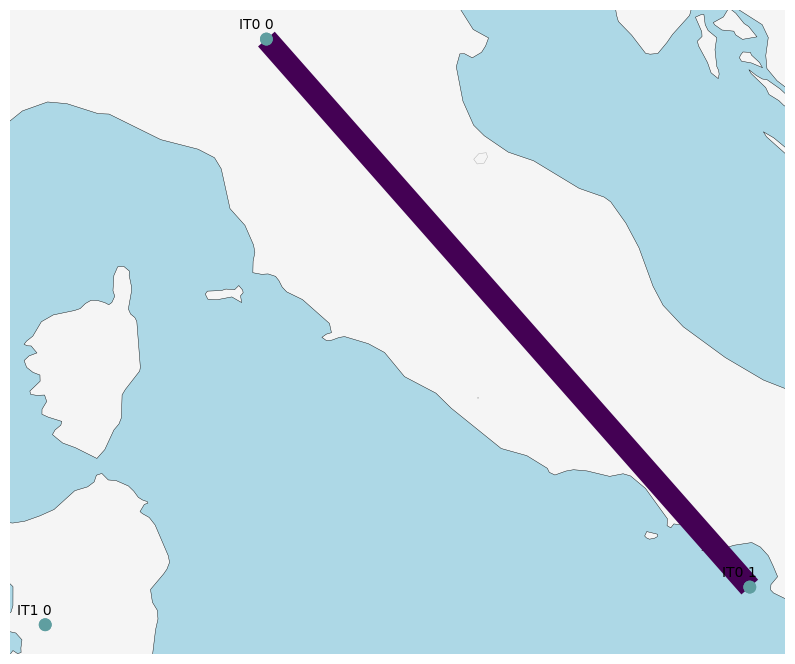

In [10]:
loading = (n.lines_t.p0.abs().mean().sort_index()/(n.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

fig, ax = plt.subplots(
    figsize=(10,10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

n.plot(
    ax=ax,
    branch_components=["Line"],
    line_widths=n.lines.s_nom_opt/1e3, #GW
    line_colors=loading,
    line_cmap=plt.cm.viridis,
    color_geomap=True,
    bus_sizes=0.003
)

bus = n.buses
region = []
for index, row in bus.iterrows():
    x = row['x']
    y = row['y']
    if "H2" in index:
        pass
    else:
        region.append(index)
        ax.annotate(
        index,
        xy=(x, y),
        xytext=(5, 5),  # Adjust the position of the annotation
        textcoords="offset points",
        ha='right', va='bottom'
    )

plt.show


## Installed Capacity Map Plot

In [11]:
#color list for installed cap
tech_list = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack().columns.tolist()
tech_list.remove('load')
color_cap = []

for i in range(len(tech_list)):
    for j in range(len(n.carriers.index)):
        if tech_list[i] == n.carriers.index[j]:
            color_cap.append(n.carriers.color[j])
            break  # break the inner loop once a match is found  

cap = n.generators[n.generators['carrier']!='load'].groupby(['bus', 'carrier']).p_nom_opt.sum()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3847545614.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_cap.append(n.carriers.color[j])


c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


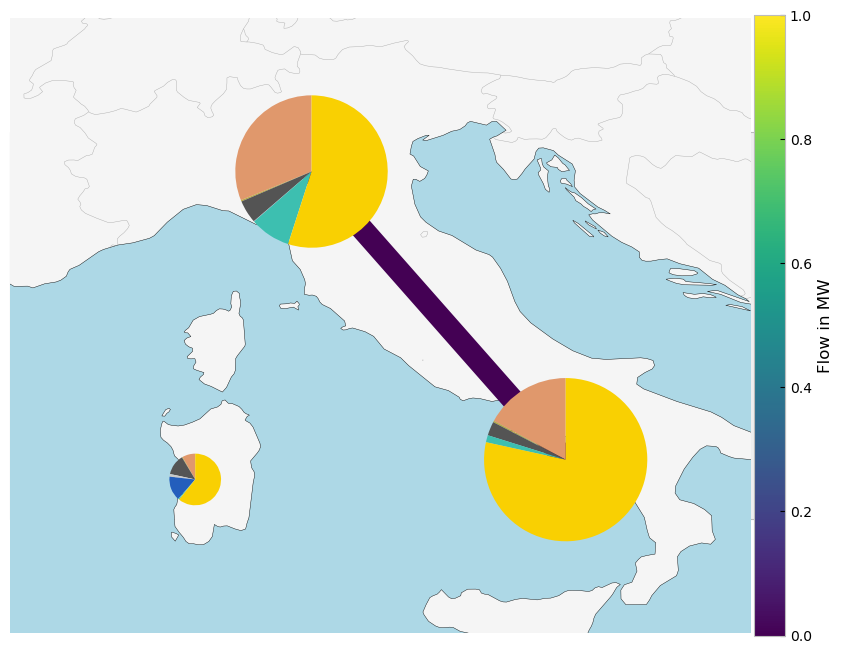

In [12]:
fig, ax = plt.subplots(
    figsize=(10,10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

collection = n.plot(
    bus_sizes=cap / 5e4,
    bus_colors = color_cap,
    margin=0.5,
    #flow="mean",
    line_widths=n.lines.s_nom_opt/1e3, #GW
    link_widths=0,
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)
        
plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

## Generation Map Plot

In [13]:
#color list for energy generated 
tech_list_gen_table = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack().columns.tolist()
colors_gen_table = []

for i in range(len(tech_list_gen_table)):
    for j in range(len(n.carriers.index)):
        if tech_list_gen_table[i] == n.carriers.index[j]:
            colors_gen_table.append(n.carriers.color[j])
            break  # break the inner loop once a match is found 

#Adjust Load shedding's unit to MW from kW
#for column in n.generators_t.p.columns:
#    if column.endswith('load') and not column.endswith('H2 load'):
#        n.generators_t.p[column]/=1e3
        

gen = n.generators.assign(g=n.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\971004373.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors_gen_table.append(n.carriers.color[j])


c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


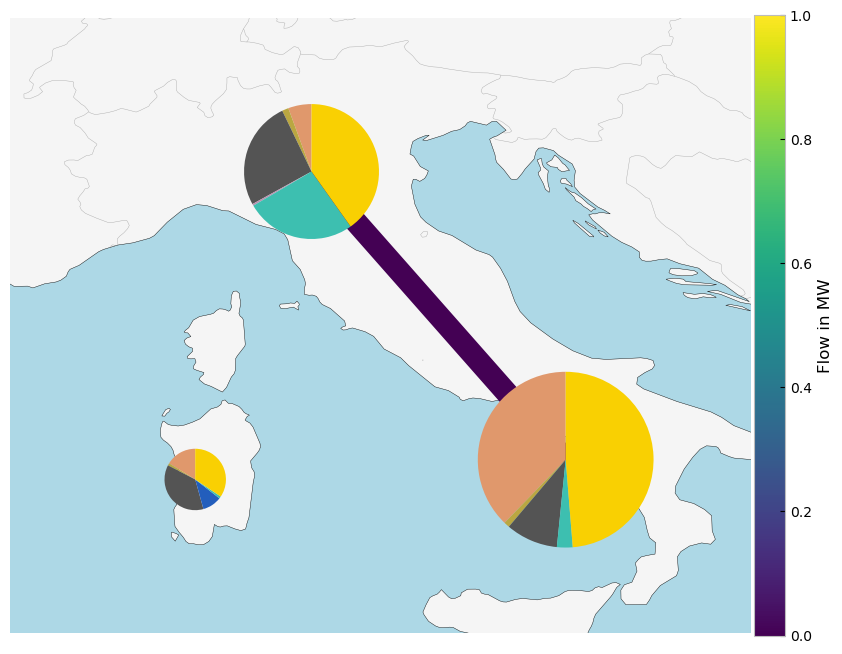

In [14]:
carriers = n.generators.carrier.unique()

plt.figure(figsize =(10,10))

collection = n.plot(
    bus_sizes=gen / 1e4,
    bus_colors = colors_gen_table,
    margin=0.5,
    #flow="mean",
    line_widths=n.lines.s_nom_opt/1e3, #GW
    link_widths=0,
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)
plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

## Installed Capacity

In [15]:
def inst_cap_table(n,colors):

    capacities = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
    capacities.fillna(0, inplace=True)
    gen = (capacities.unstack()/1000).drop(columns=['load'],inplace=False)
    gen.fillna(0, inplace=True)

    plt.figure()
    plt.rcParams.update({'font.size': 16})

    gen.plot.bar(figsize=(17,10),
                                stacked=True,
                                color=colors,
                                grid=True,
                                xlabel="",
                                ylabel="Installed capacity [GW]",
                                title=f"Installed power capacity in Italy"
    )

    plt.show()
    return capacities
    
capacities_base = inst_cap_table(n, color_cap)

<Figure size 640x480 with 0 Axes>

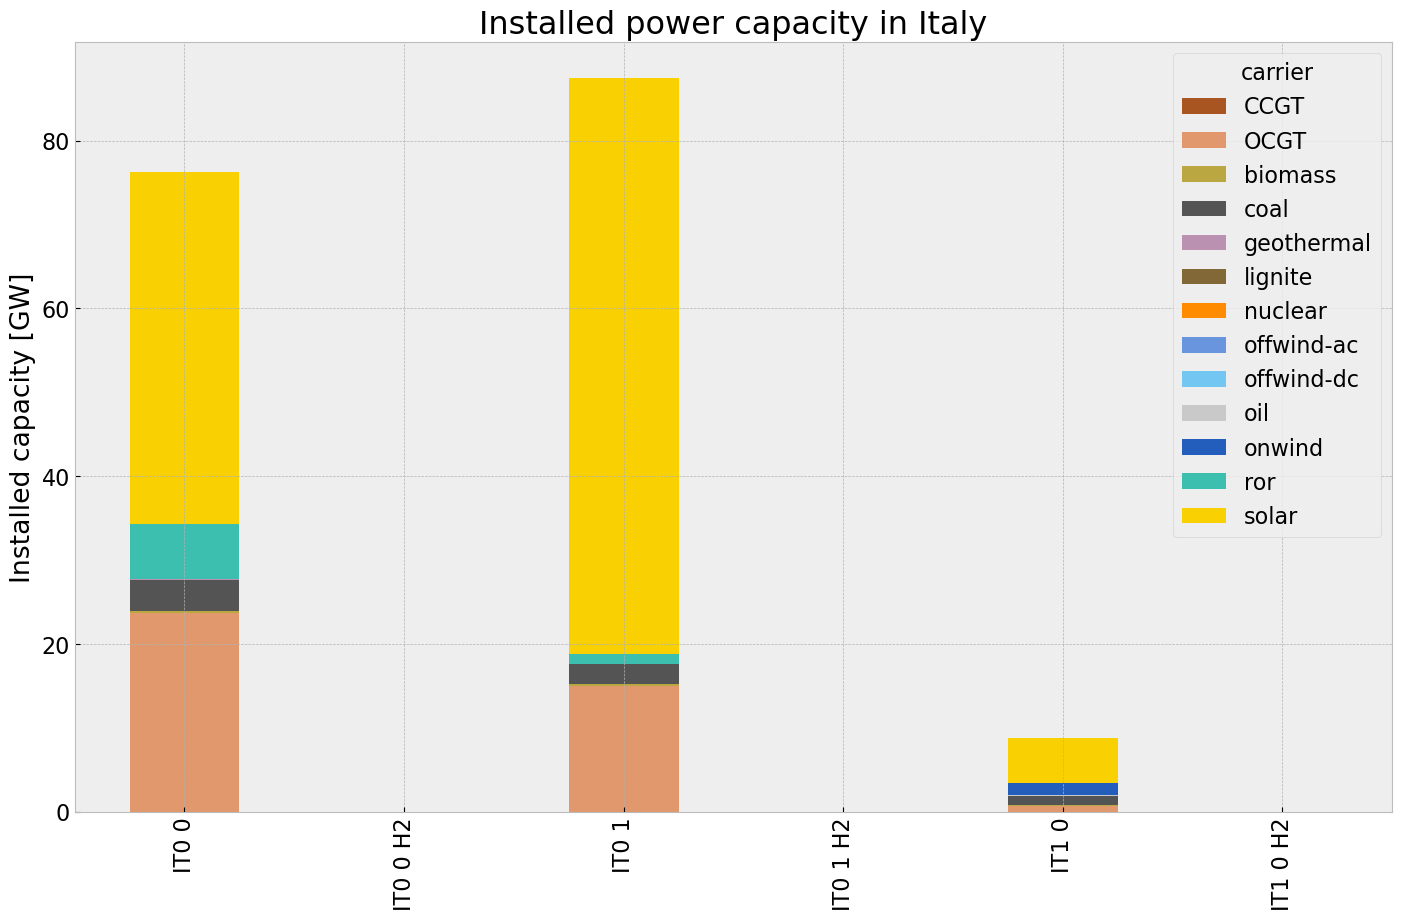

In [16]:
# consolidated istalled cap without load_shedding

#capacities_base = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
#capacities_base.fillna(0, inplace=True)
#gen = (capacities_base.unstack()/1000).drop(columns=['load'],inplace=False)

capacities_base = inst_cap_table(n, color_cap)


## Generation

<Figure size 640x480 with 0 Axes>

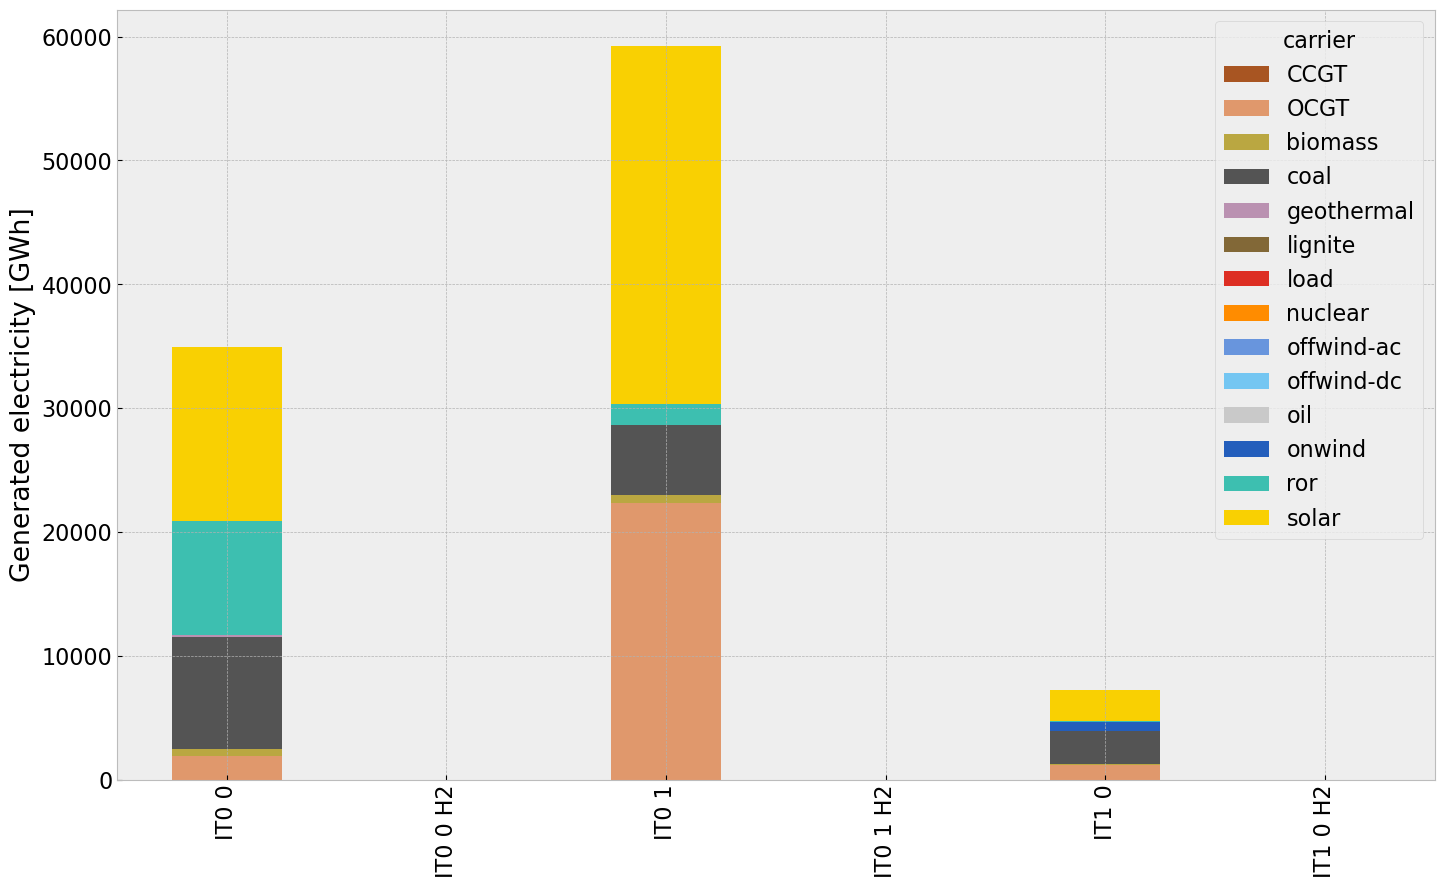

In [90]:
def gen_power_table(n, color):

    carrier = n.generators.carrier.unique()
    df_tot_generation = n.generators_t.p.sum()

    generations = pd.Series(index = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

    for r in region:
        for tech in carrier:
            key = f"{r} {tech}"
            if key in df_tot_generation.index:
                try:
                    generations.loc[r, tech] = df_tot_generation[key]
                    #print(generations.loc[r, tech])
                except KeyError:
                    print('error')
    generations.fillna(0, inplace=True)

    generations = (generations.unstack()/1000)#GWh
    #generations['load']/=1e3


    plt.figure()
    plt.rcParams.update({'font.size': 16})

    generations.plot.bar(figsize=(17,10),
                                stacked=True,
                                color=color,
                                grid=True,
                                xlabel="",
                                ylabel="Generated electricity [GWh]",
                                #title=f"Generated electricity in Italy in {year}"
    )

    plt.show()
    return generations
    
gen_base = gen_power_table(n,colors_gen_table)

## Snapshot

In [19]:
sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
tech_list_gen = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
links = n.links_t.p0.groupby(n.links.carrier, axis =1).sum().drop(['DC','H2 electrolysis'], axis=1, inplace =False).head()
tech_list_gen = pd.concat([tech_list_gen, sto], axis=1).columns.tolist()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3551839577.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3551839577.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tech_list_gen = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3551839577.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p0.groupby(n.links.carrier, axis =1).sum().drop(['DC','H2 electrolysis'], axis=1, inplace =False).head()


In [20]:
colors_gen = []

for i in range(len(tech_list_gen)):
    for j in range(len(n.carriers.index)):
        if tech_list_gen[i] == n.carriers.index[j]:
            colors_gen.append(n.carriers.color[j])
            break  # break the inner loop once a match is found  


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3660868222.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors_gen.append(n.carriers.color[j])


In [21]:
def gen_curve(n, start, end, colors):

    plt.rcParams.update({'font.size': 16})


    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    #p_by_carrier['load'] /= 1e3

    #links fuel cell
    links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
    links = links.drop(columns='DC', inplace=False)
    links['H2 fuel cell']*=-1
       
    # join generator, links, and storage unit
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)     
        p_by_carrier = pd.concat([p_by_carrier, sto, links], axis=1)
        
    p_by_carrier.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')

    start_date = start
    end_date = end
    
    # Create a date range for the specified time range
    time = pd.date_range(start=start_date, end=end_date, freq='3H')
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    p_no_H = p_by_carrier.drop(columns = 'H2 electrolysis', inplace = False)
    p_no_H.where(p_no_H>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=colors,
        grid=True,

    )
    
    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]
    
    
    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=["yellowgreen", "magenta", "purple", "grey"],
            grid=True,
        )
    
    loads = n.loads_t.p_set.sum(axis=1).div(1e3)
    loads.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')
    
    loads.loc[time].plot(ax=ax, c='k',grid=True)


    plt.legend(loc=(1.05,0))
    
    ax.set_ylabel("Power [GW]")
    ax.set_title(f"Hourly electricity production")


    ax.set_ylim(-100,150)

In [22]:
#e_balance = n.statistics.energy_balance(aggregate_time=False, aggregate_bus=False).loc[:, :, "AC",:].droplevel(2)
#e_balance.to_excel('energybalance.xlsx', index=True) 


In [23]:
#tes = n.statistics.energy_balance(aggregate_time=False, aggregate_bus=False).loc[:, :, "AC", :].droplevel(2)
#tes.to_csv('energybalance.csv', index=True)

In [24]:
#n.loads_t.p_set.sum(axis=1).loc[pd.date_range(start='2013-01-08', end='2013-01-14', freq='3H')].div(1e3).plot(ax=ax, c='k',grid=True)


In [25]:
#p_by_carrier.where(p_by_carrier>0).loc[pd.date_range(start='2013-01-08', end='2013-01-14', freq='3H')].sum(axis=1)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  p_by_carrier.index = pd.date_range(start='2030-01-01', end=

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  loads.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')


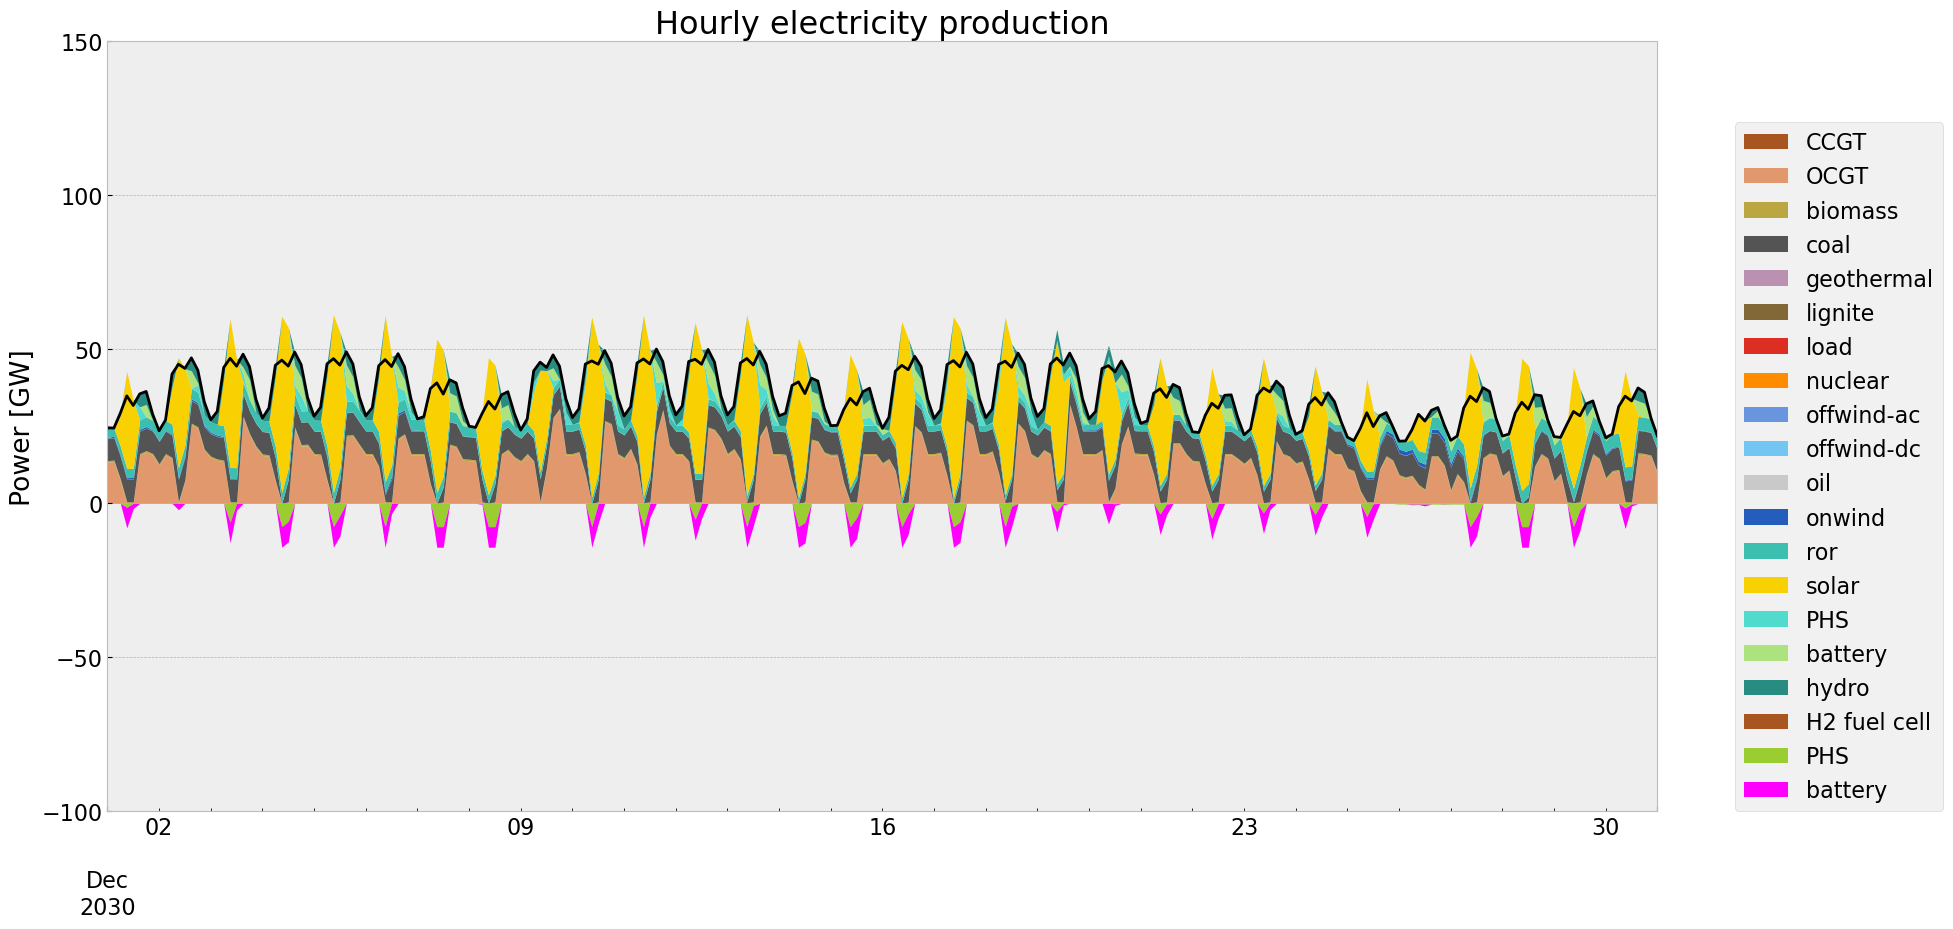

In [26]:
# winter
gen_curve(n, '2030-12-01', '2030-12-31', colors_gen)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  p_by_carrier.index = pd.date_range(start='2030-01-01', end=

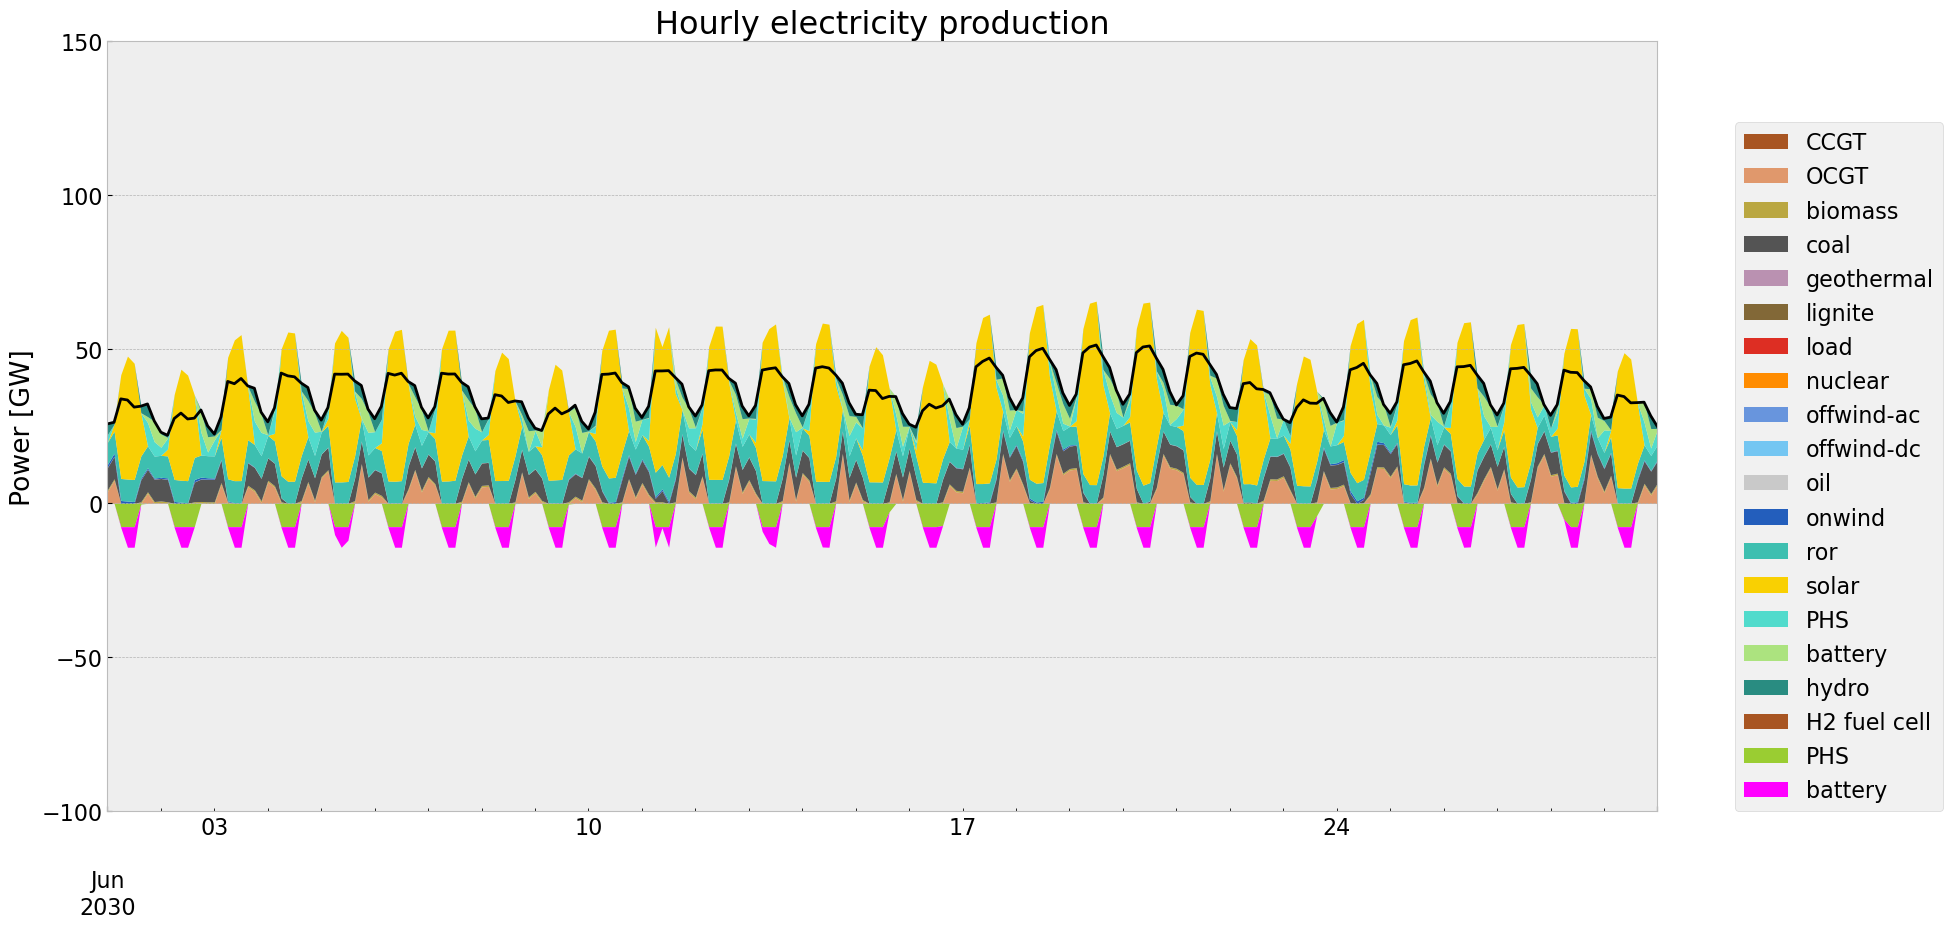

In [27]:
#summer
gen_curve(n, '2030-06-01', '2030-06-30', colors_gen)

## Storage

In [28]:
def inst_store_table(n):
    
    plt.rcParams.update({'font.size': 16})

    (n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000).plot.bar(figsize=(17,10),
                                stacked=True,
                                color=["yellowgreen","magenta","red","blue"],
                                grid=True,
                                xlabel="",
                                ylabel="Installed capacity [GW]",
                                #title=f"Installed power capacities of storage systems in Italy in {year}",
                                ylim=[0,20]
    )

    return n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000

carrier     PHS   battery   hydro
bus                              
IT0 0    4.9359  0.000000  3.5108
IT0 1    2.3960  6.103396  0.6060
IT1 0    0.2400  0.571904  0.0780

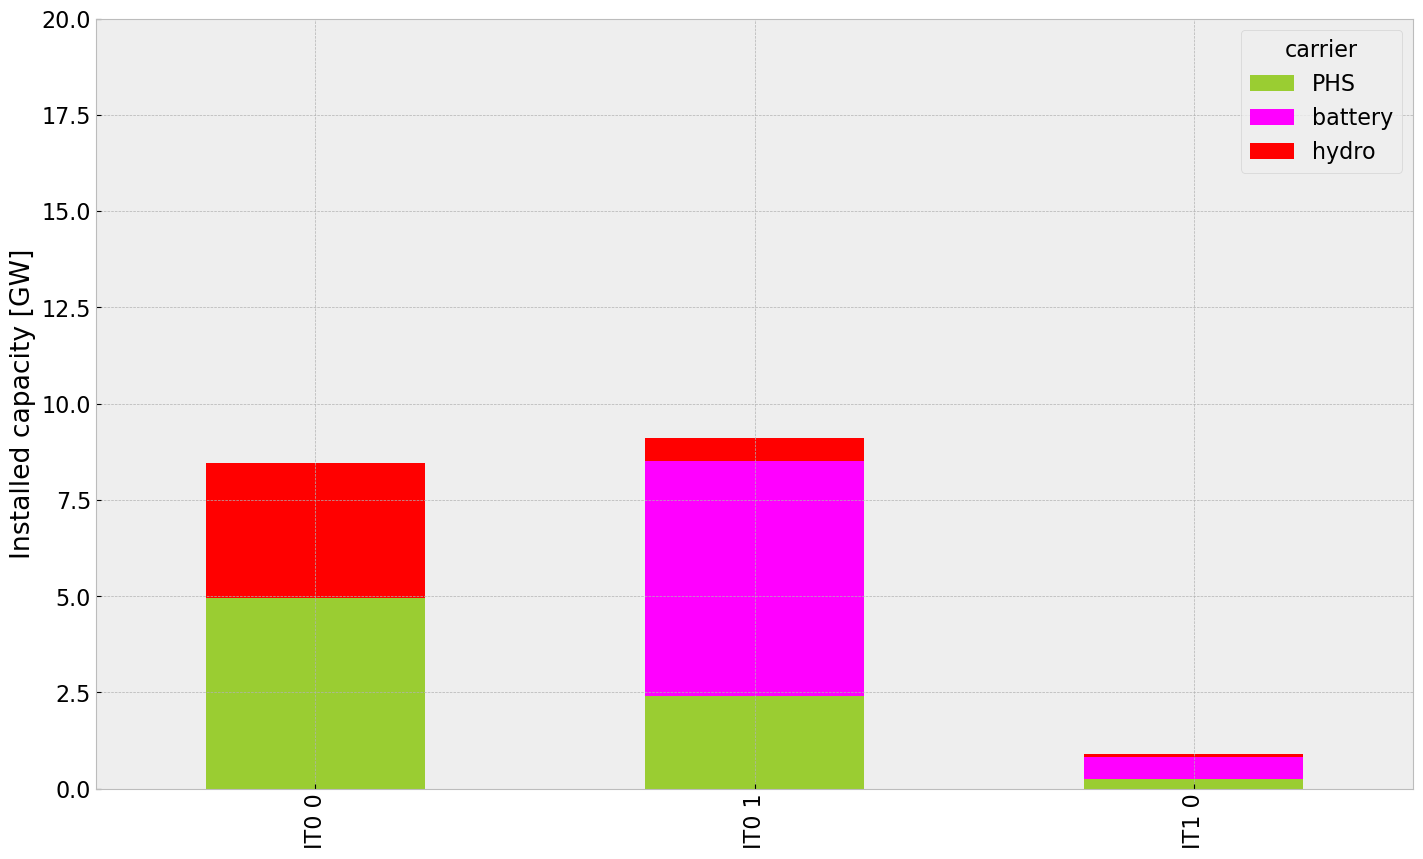

In [29]:
inst_store_table(n)

In [30]:
n.stores.groupby(['bus','carrier']).e_nom_opt.sum().unstack()/1000

carrier    H2
bus          
IT0 0 H2  0.0
IT0 1 H2  0.0
IT1 0 H2  0.0

In [31]:
def inst_storeh2_table(n):
    
    plt.rcParams.update({'font.size': 16})

    (n.stores.groupby(['bus','carrier']).e_nom_opt.sum().unstack()/1000).plot.bar(figsize=(17,10),
                                stacked=True,
                                color=["blue"],
                                grid=True,
                                xlabel="",
                                ylabel="H2 Store Energy Capacity [GWh]",
                                #title=f"Installed power capacities of storage systems in Italy in {year}",
                                ylim=[0,7500]
    )

    return n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000

carrier     PHS   battery   hydro
bus                              
IT0 0    4.9359  0.000000  3.5108
IT0 1    2.3960  6.103396  0.6060
IT1 0    0.2400  0.571904  0.0780

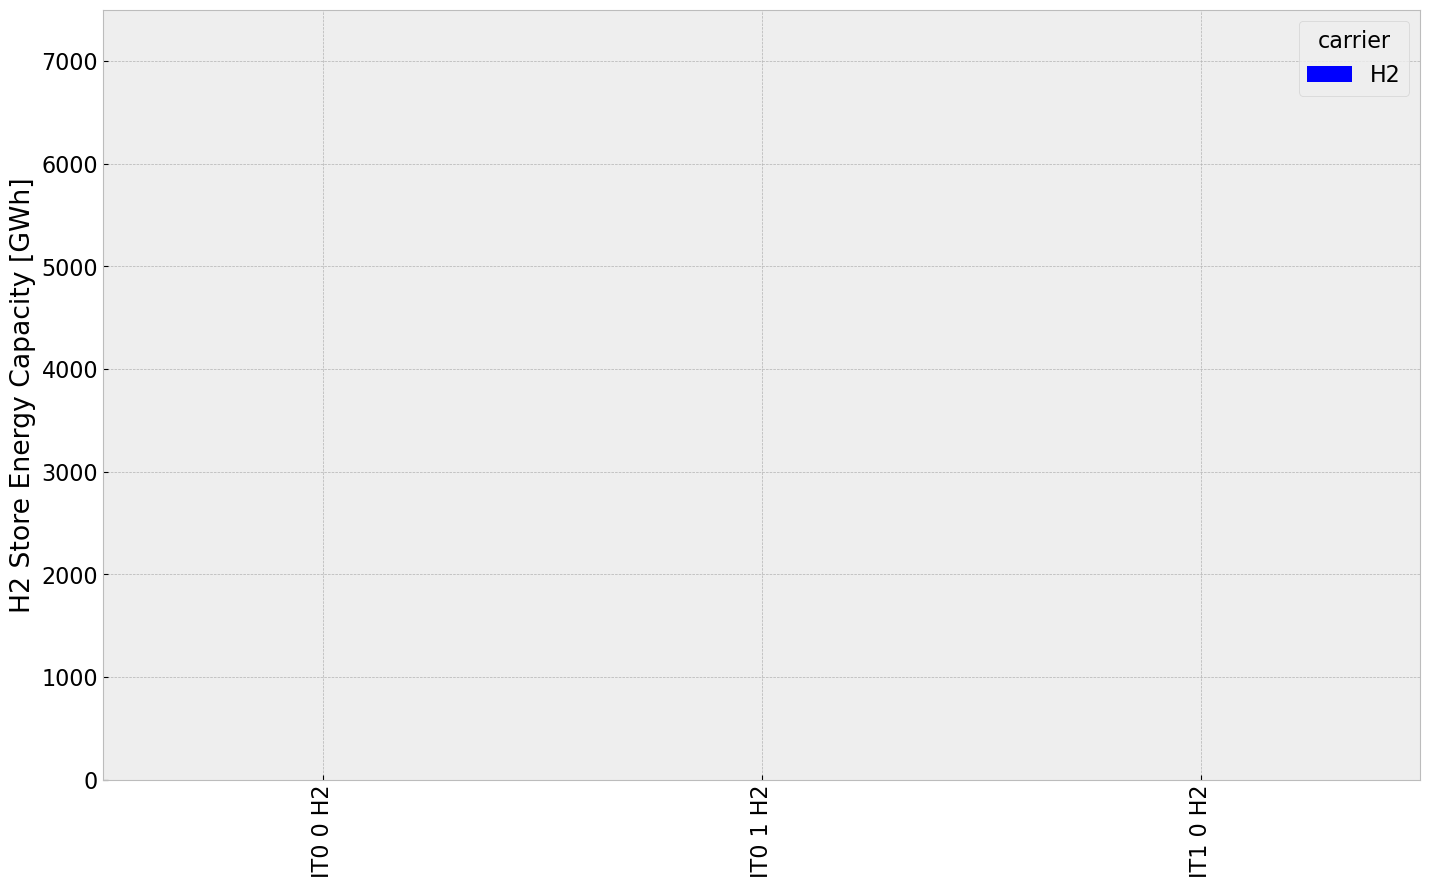

In [32]:
inst_storeh2_table(n)

In [33]:
n.stores

bus carrier  e_nom_extendable  e_cyclic  capital_cost  \
Store                                                                  
IT0 0 H2  IT0 0 H2      H2              True      True     148.31893   
IT0 1 H2  IT0 1 H2      H2              True      True     148.31893   
IT1 0 H2  IT1 0 H2      H2              True      True     148.31893   

          marginal_cost  build_year  e_nom_opt type  e_nom  e_nom_mod  \
Store                                                                   
IT0 0 H2       0.010733           0        0.0         0.0        0.0   
IT0 1 H2       0.009501           0        0.0         0.0        0.0   
IT1 0 H2       0.009966           0        0.0         0.0        0.0   

          e_nom_min  e_nom_max  e_min_pu  e_max_pu  e_initial  \
Store                                                           
IT0 0 H2        0.0        inf       0.0       1.0        0.0   
IT0 1 H2        0.0        inf       0.0       1.0        0.0   
IT1 0 H2        0.0        inf       0.0       1.0        0.0   

          e_initial_per_period  e_cyclic_per_period  p_set  q_set  sign  \
Store                                                                     
IT0 0 H2                 False                 True    0.0    0.0   1.0   
IT0 1 H2                 False                 True    0.0    0.0   1.0   
IT1 0 H2                 False                 True    0.0    0.0   1.0   

          marginal_cost_quadratic  standing_loss  lifetime  
Store                                                       
IT0 0 H2                      0.0            0.0       inf  
IT0 1 H2                      0.0            0.0       inf  
IT1 0 H2                      0.0            0.0       inf

In [34]:
def state_of_charge_plot(n):
    
    soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)

    soc.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(17,10))

    soc.plot(ax=ax,
        grid=True,
        ylabel="State of charge [GWh]",
        xlabel="Time",
        #title=f"State of charge of aggregated storage systems in Italy in {year}",
        linewidth=1.5,
)

plt.show(n)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\440258284.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\440258284.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  soc.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')


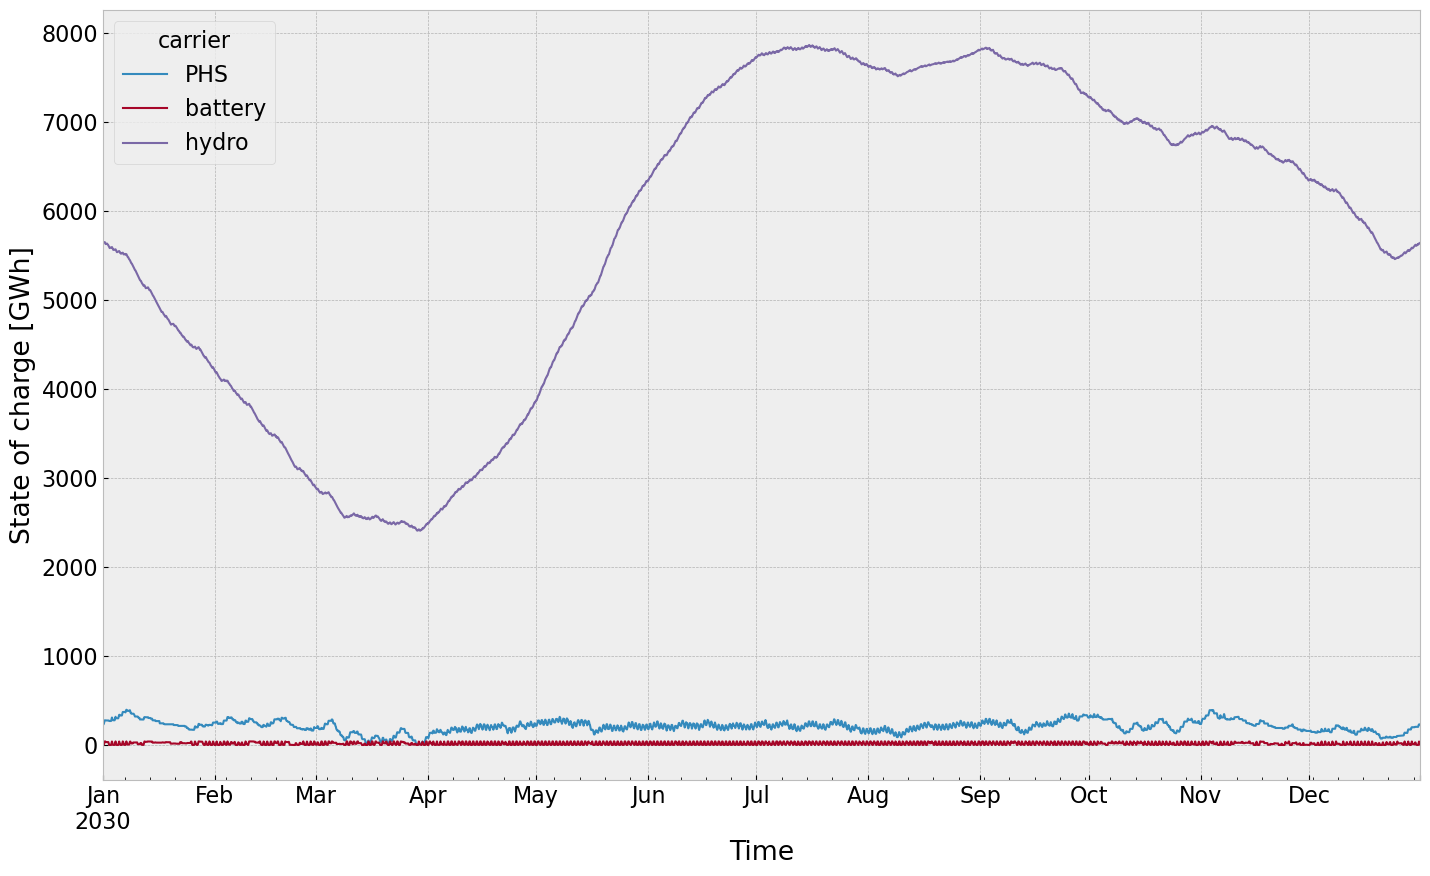

In [35]:
state_of_charge_plot(n)

## Electricity Price

In [36]:
def price_dur_curve_plot(n):

    #buses without store
    columns_to_keep =[]

    for i in n.buses_t.marginal_price.columns.tolist():
        if not i.endswith('H2'):
            columns_to_keep.append(i)
    
    price_dur_curve = pd.DataFrame()
    for region in columns_to_keep:
        price_dur_curve[region] = n.buses_t.marginal_price[region].sort_values(ascending=False).reset_index(drop=True)

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(17,10))

    price_dur_curve.plot(ax=ax,
                    grid=True,
                    ylabel="Marginal price [€/MWh]",
                    xlabel="Time steps",
                    #title=f"Duration curves of the marginal price in the Italian regions in {year}",
                    linewidth=3,
)

plt.show()

In [37]:
columns_to_keep =[]

for i in n.buses_t.marginal_price.columns.tolist():
    if not i.endswith('H2'):
        columns_to_keep.append(i)
    


#buses without store
columns_to_keep =[]

price_dur_curve = pd.DataFrame()
for region in columns_to_keep:
    price_dur_curve[region] = n.buses_t.marginal_price[region].sort_values(ascending=False).reset_index(drop=True)


In [38]:
n.buses_t.marginal_price['IT1 0'].sort_values(ascending=False).head(20)

snapshot
2013-11-22 15:00:00    77.651101
2013-02-18 21:00:00    77.651101
2013-11-21 21:00:00    77.651101
2013-11-21 18:00:00    77.651101
2013-02-11 21:00:00    77.651101
2013-11-21 15:00:00    77.651101
2013-01-07 15:00:00    77.651101
2013-01-08 21:00:00    77.651101
2013-01-19 18:00:00    77.651101
2013-01-10 03:00:00    77.651101
2013-01-10 06:00:00    77.651101
2013-02-12 21:00:00    77.651101
2013-02-22 21:00:00    77.651101
2013-02-21 21:00:00    77.651101
2013-01-09 21:00:00    77.651101
2013-11-28 18:00:00    77.651101
2013-11-28 21:00:00    77.651101
2013-12-02 21:00:00    77.651101
2013-12-03 15:00:00    77.651101
2013-12-03 18:00:00    77.651101
Name: IT1 0, dtype: float64

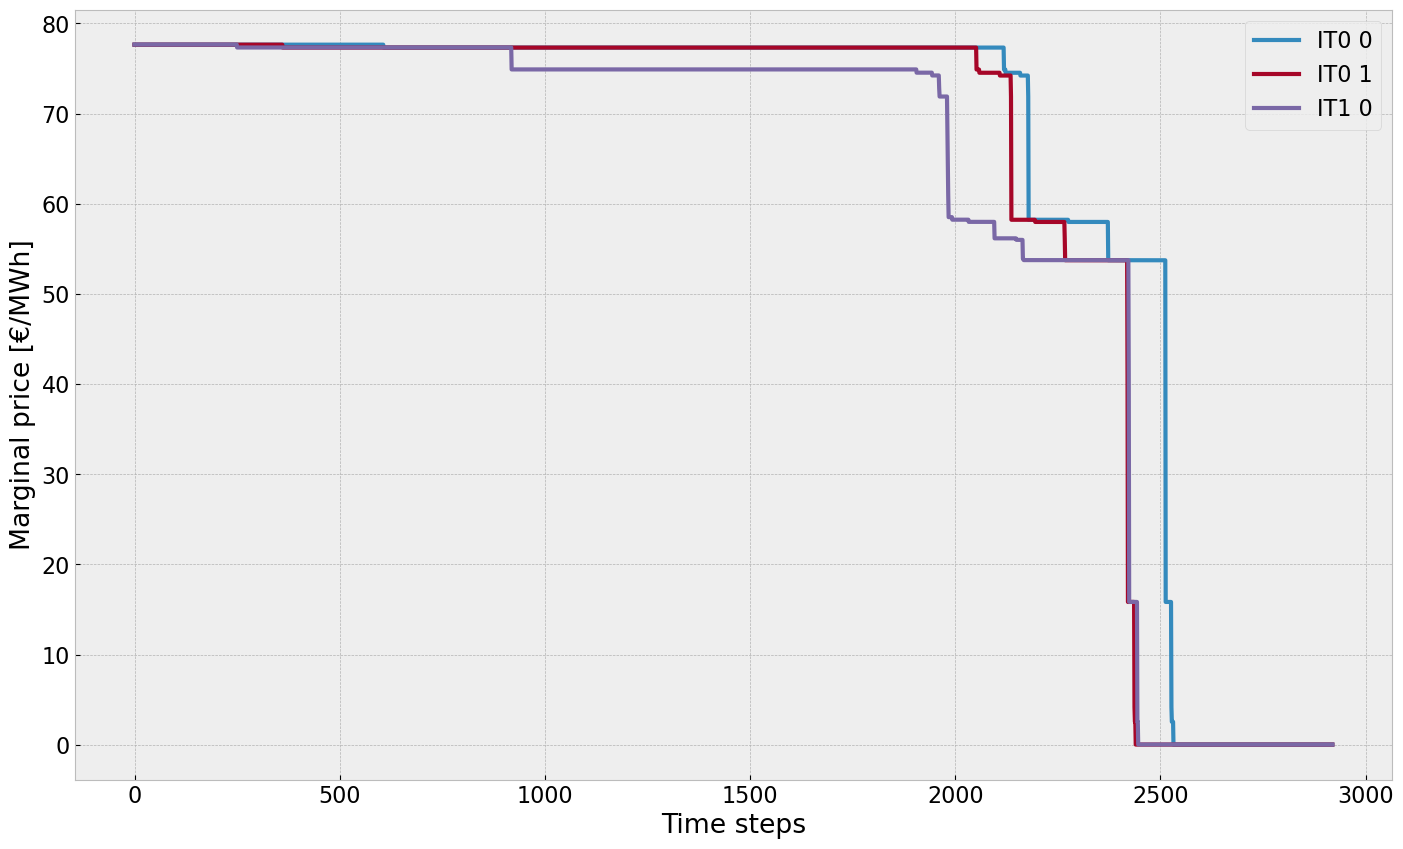

In [39]:
price_dur_curve_plot(n)

In [40]:
def price_regions_table(n):

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(17,10))

    
    region = n.buses_t.marginal_price.mean()
    #for index, value in region.items():
    #    if index.endswith('H2'):
     #       region = region.drop(index)
    
    region.plot.bar(ax=ax,
                    grid=True,
                    ylabel="Marginal price [€/MWh]",
                    xlabel="Region",
                    title=f"Average marginal price",
                    linewidth=3,
    
    )

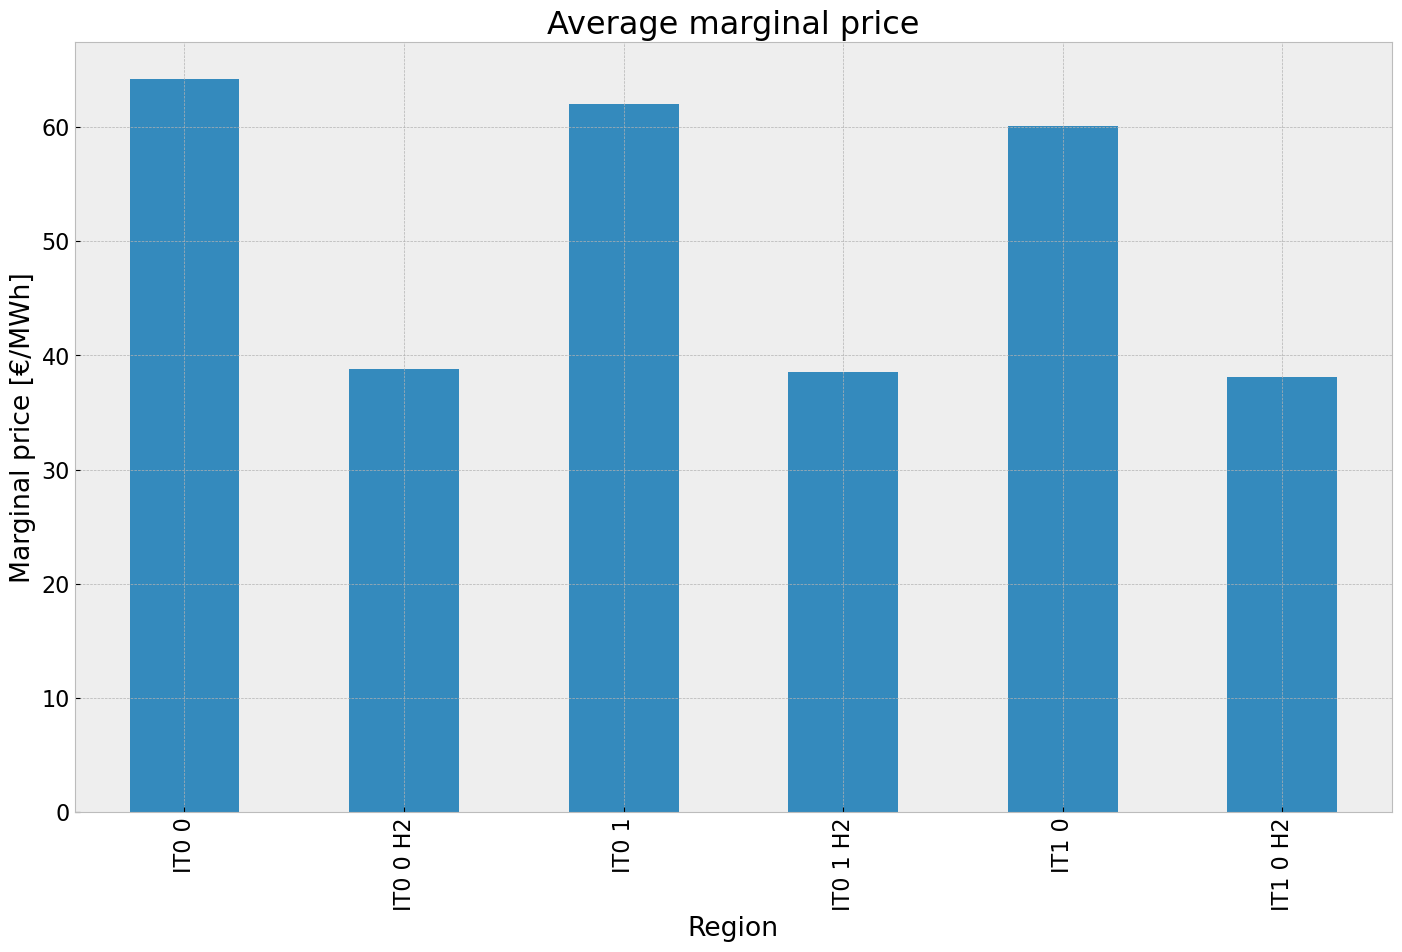

In [41]:
price_regions_table(n)

In [42]:
def price_regions(n):
    # Assuming 'n.buses_t.marginal_price' returns a DataFrame or similar structure with 'mean()' method
    mean_p = n.buses_t.marginal_price.mean()

    hprice = mean_p.filter(like='H2')
    eprice = mean_p.drop(hprice.index)

    # Setup figure and subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(16, 8))
    
    # Plot for hprice
    hprice_plot = axs[0].hexbin(
        n.buses.x.filter(like='H2'),  # Assuming n.buses.x and n.buses.y hold the coordinates
        n.buses.y.filter(like='H2'),
        gridsize=20,
        C=hprice,
        cmap=plt.cm.jet,
        zorder=3,
    )
    n.plot(ax=axs[0], line_widths=pd.Series(0.5, n.lines.index), bus_sizes=0)  # Plot network on the first subplot
    cb = fig.colorbar(hprice_plot, ax=axs[0], location="bottom")
    cb.set_label("Locational Marginal Price (EUR/MWh) for H2")

    # Plot for eprice
    eprice_plot = axs[1].hexbin(
        n.buses.x[~n.buses.x.index.str.contains('H2')],
        n.buses.y[~n.buses.x.index.str.contains('H2')],
        gridsize=20,
        C=eprice,
        cmap=plt.cm.jet,
        zorder=3,
    )
    n.plot(ax=axs[1], line_widths=pd.Series(0.5, n.lines.index), bus_sizes=0)  # Plot network on the second subplot
    cb = fig.colorbar(eprice_plot, ax=axs[1], location="bottom")
    cb.set_label("Locational Marginal Price (EUR/MWh) for Electricity")

    fig.tight_layout()

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


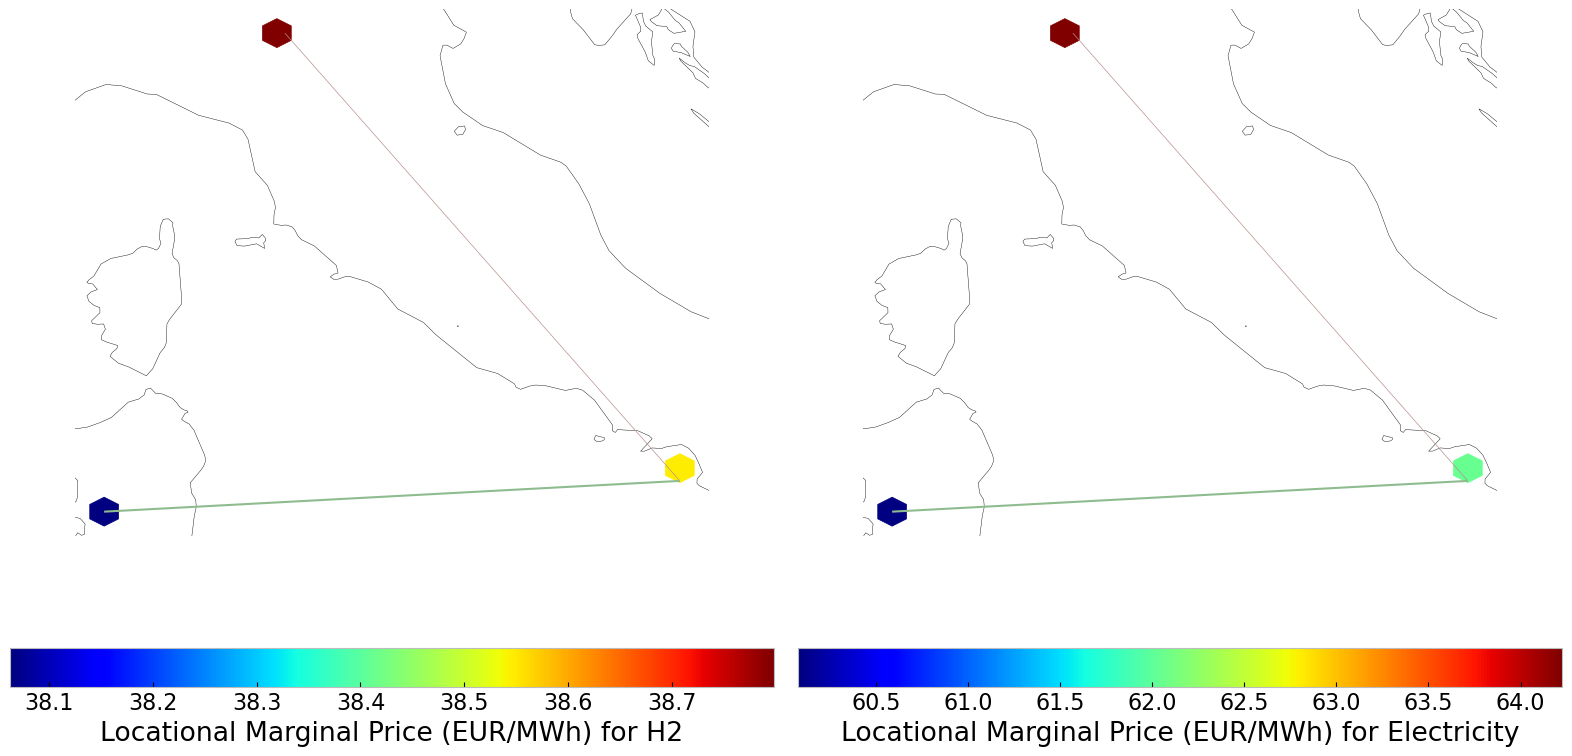

In [43]:
price_regions(n)

# Volcano Erruption Scenario
eruption start: 01.06.2013
reduction on radiation: 10%, source:
duration : until year end

In [44]:
#copy network
n1=n.copy()

#p_max_pu of solar generators across all regions are subtracted by 10% from 01.06.2013 to 31.12.13
eruption_start=pd.to_datetime('2013-06-01 00:00:00')
for column in n1.generators_t.p_max_pu.columns:
        if column.endswith('solar'):
                for index,row in n1.generators_t.p_max_pu[column].items():
                        if index >= eruption_start:
                                new_p_max_pu = n1.generators_t.p_max_pu.at[index, column] * 0.1 #0.9
                                n1.generators_t.p_max_pu.at[index, column] = new_p_max_pu
                                if new_p_max_pu<0:
                                    n1.generators_t.p_max_pu.at[index, column] = 0


#set the optimal capacity of generators from the base scenario as the new minimum capacity 
for index, value in n1.generators.p_nom_extendable.items():
    if value:  
        n1.generators.at[index, 'p_nom_min'] = n.generators.at[index, 'p_nom_opt']


#set the optimal capacity of storage units from the base scenario as the new minimum capacity 
for index, value in n1.storage_units.p_nom_extendable.items():
    if value:  
        n1.storage_units.at[index, 'p_nom_min'] = n.storage_units.at[index, 'p_nom_opt']

#set the optimal capacity of lines from the base scenario as the new minimum capacity 
for index, value in n1.lines.s_nom_extendable.items():
    if value:  
        n1.lines.at[index, 's_nom_min'] = n.lines.at[index, 's_nom_opt']

                        

In [45]:
n1.generators_t.p_max_pu.sum()

Generator
IT0 0 offwind-ac     487.384979
IT0 0 offwind-dc     604.391882
IT0 0 onwind         142.342859
IT0 0 ror           1398.010907
IT0 0 solar          174.125273
IT0 1 offwind-ac     540.778674
IT0 1 offwind-dc     858.589210
IT0 1 onwind         299.740456
IT0 1 ror           1398.010907
IT0 1 solar          208.232957
IT1 0 offwind-ac     811.941052
IT1 0 onwind         565.816181
IT1 0 ror           1398.010907
IT1 0 solar          202.156162
dtype: float64

## 1. Scenario: allow additional investment of extendable generators and storage

In [46]:
n1.optimize.create_model()


Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * StorageUnit-p_nom (StorageUnit-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * StorageUnit-spill (snapshot, StorageUnit)
 * Store-p (snapshot, Store)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * StorageUnit-ext-p_nom-lower (StorageUnit-ext)
 * StorageUnit-ext-p_nom-upper (StorageUnit-ext)
 * Generator-

In [47]:
#solve network

n1.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 15/15 [00:00<00:00, 15.54it/s]
INFO:linopy.io: Writing time: 6.48s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ngtautkj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ngtautkj.lp


Reading time = 2.14 seconds


INFO:gurobipy:Reading time = 2.14 seconds


obj: 531483 rows, 256950 columns, 997219 nonzeros


INFO:gurobipy:obj: 531483 rows, 256950 columns, 997219 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 531483 rows, 256950 columns and 997219 nonzeros


INFO:gurobipy:Optimize a model with 531483 rows, 256950 columns and 997219 nonzeros


Model fingerprint: 0xe15d2a1c


INFO:gurobipy:Model fingerprint: 0xe15d2a1c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+00, 2e+09]


INFO:gurobipy:  Bounds range     [4e+00, 2e+09]


  RHS range        [3e+00, 1e+09]


INFO:gurobipy:  RHS range        [3e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 389859 rows and 62818 columns


INFO:gurobipy:Presolve removed 389859 rows and 62818 columns


Presolve time: 0.69s


INFO:gurobipy:Presolve time: 0.69s


Presolved: 141624 rows, 194132 columns, 515343 nonzeros


INFO:gurobipy:Presolved: 141624 rows, 194132 columns, 515343 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.17s


INFO:gurobipy:Ordering time: 0.17s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 28


INFO:gurobipy: Dense cols : 28


 AA' NZ     : 3.592e+05


INFO:gurobipy: AA' NZ     : 3.592e+05


 Factor NZ  : 2.304e+06 (roughly 150 MB of memory)


INFO:gurobipy: Factor NZ  : 2.304e+06 (roughly 150 MB of memory)


 Factor Ops : 6.743e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.743e+07 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.40670416e+19 -1.02706368e+20  2.72e+13 2.06e+06  3.99e+15     1s


INFO:gurobipy:   0   2.40670416e+19 -1.02706368e+20  2.72e+13 2.06e+06  3.99e+15     1s


   1   1.67686297e+19 -3.19200823e+19  2.02e+13 5.68e+05  2.14e+15     1s


INFO:gurobipy:   1   1.67686297e+19 -3.19200823e+19  2.02e+13 5.68e+05  2.14e+15     1s


   2   1.22699558e+19 -1.60954392e+19  1.44e+13 1.67e+05  1.49e+15     2s


INFO:gurobipy:   2   1.22699558e+19 -1.60954392e+19  1.44e+13 1.67e+05  1.49e+15     2s


   3   2.07772602e+18 -3.66715775e+18  2.29e+12 1.74e+04  2.35e+14     2s


INFO:gurobipy:   3   2.07772602e+18 -3.66715775e+18  2.29e+12 1.74e+04  2.35e+14     2s


   4   6.50997248e+17 -8.24957721e+17  6.73e+11 2.90e+03  6.72e+13     2s


INFO:gurobipy:   4   6.50997248e+17 -8.24957721e+17  6.73e+11 2.90e+03  6.72e+13     2s


   5   1.91053153e+17 -2.50082633e+17  1.48e+11 4.47e+02  1.50e+13     2s


INFO:gurobipy:   5   1.91053153e+17 -2.50082633e+17  1.48e+11 4.47e+02  1.50e+13     2s


   6   4.28077169e+16 -8.44890767e+16  1.64e+09 6.23e+01  4.96e+11     3s


INFO:gurobipy:   6   4.28077169e+16 -8.44890767e+16  1.64e+09 6.23e+01  4.96e+11     3s


   7   1.25986578e+16 -1.96776203e+16  2.75e+08 1.43e+01  1.07e+11     3s


INFO:gurobipy:   7   1.25986578e+16 -1.96776203e+16  2.75e+08 1.43e+01  1.07e+11     3s


   8   2.46719623e+15 -4.63675605e+15  3.82e+07 2.40e+00  2.05e+10     3s


INFO:gurobipy:   8   2.46719623e+15 -4.63675605e+15  3.82e+07 2.40e+00  2.05e+10     3s


   9   1.49159706e+14 -5.92752854e+14  1.09e+06 1.89e-01  1.87e+09     3s


INFO:gurobipy:   9   1.49159706e+14 -5.92752854e+14  1.09e+06 1.89e-01  1.87e+09     3s


  10   5.60315198e+12 -7.54468257e+13  6.23e+03 2.22e-02  1.99e+08     3s


INFO:gurobipy:  10   5.60315198e+12 -7.54468257e+13  6.23e+03 2.22e-02  1.99e+08     3s


  11   1.83713697e+12 -2.15356924e+13  2.18e+00 6.19e-03  5.70e+07     4s


INFO:gurobipy:  11   1.83713697e+12 -2.15356924e+13  2.18e+00 6.19e-03  5.70e+07     4s


  12   7.71506322e+11 -5.52110131e+12  6.10e-01 1.54e-03  1.53e+07     4s


INFO:gurobipy:  12   7.71506322e+11 -5.52110131e+12  6.10e-01 1.54e-03  1.53e+07     4s


  13   4.63567115e+11 -2.34644567e+12  3.06e-01 6.49e-04  6.81e+06     4s


INFO:gurobipy:  13   4.63567115e+11 -2.34644567e+12  3.06e-01 6.49e-04  6.81e+06     4s


  14   2.76701887e+11 -1.05002766e+12  1.48e-01 2.98e-04  3.21e+06     4s


INFO:gurobipy:  14   2.76701887e+11 -1.05002766e+12  1.48e-01 2.98e-04  3.21e+06     4s


  15   1.88920376e+11 -7.99429744e+11  9.02e-02 2.27e-04  2.39e+06     4s


INFO:gurobipy:  15   1.88920376e+11 -7.99429744e+11  9.02e-02 2.27e-04  2.39e+06     4s


  16   1.01402478e+11 -2.74206011e+11  3.71e-02 7.68e-05  9.09e+05     5s


INFO:gurobipy:  16   1.01402478e+11 -2.74206011e+11  3.71e-02 7.68e-05  9.09e+05     5s


  17   6.51820317e+10 -5.53784045e+10  1.88e-02 1.75e-05  2.92e+05     5s


INFO:gurobipy:  17   6.51820317e+10 -5.53784045e+10  1.88e-02 1.75e-05  2.92e+05     5s


  18   4.80703265e+10 -2.30060227e+10  1.13e-02 9.67e-06  1.72e+05     5s


INFO:gurobipy:  18   4.80703265e+10 -2.30060227e+10  1.13e-02 9.67e-06  1.72e+05     5s


  19   3.74355051e+10 -9.96913323e+09  6.77e-03 6.66e-06  1.15e+05     5s


INFO:gurobipy:  19   3.74355051e+10 -9.96913323e+09  6.77e-03 6.66e-06  1.15e+05     5s


  20   3.22211449e+10 -1.66879147e+09  4.68e-03 4.81e-06  8.20e+04     5s


INFO:gurobipy:  20   3.22211449e+10 -1.66879147e+09  4.68e-03 4.81e-06  8.20e+04     5s


  21   2.89928030e+10  5.32631609e+09  3.43e-03 3.23e-06  5.73e+04     6s


INFO:gurobipy:  21   2.89928030e+10  5.32631609e+09  3.43e-03 3.23e-06  5.73e+04     6s


  22   2.65086894e+10  1.21351097e+10  2.49e-03 1.70e-06  3.48e+04     6s


INFO:gurobipy:  22   2.65086894e+10  1.21351097e+10  2.49e-03 1.70e-06  3.48e+04     6s


  23   2.53072396e+10  1.34822441e+10  2.07e-03 1.36e-06  2.86e+04     6s


INFO:gurobipy:  23   2.53072396e+10  1.34822441e+10  2.07e-03 1.36e-06  2.86e+04     6s


  24   2.37619480e+10  1.48505783e+10  1.54e-03 1.03e-06  2.16e+04     6s


INFO:gurobipy:  24   2.37619480e+10  1.48505783e+10  1.54e-03 1.03e-06  2.16e+04     6s


  25   2.25558366e+10  1.64730899e+10  1.11e-03 6.47e-07  1.47e+04     6s


INFO:gurobipy:  25   2.25558366e+10  1.64730899e+10  1.11e-03 6.47e-07  1.47e+04     6s


  26   2.13996581e+10  1.71136737e+10  7.14e-04 5.02e-07  1.04e+04     7s


INFO:gurobipy:  26   2.13996581e+10  1.71136737e+10  7.14e-04 5.02e-07  1.04e+04     7s


  27   2.09983931e+10  1.76187359e+10  5.76e-04 3.84e-07  8.18e+03     7s


INFO:gurobipy:  27   2.09983931e+10  1.76187359e+10  5.76e-04 3.84e-07  8.18e+03     7s


  28   2.06174288e+10  1.80383036e+10  4.47e-04 2.86e-07  6.24e+03     7s


INFO:gurobipy:  28   2.06174288e+10  1.80383036e+10  4.47e-04 2.86e-07  6.24e+03     7s


  29   2.03528192e+10  1.83299564e+10  3.60e-04 2.18e-07  4.90e+03     8s


INFO:gurobipy:  29   2.03528192e+10  1.83299564e+10  3.60e-04 2.18e-07  4.90e+03     8s


  30   2.01266756e+10  1.84729022e+10  2.84e-04 1.84e-07  4.00e+03     8s


INFO:gurobipy:  30   2.01266756e+10  1.84729022e+10  2.84e-04 1.84e-07  4.00e+03     8s


  31   1.99412807e+10  1.86314794e+10  2.22e-04 1.47e-07  3.17e+03     8s


INFO:gurobipy:  31   1.99412807e+10  1.86314794e+10  2.22e-04 1.47e-07  3.17e+03     8s


  32   1.97951732e+10  1.87998830e+10  1.74e-04 1.06e-07  2.41e+03     8s


INFO:gurobipy:  32   1.97951732e+10  1.87998830e+10  1.74e-04 1.06e-07  2.41e+03     8s


  33   1.97049034e+10  1.89071623e+10  1.45e-04 8.05e-08  1.93e+03     9s


INFO:gurobipy:  33   1.97049034e+10  1.89071623e+10  1.45e-04 8.05e-08  1.93e+03     9s


  34   1.95879146e+10  1.89705930e+10  1.08e-04 6.50e-08  1.49e+03     9s


INFO:gurobipy:  34   1.95879146e+10  1.89705930e+10  1.08e-04 6.50e-08  1.49e+03     9s


  35   1.95361888e+10  1.90584195e+10  8.97e-05 4.49e-08  1.16e+03    10s


INFO:gurobipy:  35   1.95361888e+10  1.90584195e+10  8.97e-05 4.49e-08  1.16e+03    10s


  36   1.94806569e+10  1.90894903e+10  7.18e-05 3.75e-08  9.47e+02    10s


INFO:gurobipy:  36   1.94806569e+10  1.90894903e+10  7.18e-05 3.75e-08  9.47e+02    10s


  37   1.94398793e+10  1.91452966e+10  5.86e-05 2.48e-08  7.13e+02    10s


INFO:gurobipy:  37   1.94398793e+10  1.91452966e+10  5.86e-05 2.48e-08  7.13e+02    10s


  38   1.94081128e+10  1.91610089e+10  4.89e-05 2.12e-08  5.98e+02    10s


INFO:gurobipy:  38   1.94081128e+10  1.91610089e+10  4.89e-05 2.12e-08  5.98e+02    10s


  39   1.93882103e+10  1.91732782e+10  4.27e-05 1.84e-08  5.20e+02    11s


INFO:gurobipy:  39   1.93882103e+10  1.91732782e+10  4.27e-05 1.84e-08  5.20e+02    11s


  40   1.93703229e+10  1.91839848e+10  3.71e-05 1.60e-08  4.51e+02    11s


INFO:gurobipy:  40   1.93703229e+10  1.91839848e+10  3.71e-05 1.60e-08  4.51e+02    11s


  41   1.93604301e+10  1.91973054e+10  3.41e-05 1.29e-08  3.95e+02    11s


INFO:gurobipy:  41   1.93604301e+10  1.91973054e+10  3.41e-05 1.29e-08  3.95e+02    11s


  42   1.93452114e+10  1.92027774e+10  3.05e-05 1.17e-08  3.45e+02    12s


INFO:gurobipy:  42   1.93452114e+10  1.92027774e+10  3.05e-05 1.17e-08  3.45e+02    12s


  43   1.93324720e+10  1.92081218e+10  2.62e-05 1.04e-08  3.01e+02    12s


INFO:gurobipy:  43   1.93324720e+10  1.92081218e+10  2.62e-05 1.04e-08  3.01e+02    12s


  44   1.93311639e+10  1.92099234e+10  2.57e-05 1.00e-08  2.93e+02    12s


INFO:gurobipy:  44   1.93311639e+10  1.92099234e+10  2.57e-05 1.00e-08  2.93e+02    12s


  45   1.93288490e+10  1.92114737e+10  2.49e-05 9.64e-09  2.84e+02    12s


INFO:gurobipy:  45   1.93288490e+10  1.92114737e+10  2.49e-05 9.64e-09  2.84e+02    12s


  46   1.93096278e+10  1.92199008e+10  1.97e-05 7.69e-09  2.17e+02    13s


INFO:gurobipy:  46   1.93096278e+10  1.92199008e+10  1.97e-05 7.69e-09  2.17e+02    13s


  47   1.93020262e+10  1.92238156e+10  1.73e-05 6.82e-09  1.89e+02    13s


INFO:gurobipy:  47   1.93020262e+10  1.92238156e+10  1.73e-05 6.82e-09  1.89e+02    13s


  48   1.92891072e+10  1.92329798e+10  1.27e-05 4.63e-09  1.36e+02    13s


INFO:gurobipy:  48   1.92891072e+10  1.92329798e+10  1.27e-05 4.63e-09  1.36e+02    13s


  49   1.92806406e+10  1.92380741e+10  9.32e-06 3.47e-09  1.03e+02    14s


INFO:gurobipy:  49   1.92806406e+10  1.92380741e+10  9.32e-06 3.47e-09  1.03e+02    14s


  50   1.92754524e+10  1.92413062e+10  7.29e-06 2.74e-09  8.27e+01    14s


INFO:gurobipy:  50   1.92754524e+10  1.92413062e+10  7.29e-06 2.74e-09  8.27e+01    14s


  51   1.92751147e+10  1.92417291e+10  7.17e-06 2.65e-09  8.08e+01    14s


INFO:gurobipy:  51   1.92751147e+10  1.92417291e+10  7.17e-06 2.65e-09  8.08e+01    14s


  52   1.92727101e+10  1.92430059e+10  6.32e-06 2.38e-09  7.19e+01    15s


INFO:gurobipy:  52   1.92727101e+10  1.92430059e+10  6.32e-06 2.38e-09  7.19e+01    15s


  53   1.92701148e+10  1.92452576e+10  5.41e-06 1.90e-09  6.02e+01    15s


INFO:gurobipy:  53   1.92701148e+10  1.92452576e+10  5.41e-06 1.90e-09  6.02e+01    15s


  54   1.92695481e+10  1.92459274e+10  5.30e-06 1.75e-09  5.72e+01    15s


INFO:gurobipy:  54   1.92695481e+10  1.92459274e+10  5.30e-06 1.75e-09  5.72e+01    15s


  55   1.92678271e+10  1.92486965e+10  4.65e-06 1.16e-09  4.63e+01    16s


INFO:gurobipy:  55   1.92678271e+10  1.92486965e+10  4.65e-06 1.16e-09  4.63e+01    16s


  56   1.92630470e+10  1.92502280e+10  2.99e-06 9.07e-10  3.10e+01    16s


INFO:gurobipy:  56   1.92630470e+10  1.92502280e+10  2.99e-06 9.07e-10  3.10e+01    16s


  57   1.92599298e+10  1.92522275e+10  1.92e-06 8.21e-10  1.86e+01    16s


INFO:gurobipy:  57   1.92599298e+10  1.92522275e+10  1.92e-06 8.21e-10  1.86e+01    16s


  58   1.92593829e+10  1.92527750e+10  1.73e-06 9.92e-10  1.60e+01    17s


INFO:gurobipy:  58   1.92593829e+10  1.92527750e+10  1.73e-06 9.92e-10  1.60e+01    17s


  59   1.92579877e+10  1.92532121e+10  1.65e-06 9.48e-10  1.16e+01    17s


INFO:gurobipy:  59   1.92579877e+10  1.92532121e+10  1.65e-06 9.48e-10  1.16e+01    17s


  60   1.92564530e+10  1.92538981e+10  9.86e-07 9.85e-10  6.18e+00    17s


INFO:gurobipy:  60   1.92564530e+10  1.92538981e+10  9.86e-07 9.85e-10  6.18e+00    17s


  61   1.92560525e+10  1.92539485e+10  8.02e-07 1.06e-09  5.09e+00    17s


INFO:gurobipy:  61   1.92560525e+10  1.92539485e+10  8.02e-07 1.06e-09  5.09e+00    17s


  62   1.92553260e+10  1.92540286e+10  4.69e-07 1.77e-09  3.14e+00    17s


INFO:gurobipy:  62   1.92553260e+10  1.92540286e+10  4.69e-07 1.77e-09  3.14e+00    17s


  63   1.92546689e+10  1.92541628e+10  1.77e-07 1.78e-09  1.22e+00    18s


INFO:gurobipy:  63   1.92546689e+10  1.92541628e+10  1.77e-07 1.78e-09  1.22e+00    18s


  64   1.92544759e+10  1.92542055e+10  9.40e-08 2.32e-09  6.55e-01    18s


INFO:gurobipy:  64   1.92544759e+10  1.92542055e+10  9.40e-08 2.32e-09  6.55e-01    18s


  65   1.92543645e+10  1.92542188e+10  4.58e-08 2.06e-09  3.53e-01    18s


INFO:gurobipy:  65   1.92543645e+10  1.92542188e+10  4.58e-08 2.06e-09  3.53e-01    18s


  66   1.92543106e+10  1.92542354e+10  2.24e-08 2.13e-09  1.82e-01    18s


INFO:gurobipy:  66   1.92543106e+10  1.92542354e+10  2.24e-08 2.13e-09  1.82e-01    18s


  67   1.92542971e+10  1.92542469e+10  1.68e-08 1.51e-09  1.21e-01    18s


INFO:gurobipy:  67   1.92542971e+10  1.92542469e+10  1.68e-08 1.51e-09  1.21e-01    18s


  68   1.92542712e+10  1.92542535e+10  5.95e-09 1.05e-09  4.27e-02    19s


INFO:gurobipy:  68   1.92542712e+10  1.92542535e+10  5.95e-09 1.05e-09  4.27e-02    19s


  69   1.92542585e+10  1.92542556e+10  8.75e-10 1.14e-09  7.12e-03    19s


INFO:gurobipy:  69   1.92542585e+10  1.92542556e+10  8.75e-10 1.14e-09  7.12e-03    19s


  70   1.92542565e+10  1.92542563e+10  7.56e-10 1.04e-09  6.64e-04    19s


INFO:gurobipy:  70   1.92542565e+10  1.92542563e+10  7.56e-10 1.04e-09  6.64e-04    19s


  71   1.92542563e+10  1.92542563e+10  6.99e-06 1.40e-09  1.08e-06    19s


INFO:gurobipy:  71   1.92542563e+10  1.92542563e+10  6.99e-06 1.40e-09  1.08e-06    19s


  72   1.92542563e+10  1.92542563e+10  3.17e-09 1.40e-09  1.39e-10    19s


INFO:gurobipy:  72   1.92542563e+10  1.92542563e+10  3.17e-09 1.40e-09  1.39e-10    19s


INFO:gurobipy:


Barrier solved model in 72 iterations and 19.38 seconds (6.96 work units)


INFO:gurobipy:Barrier solved model in 72 iterations and 19.38 seconds (6.96 work units)


Optimal objective 1.92542563e+10


INFO:gurobipy:Optimal objective 1.92542563e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   62190 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:   62190 DPushes remaining with DInf 0.0000000e+00                20s


       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   18534 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:   18534 PPushes remaining with PInf 0.0000000e+00                20s


   17197 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:   17197 PPushes remaining with PInf 0.0000000e+00                20s


       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.6107841e-10     24s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.6107841e-10     24s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   51624    1.9254256e+10   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:   51624    1.9254256e+10   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:


Solved in 51624 iterations and 24.28 seconds (11.16 work units)


INFO:gurobipy:Solved in 51624 iterations and 24.28 seconds (11.16 work units)


Optimal objective  1.925425633e+10


INFO:gurobipy:Optimal objective  1.925425633e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 256950 primals, 531483 duals
Objective: 1.93e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper,

('ok', 'optimal')

In [48]:
tot_cos_inv=n1.objective/1e9 # billion €
system_cost_inv = system_cost(n1) #million€/a
marg_price_region_inv = n1.buses_t.marginal_price.mean()
stat_inv = n1.statistics()

## Installed Capacity

<Figure size 640x480 with 0 Axes>

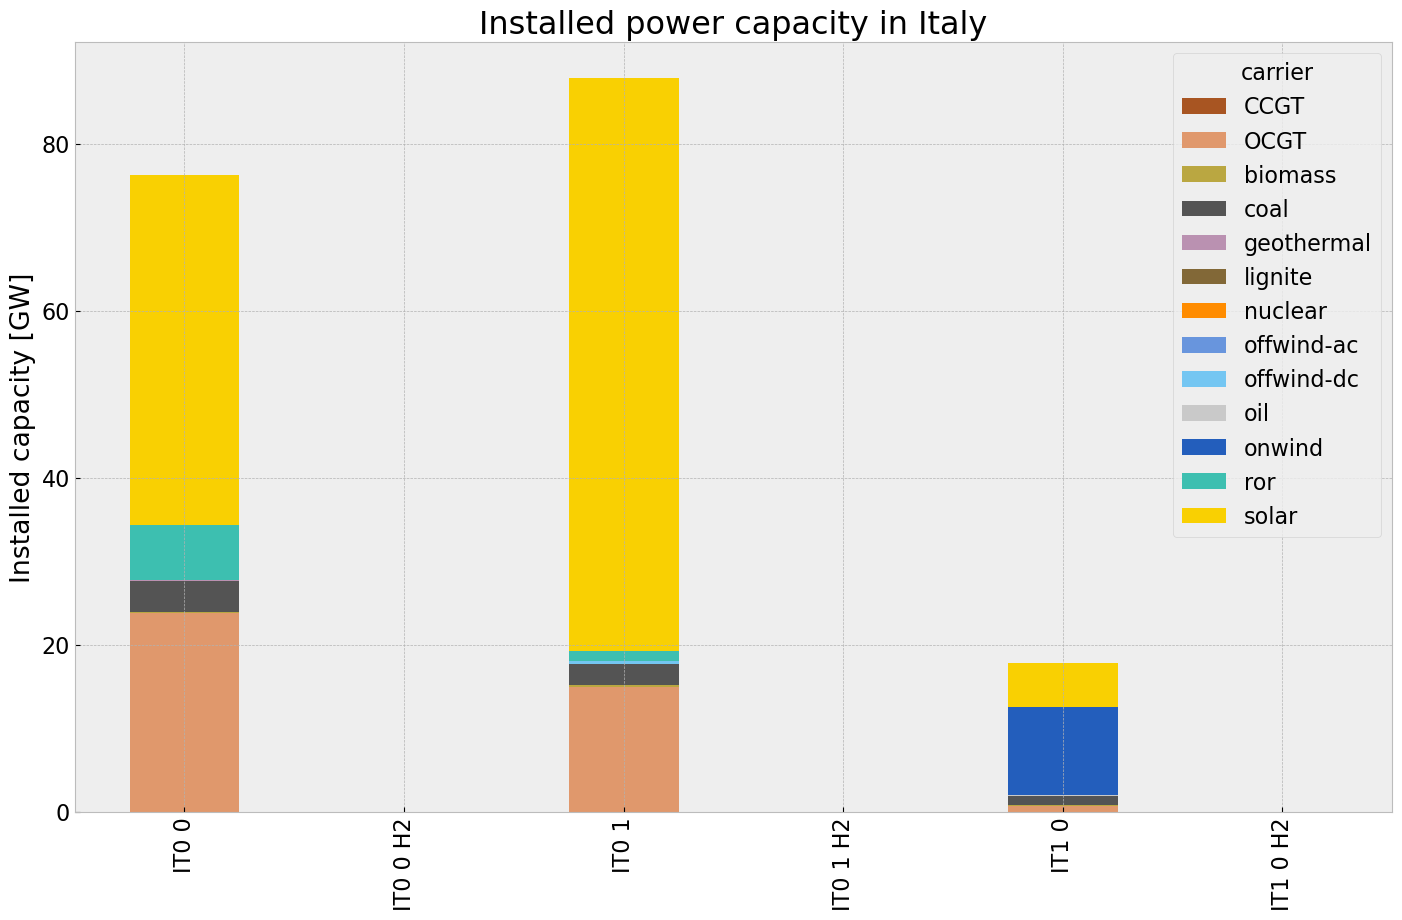

In [49]:
# consolidated istalled cap without load_shedding

capacities_inv = n1.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
capacities_inv.fillna(0, inplace=True)
gen_1 = (capacities_inv.unstack()/1000).drop(columns=['load'],inplace=False)


cap_inv = inst_cap_table(n1, color_cap)


## Generation

<Figure size 640x480 with 0 Axes>

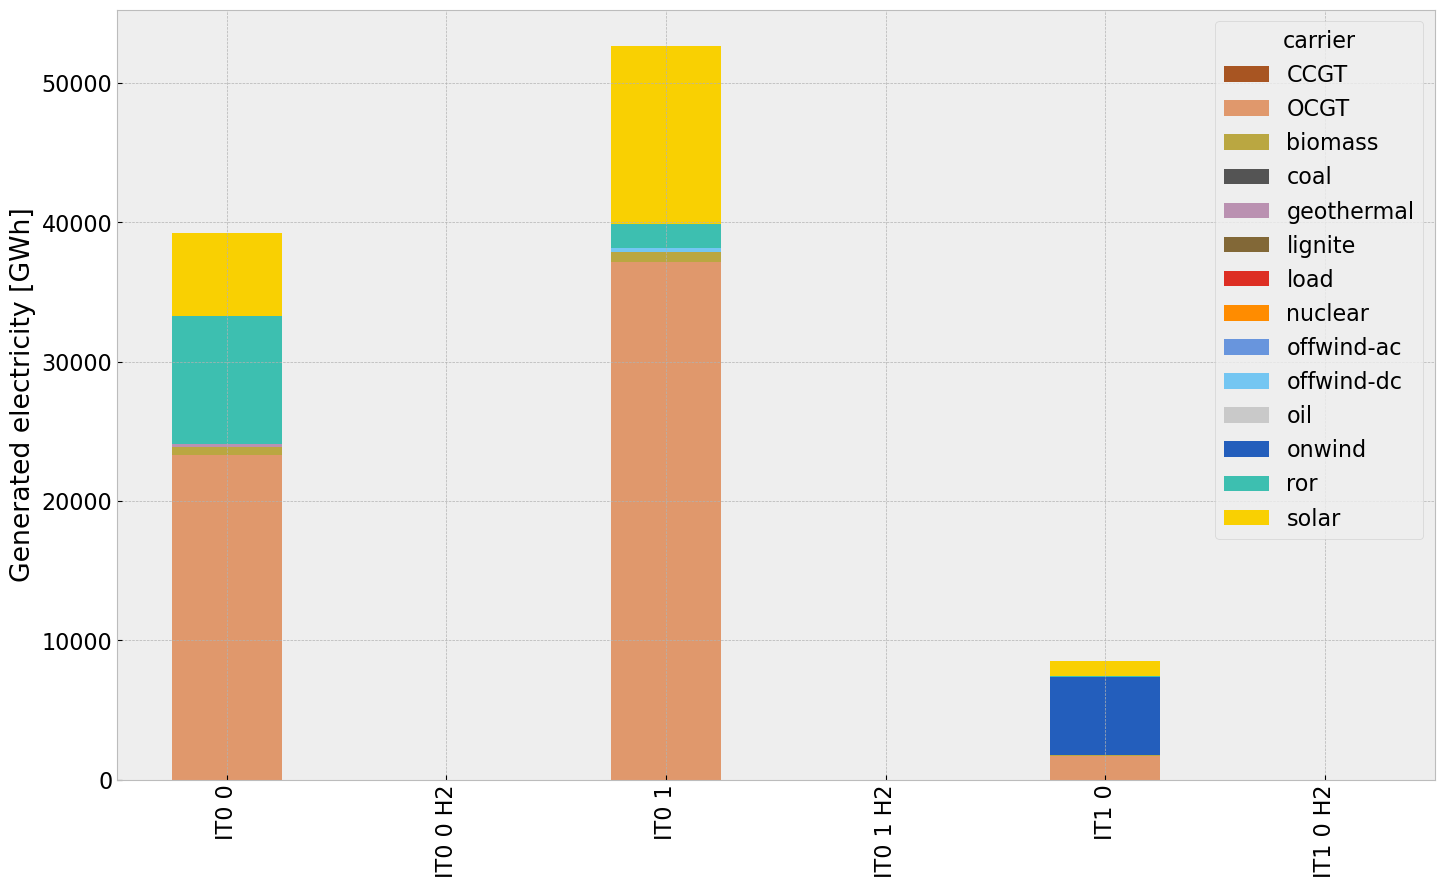

In [50]:
# consolidated generation table
carrier = n1.generators.carrier.unique()
df_tot_generation = n1.generators_t.p.sum()

generations = pd.Series(index = n1.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

for r in region:
    for tech in carrier:
        key = f"{r} {tech}"
        if key in df_tot_generation.index:
            try:
                generations.loc[r, tech] = df_tot_generation[key]
                #print(generations.loc[r, tech])
            except KeyError:
                print('error')
                
generations.fillna(0, inplace=True)
gen_inv = generations.unstack()/1000#Gwh


gen_inv = gen_power_table(n1,colors_gen_table)



## Snapshot

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  p_by_carrier.index = pd.date_range(start='2030-01-01', end=

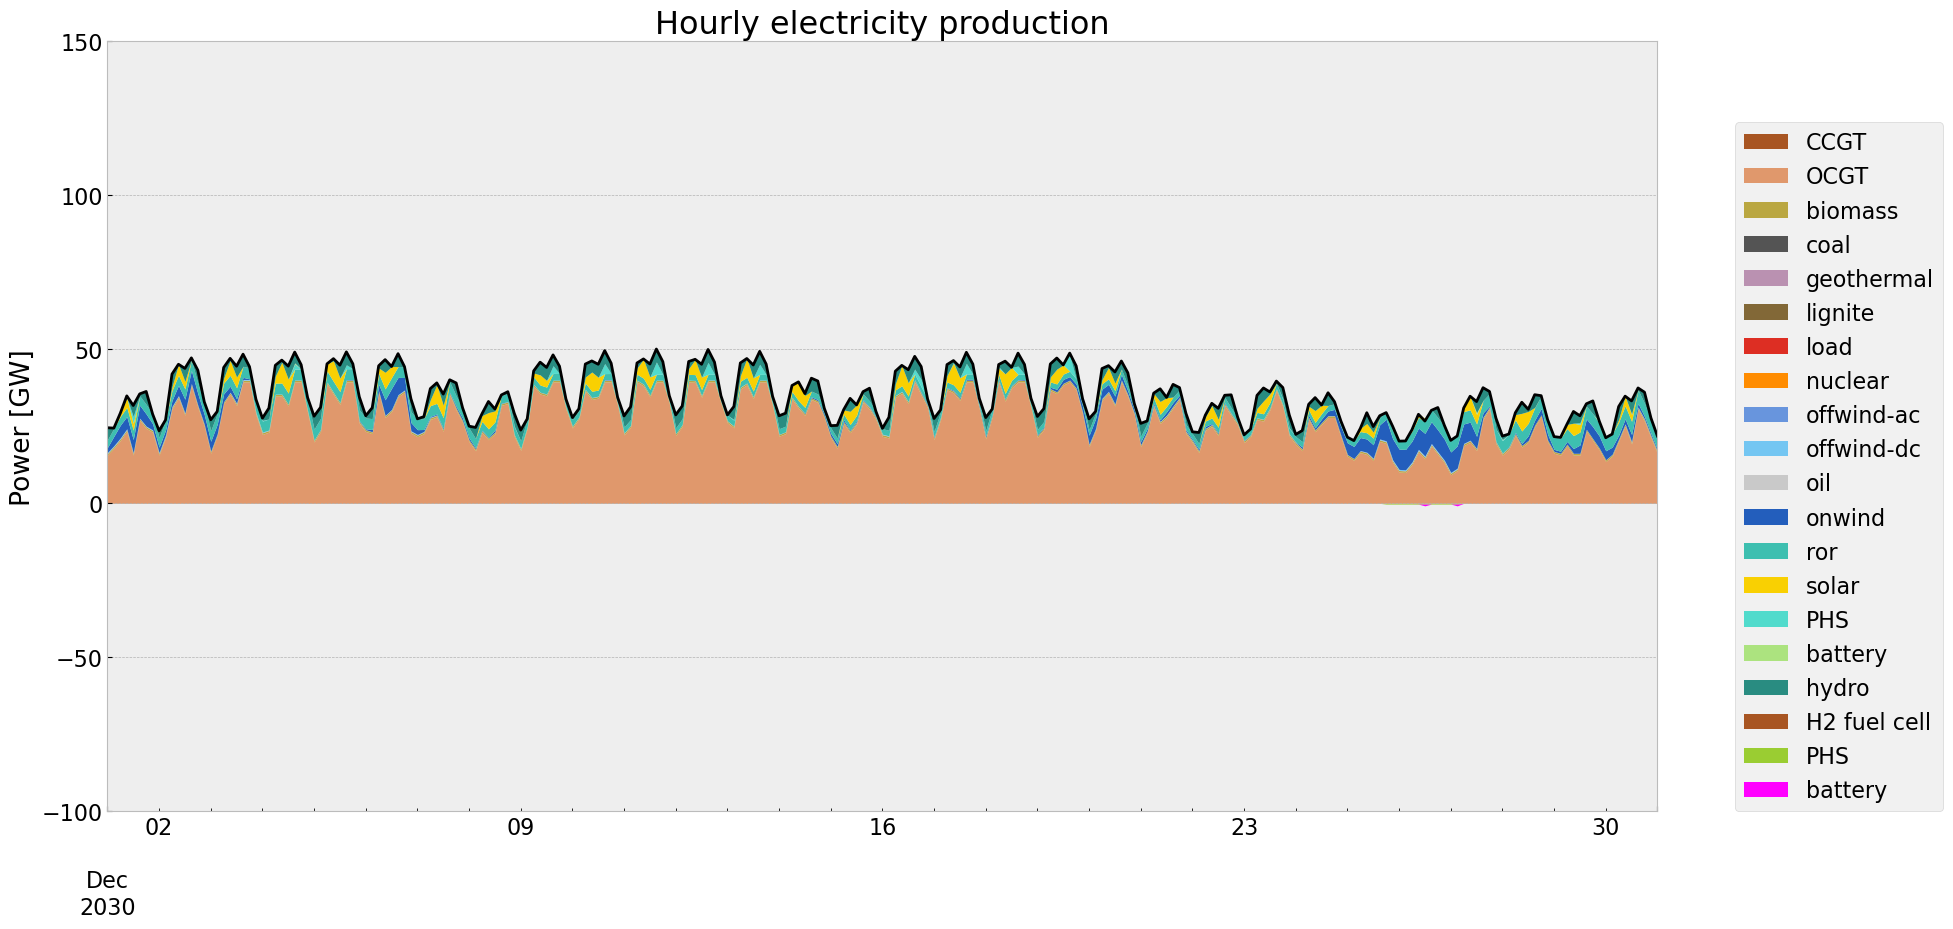

In [51]:
gen_curve(n1, '2030-12-01', '2030-12-31', colors_gen)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  p_by_carrier.index = pd.date_range(start='2030-01-01', end=

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  loads.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')


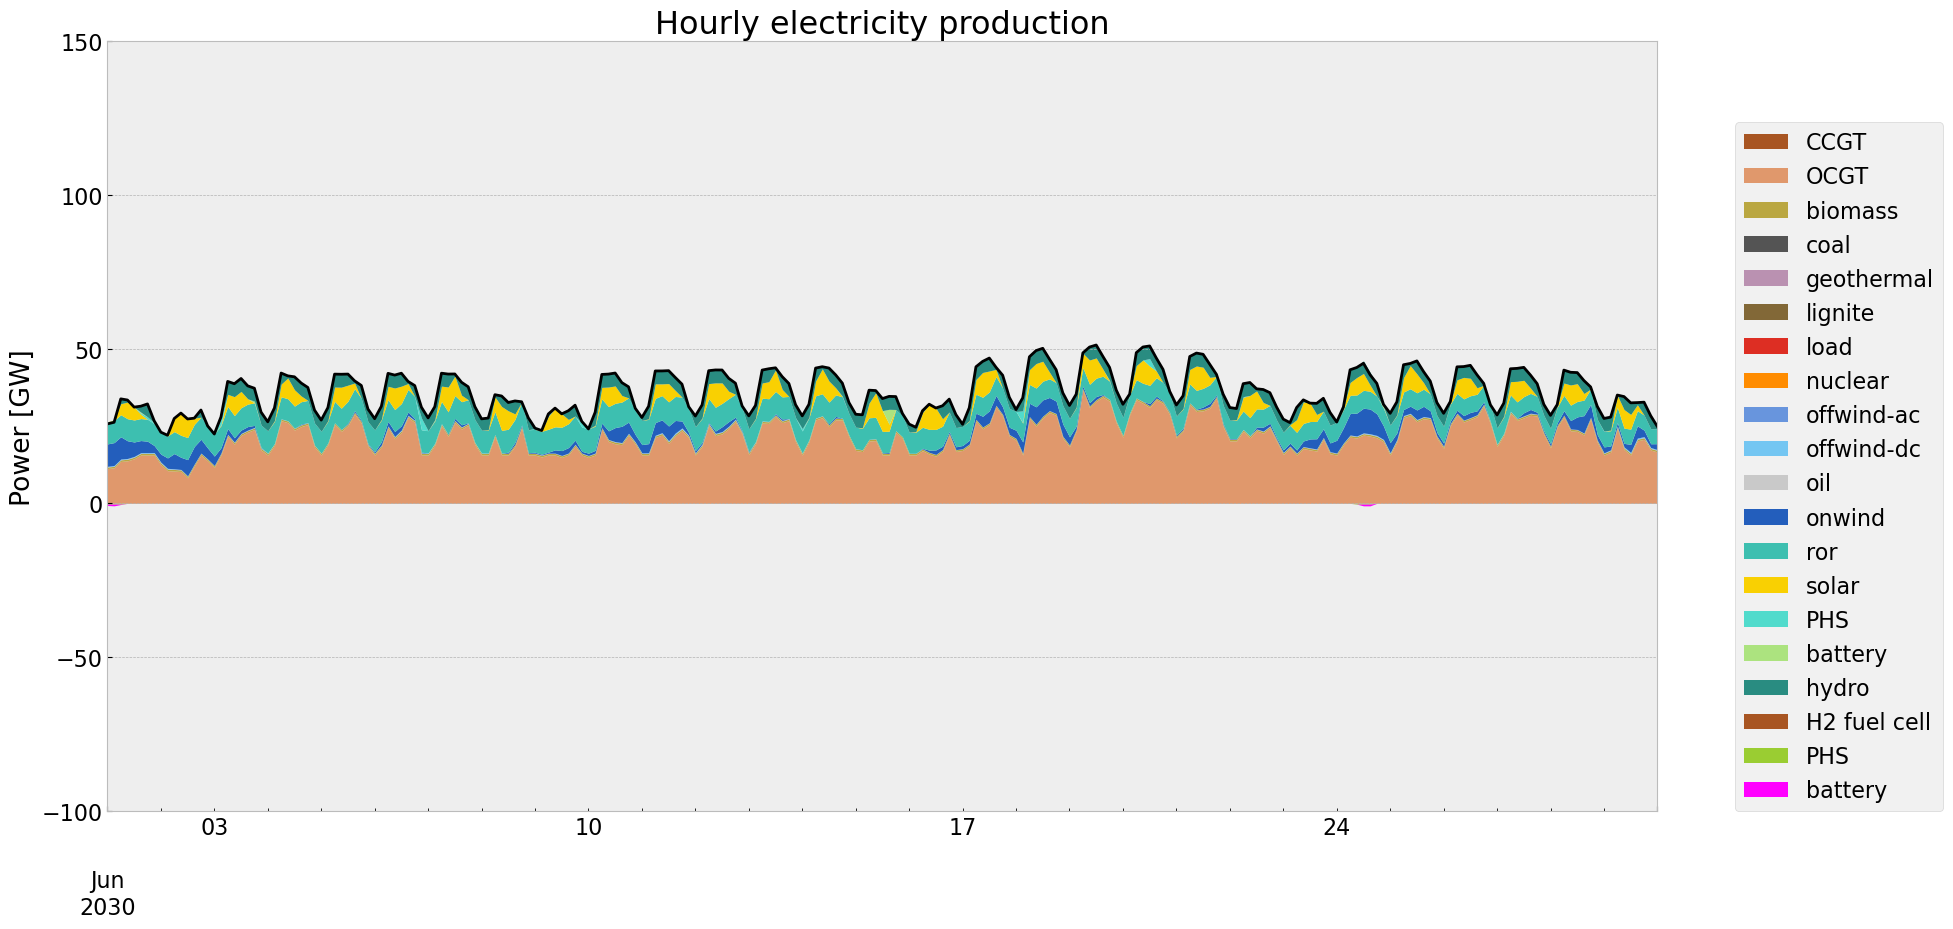

In [52]:
gen_curve(n1, '2030-06-1', '2030-06-30', colors_gen)

## Storage

carrier     PHS   battery   hydro
bus                              
IT0 0    4.9359  0.000000  3.5108
IT0 1    2.3960  6.103396  0.6060
IT1 0    0.2400  0.571904  0.0780

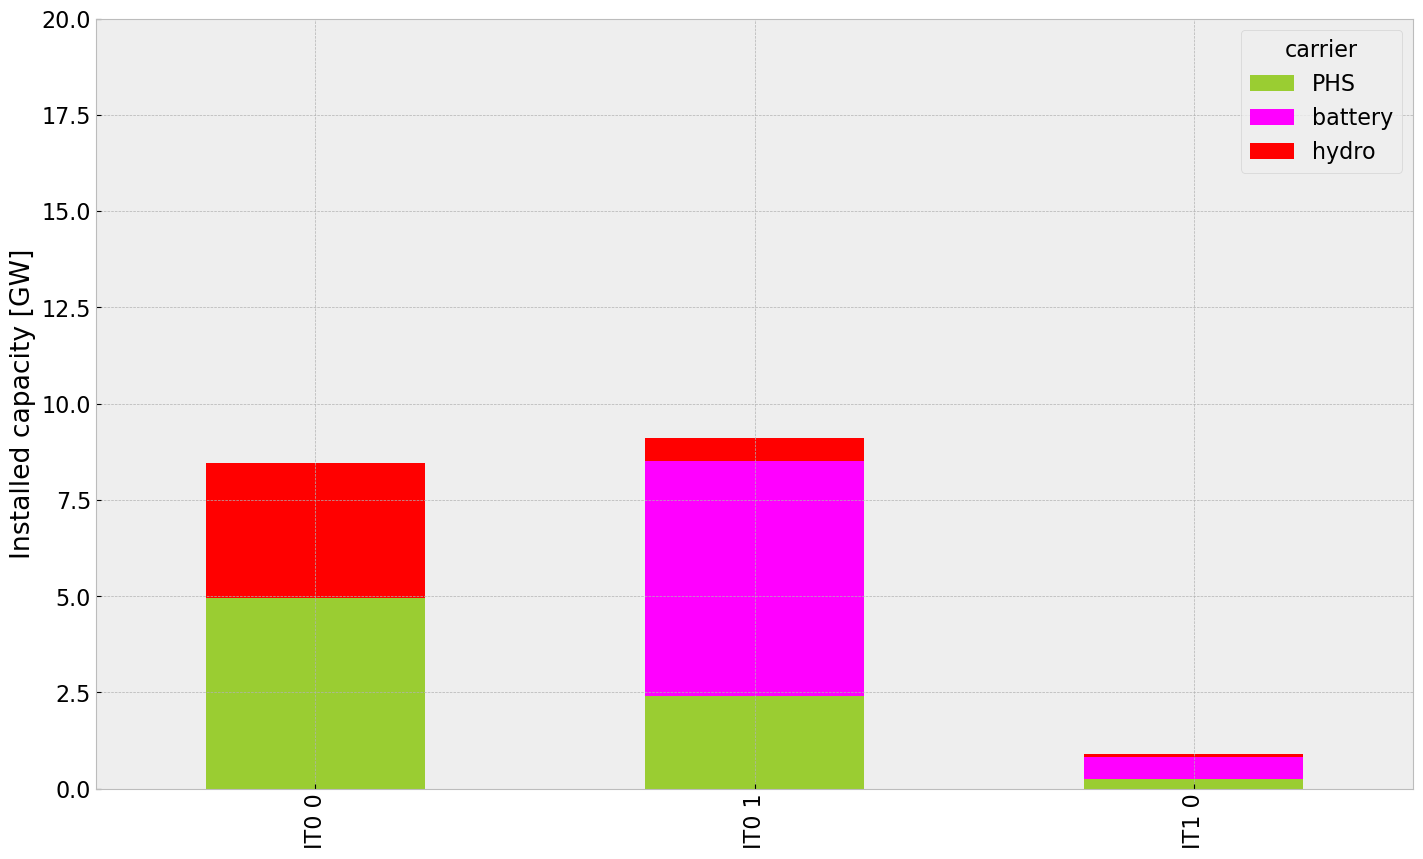

In [53]:
inst_store_table(n1)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\440258284.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\440258284.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  soc.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')


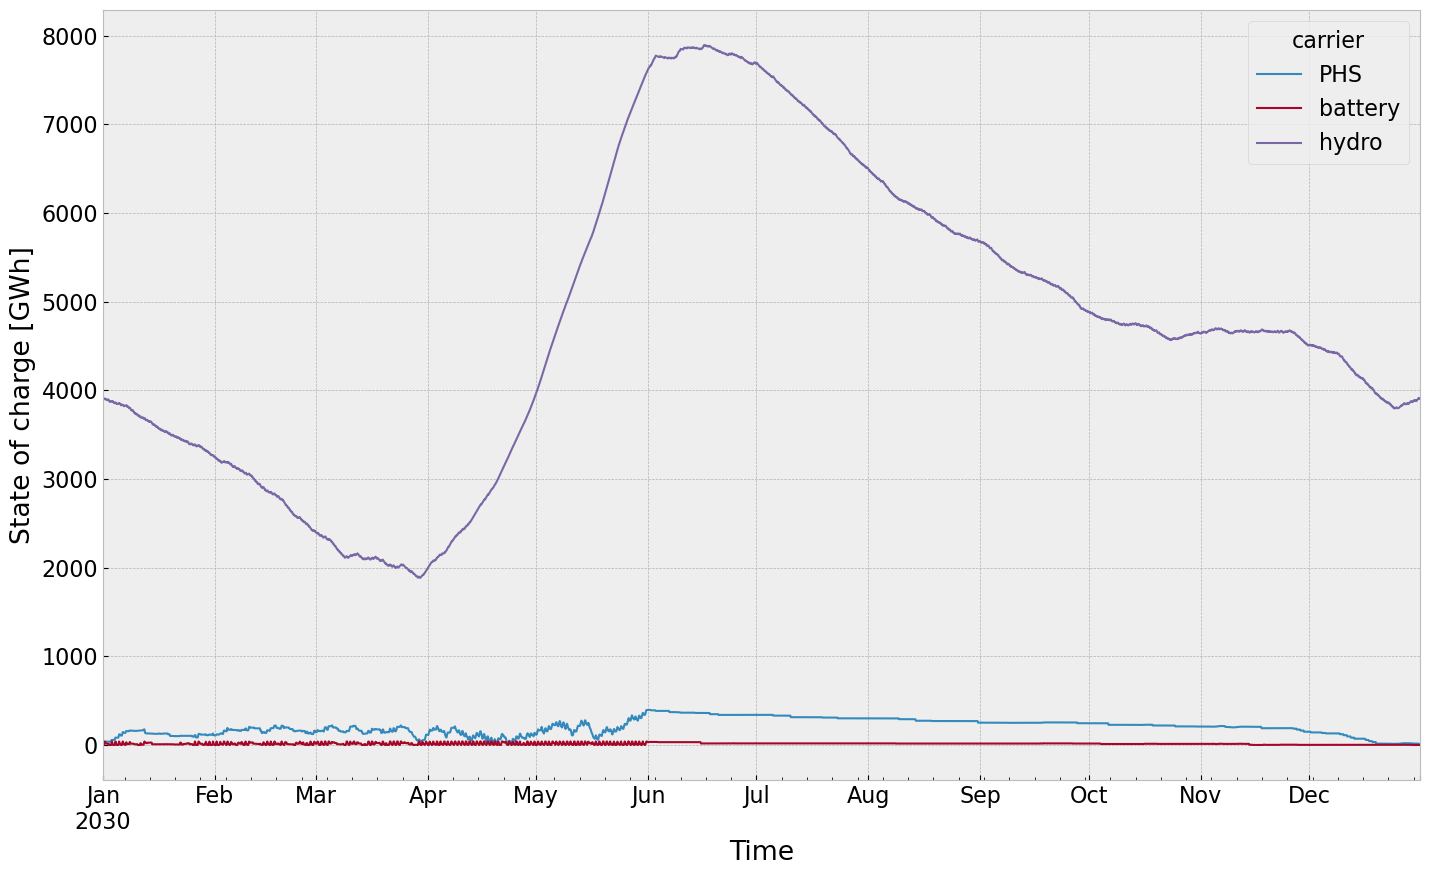

In [54]:
state_of_charge_plot(n1)


## Electricity Price


c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


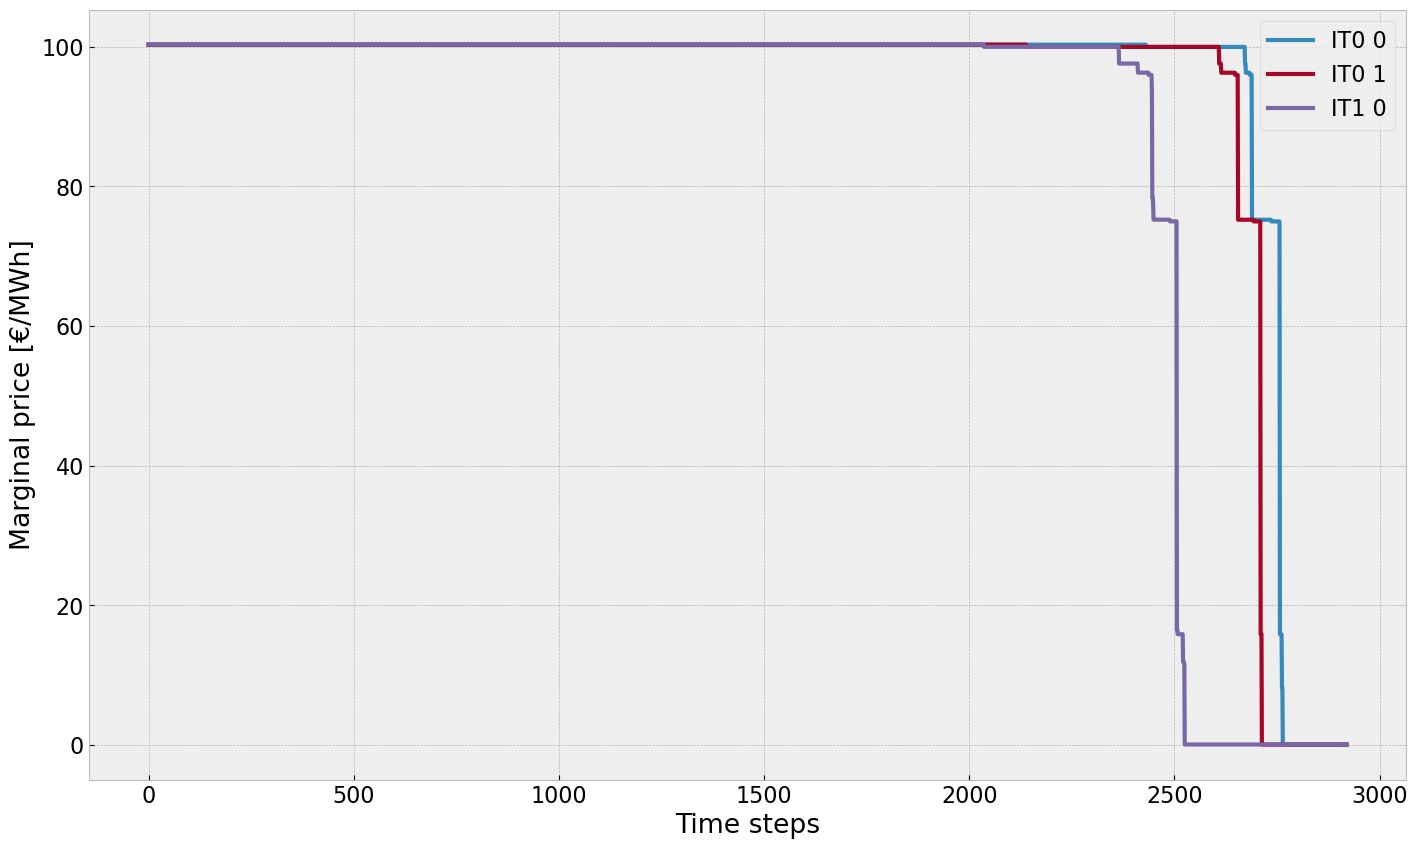

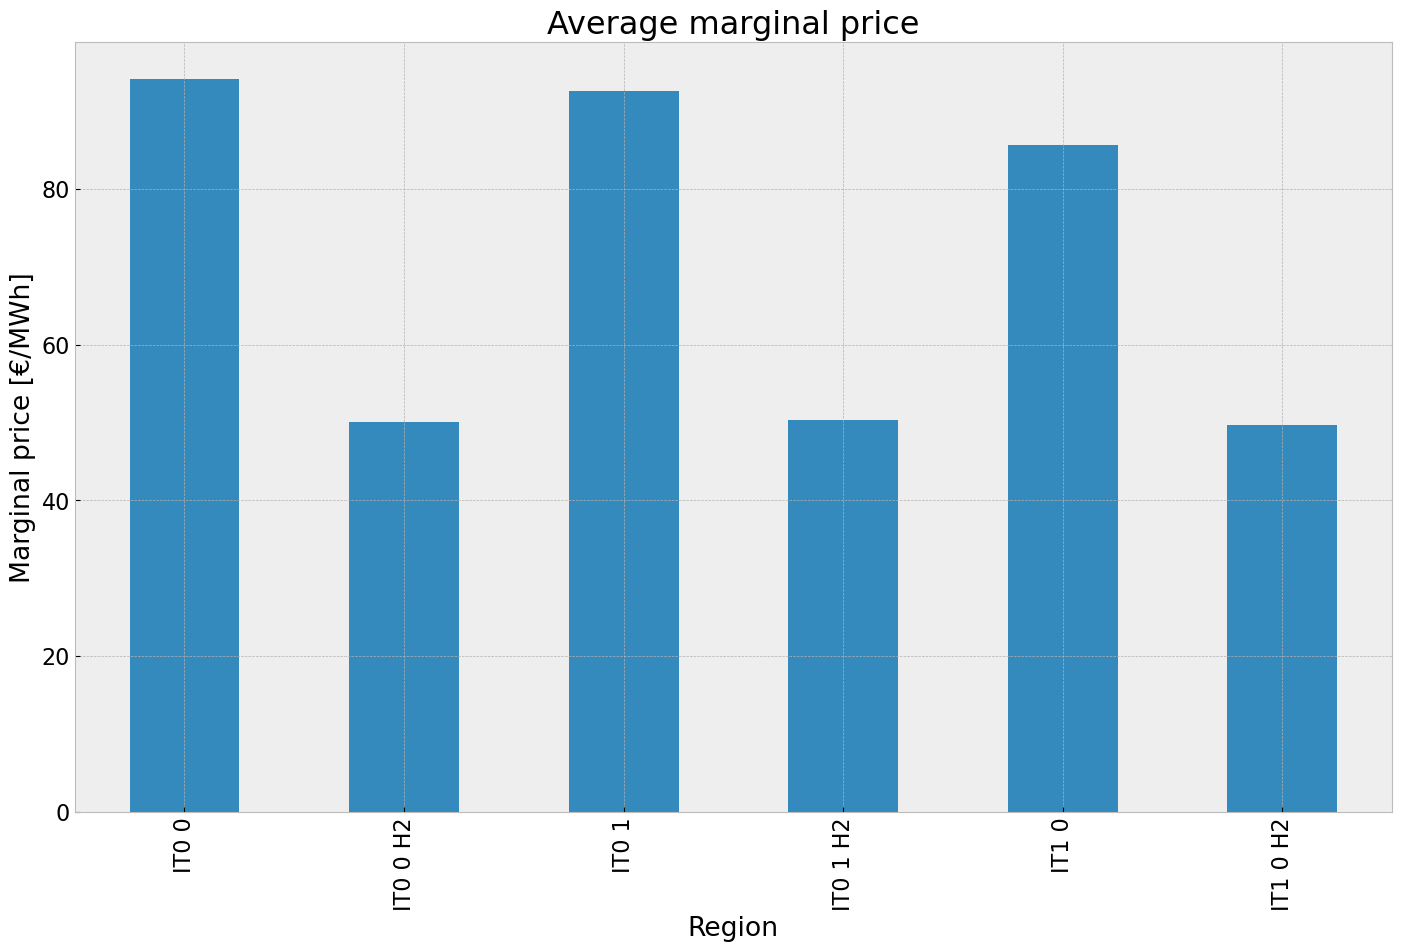

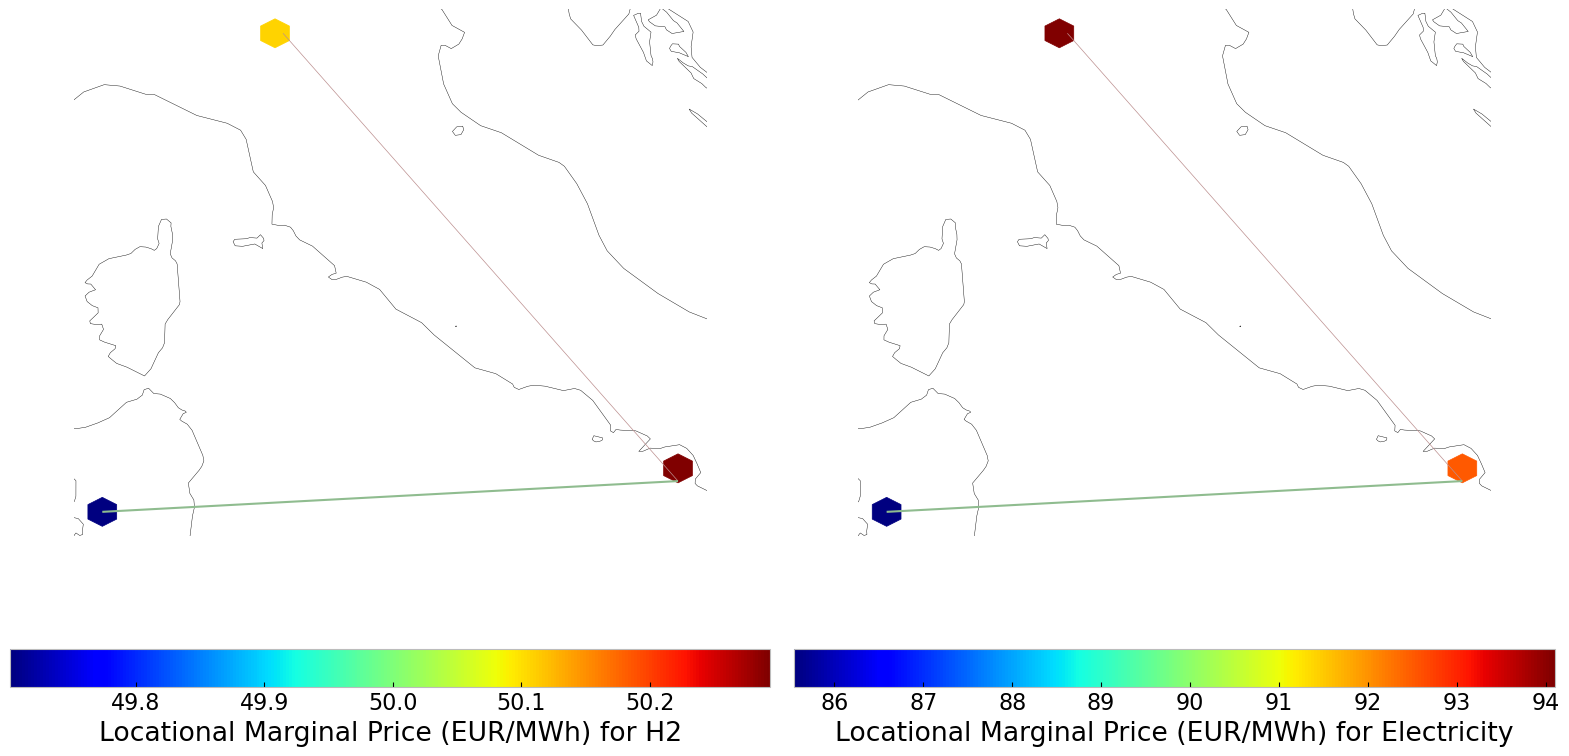

In [55]:
price_dur_curve_plot(n1)
price_regions_table(n1)
price_regions(n1)


## 2. Scenario: perfect foresight with no additional investment

In [56]:
#copy network
n2=n.copy()

#p_max_pu of solar generators across all regions are subtracted by 10% from 01.06.2013 to 31.12.13
for column in n2.generators_t.p_max_pu.columns:
        if column.endswith('solar'):
                for index,row in n2.generators_t.p_max_pu[column].items():
                        if index >= eruption_start:
                                new_p_max_pu = n2.generators_t.p_max_pu.at[index, column] * 0.1 #0.9
                                n2.generators_t.p_max_pu.at[index, column] = new_p_max_pu
                                if new_p_max_pu<0:
                                    n2.generators_t.p_max_pu.at[index, column] = 0

#set the optimal capacity of generators from the base scenario as the new minimum capacity 
for index, value in n2.generators.p_nom_extendable.items():
    if value:  
        n2.generators.at[index, 'p_nom_min'] = n.generators.at[index, 'p_nom_opt']
        n2.generators.at[index, 'p_nom_max'] = n.generators.at[index, 'p_nom_opt']

#set the optimal capacity of storage units from the base scenario as the new minimum capacity 
for index, value in n2.storage_units.p_nom_extendable.items():
    if value:  
        n2.storage_units.at[index, 'p_nom_min'] = n.storage_units.at[index, 'p_nom_opt']
        n2.storage_units.at[index, 'p_nom_max'] = n.storage_units.at[index, 'p_nom_opt']

#set the optimal capacity of storage units from the base scenario as the new minimum capacity 
for index, value in n2.stores.e_nom_extendable.items():
    if value:  
        n2.stores.at[index, 'e_nom_min'] = n.stores.at[index, 'e_nom_opt']
        n2.stores.at[index, 'e_nom_max'] = n.stores.at[index, 'e_nom_opt']


#set the optimal capacity of lines from the base scenario as the new minimum capacity 
for index, value in n2.lines.s_nom_extendable.items():
    if value:  
        n2.lines.at[index, 's_nom_min'] = n.lines.at[index, 's_nom_opt']
        n2.lines.at[index, 's_nom_max'] = n.lines.at[index, 's_nom_opt']

In [57]:
n2.generators[n2.generators['carrier']=='solar']

carrier    bus     p_nom_min  p_nom  p_nom_extendable  efficiency  \
Generator                                                                       
IT0 0 solar   solar  IT0 0  41904.034122    0.0              True         1.0   
IT0 1 solar   solar  IT0 1  68590.847276    0.0              True         1.0   
IT1 0 solar   solar  IT1 0   5313.404038    0.0              True         1.0   

             marginal_cost  capital_cost     p_nom_max        weight control  \
Generator                                                                      
IT0 0 solar       0.019877  39296.472708  41904.034122  56105.496479           
IT0 1 solar       0.019646  39296.472708  68590.847276  53198.633823           
IT1 0 solar       0.020787  39296.472708   5313.404038   6273.290436           

             p_max_pu  sign  build_year  min_up_time  min_down_time  \
Generator                                                             
IT0 0 solar       1.0   1.0           0            0              0   
IT0 1 solar       1.0   1.0           0            0              0   
IT1 0 solar       1.0   1.0           0            0              0   

             up_time_before  down_time_before     p_nom_opt type  p_nom_mod  \
Generator                                                                     
IT0 0 solar               1                 0  41904.034122             0.0   
IT0 1 solar               1                 0  68590.847276             0.0   
IT1 0 solar               1                 0   5313.404038             0.0   

             p_min_pu  p_set  q_set  marginal_cost_quadratic  lifetime  \
Generator                                                                
IT0 0 solar       0.0    0.0    0.0                      0.0       inf   
IT0 1 solar       0.0    0.0    0.0                      0.0       inf   
IT1 0 solar       0.0    0.0    0.0                      0.0       inf   

             committable  start_up_cost  shut_down_cost  stand_by_cost  \
Generator                                                                
IT0 0 solar        False            0.0             0.0            0.0   
IT0 1 solar        False            0.0             0.0            0.0   
IT1 0 solar        False            0.0             0.0            0.0   

             ramp_limit_up  ramp_limit_down  ramp_limit_start_up  \
Generator                                                          
IT0 0 solar            NaN              NaN                  1.0   
IT0 1 solar            NaN              NaN                  1.0   
IT1 0 solar            NaN              NaN                  1.0   

             ramp_limit_shut_down  
Generator                          
IT0 0 solar                   1.0  
IT0 1 solar                   1.0  
IT1 0 solar                   1.0

In [58]:
n2.optimize.create_model()

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * StorageUnit-p_nom (StorageUnit-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * StorageUnit-spill (snapshot, StorageUnit)
 * Store-p (snapshot, Store)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * StorageUnit-ext-p_nom-lower (StorageUnit-ext)
 * StorageUnit-ext-p_nom-upper (StorageUnit-ext)
 * Generator-

In [59]:
n2.optimize(solver_name ='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 15/15 [00:00<00:00, 16.72it/s]
INFO:linopy.io: Writing time: 6.43s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kx4lm3g1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kx4lm3g1.lp


Reading time = 2.03 seconds


INFO:gurobipy:Reading time = 2.03 seconds


obj: 531492 rows, 256950 columns, 997228 nonzeros


INFO:gurobipy:obj: 531492 rows, 256950 columns, 997228 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 531492 rows, 256950 columns and 997228 nonzeros


INFO:gurobipy:Optimize a model with 531492 rows, 256950 columns and 997228 nonzeros


Model fingerprint: 0xdf92c280


INFO:gurobipy:Model fingerprint: 0xdf92c280


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+00, 2e+09]


INFO:gurobipy:  Bounds range     [4e+00, 2e+09]


  RHS range        [3e+00, 1e+09]


INFO:gurobipy:  RHS range        [3e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 476044 rows and 107229 columns


INFO:gurobipy:Presolve removed 476044 rows and 107229 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 55448 rows, 149721 columns, 295681 nonzeros


INFO:gurobipy:Presolved: 55448 rows, 149721 columns, 295681 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 1.255e+05


INFO:gurobipy: AA' NZ     : 1.255e+05


 Factor NZ  : 8.769e+05 (roughly 90 MB of memory)


INFO:gurobipy: Factor NZ  : 8.769e+05 (roughly 90 MB of memory)


 Factor Ops : 1.824e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.824e+07 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.21662079e+18 -5.72127968e+18  8.01e+11 5.18e+06  2.95e+14     1s


INFO:gurobipy:   0   2.21662079e+18 -5.72127968e+18  8.01e+11 5.18e+06  2.95e+14     1s


   1   1.13738858e+18 -2.99720822e+18  4.06e+11 1.99e+06  1.45e+14     1s


INFO:gurobipy:   1   1.13738858e+18 -2.99720822e+18  4.06e+11 1.99e+06  1.45e+14     1s


   2   1.09215562e+18 -2.53936571e+18  3.34e+11 8.60e+05  1.94e+14     1s


INFO:gurobipy:   2   1.09215562e+18 -2.53936571e+18  3.34e+11 8.60e+05  1.94e+14     1s


   3   5.46899582e+16 -3.31799452e+17  9.62e+09 8.59e+04  6.94e+12     1s


INFO:gurobipy:   3   5.46899582e+16 -3.31799452e+17  9.62e+09 8.59e+04  6.94e+12     1s


   4   1.15675751e+16 -7.40950349e+15  6.41e+07 2.30e+02  9.68e+10     1s


INFO:gurobipy:   4   1.15675751e+16 -7.40950349e+15  6.41e+07 2.30e+02  9.68e+10     1s


   5   1.27380401e+15 -9.38897849e+14  6.22e+06 4.19e+00  1.02e+10     2s


INFO:gurobipy:   5   1.27380401e+15 -9.38897849e+14  6.22e+06 4.19e+00  1.02e+10     2s


   6   4.10304723e+14 -2.01488654e+14  1.38e+06 1.25e-01  2.50e+09     2s


INFO:gurobipy:   6   4.10304723e+14 -2.01488654e+14  1.38e+06 1.25e-01  2.50e+09     2s


   7   8.17552071e+12 -3.26791669e+13  2.52e+01 6.15e-03  1.38e+08     2s


INFO:gurobipy:   7   8.17552071e+12 -3.26791669e+13  2.52e+01 6.15e-03  1.38e+08     2s


   8   2.20692216e+12 -7.48144907e+12  5.93e+00 1.31e-03  3.18e+07     2s


INFO:gurobipy:   8   2.20692216e+12 -7.48144907e+12  5.93e+00 1.31e-03  3.18e+07     2s


   9   5.58885887e+11 -1.79490637e+12  8.90e-01 3.13e-04  7.66e+06     2s


INFO:gurobipy:   9   5.58885887e+11 -1.79490637e+12  8.90e-01 3.13e-04  7.66e+06     2s


  10   3.57811433e+11 -5.12502227e+11  5.02e-01 9.15e-05  2.83e+06     2s


INFO:gurobipy:  10   3.57811433e+11 -5.12502227e+11  5.02e-01 9.15e-05  2.83e+06     2s


  11   1.77930868e+11 -5.43875439e+10  1.72e-01 1.55e-05  7.54e+05     2s


INFO:gurobipy:  11   1.77930868e+11 -5.43875439e+10  1.72e-01 1.55e-05  7.54e+05     2s


  12   1.19554563e+11  5.70280241e+09  8.41e-02 7.18e-06  3.70e+05     2s


INFO:gurobipy:  12   1.19554563e+11  5.70280241e+09  8.41e-02 7.18e-06  3.70e+05     2s


  13   9.65918531e+10  3.12960788e+10  5.13e-02 3.46e-06  2.12e+05     2s


INFO:gurobipy:  13   9.65918531e+10  3.12960788e+10  5.13e-02 3.46e-06  2.12e+05     2s


  14   8.12831227e+10  4.44222313e+10  2.97e-02 1.70e-06  1.20e+05     2s


INFO:gurobipy:  14   8.12831227e+10  4.44222313e+10  2.97e-02 1.70e-06  1.20e+05     2s


  15   7.11089629e+10  5.31159517e+10  1.55e-02 6.85e-07  5.84e+04     3s


INFO:gurobipy:  15   7.11089629e+10  5.31159517e+10  1.55e-02 6.85e-07  5.84e+04     3s


  16   6.54084854e+10  5.65124268e+10  8.04e-03 2.76e-07  2.89e+04     3s


INFO:gurobipy:  16   6.54084854e+10  5.65124268e+10  8.04e-03 2.76e-07  2.89e+04     3s


  17   6.46397080e+10  5.69286605e+10  6.93e-03 2.40e-07  2.50e+04     3s


INFO:gurobipy:  17   6.46397080e+10  5.69286605e+10  6.93e-03 2.40e-07  2.50e+04     3s


  18   6.28706434e+10  5.85949593e+10  4.46e-03 9.45e-08  1.39e+04     3s


INFO:gurobipy:  18   6.28706434e+10  5.85949593e+10  4.46e-03 9.45e-08  1.39e+04     3s


  19   6.10545409e+10  5.91104836e+10  1.86e-03 4.85e-08  6.31e+03     3s


INFO:gurobipy:  19   6.10545409e+10  5.91104836e+10  1.86e-03 4.85e-08  6.31e+03     3s


  20   6.05530461e+10  5.92659421e+10  1.15e-03 3.48e-08  4.18e+03     3s


INFO:gurobipy:  20   6.05530461e+10  5.92659421e+10  1.15e-03 3.48e-08  4.18e+03     3s


  21   6.02428249e+10  5.93519390e+10  7.19e-04 2.81e-08  2.89e+03     3s


INFO:gurobipy:  21   6.02428249e+10  5.93519390e+10  7.19e-04 2.81e-08  2.89e+03     3s


  22   6.01833738e+10  5.94070167e+10  6.36e-04 2.37e-08  2.52e+03     3s


INFO:gurobipy:  22   6.01833738e+10  5.94070167e+10  6.36e-04 2.37e-08  2.52e+03     3s


  23   5.99474917e+10  5.95061324e+10  3.13e-04 1.55e-08  1.43e+03     3s


INFO:gurobipy:  23   5.99474917e+10  5.95061324e+10  3.13e-04 1.55e-08  1.43e+03     3s


  24   5.98047500e+10  5.95808910e+10  1.16e-04 9.79e-09  7.26e+02     3s


INFO:gurobipy:  24   5.98047500e+10  5.95808910e+10  1.16e-04 9.79e-09  7.26e+02     3s


  25   5.97606850e+10  5.96496671e+10  6.41e-05 4.38e-09  3.60e+02     4s


INFO:gurobipy:  25   5.97606850e+10  5.96496671e+10  6.41e-05 4.38e-09  3.60e+02     4s


  26   5.97314791e+10  5.96852895e+10  2.50e-05 2.08e-09  1.50e+02     4s


INFO:gurobipy:  26   5.97314791e+10  5.96852895e+10  2.50e-05 2.08e-09  1.50e+02     4s


  27   5.97260862e+10  5.97006609e+10  1.85e-05 1.91e-09  8.25e+01     4s


INFO:gurobipy:  27   5.97260862e+10  5.97006609e+10  1.85e-05 1.91e-09  8.25e+01     4s


  28   5.97181949e+10  5.97049653e+10  9.22e-06 1.89e-09  4.29e+01     4s


INFO:gurobipy:  28   5.97181949e+10  5.97049653e+10  9.22e-06 1.89e-09  4.29e+01     4s


  29   5.97136513e+10  5.97083954e+10  3.95e-06 2.18e-09  1.71e+01     4s


INFO:gurobipy:  29   5.97136513e+10  5.97083954e+10  3.95e-06 2.18e-09  1.71e+01     4s


  30   5.97115593e+10  5.97093979e+10  3.88e-04 2.24e-09  7.01e+00     4s


INFO:gurobipy:  30   5.97115593e+10  5.97093979e+10  3.88e-04 2.24e-09  7.01e+00     4s


  31   5.97106703e+10  5.97097882e+10  6.18e-04 2.06e-09  2.86e+00     4s


INFO:gurobipy:  31   5.97106703e+10  5.97097882e+10  6.18e-04 2.06e-09  2.86e+00     4s


  32   5.97101705e+10  5.97098588e+10  6.31e-04 1.93e-09  1.01e+00     5s


INFO:gurobipy:  32   5.97101705e+10  5.97098588e+10  6.31e-04 1.93e-09  1.01e+00     5s


  33   5.97101460e+10  5.97099146e+10  5.57e-04 1.71e-09  7.51e-01     5s


INFO:gurobipy:  33   5.97101460e+10  5.97099146e+10  5.57e-04 1.71e-09  7.51e-01     5s


  34   5.97099907e+10  5.97099424e+10  8.72e-05 1.72e-09  1.57e-01     5s


INFO:gurobipy:  34   5.97099907e+10  5.97099424e+10  8.72e-05 1.72e-09  1.57e-01     5s


  35   5.97099823e+10  5.97099491e+10  6.16e-05 1.69e-09  1.08e-01     5s


INFO:gurobipy:  35   5.97099823e+10  5.97099491e+10  6.16e-05 1.69e-09  1.08e-01     5s


  36   5.97099737e+10  5.97099527e+10  3.47e-05 1.69e-09  6.81e-02     5s


INFO:gurobipy:  36   5.97099737e+10  5.97099527e+10  3.47e-05 1.69e-09  6.81e-02     5s


  37   5.97099680e+10  5.97099580e+10  1.83e-05 1.28e-09  3.26e-02     5s


INFO:gurobipy:  37   5.97099680e+10  5.97099580e+10  1.83e-05 1.28e-09  3.26e-02     5s


  38   5.97099635e+10  5.97099606e+10  5.27e-06 1.63e-09  9.63e-03     6s


INFO:gurobipy:  38   5.97099635e+10  5.97099606e+10  5.27e-06 1.63e-09  9.63e-03     6s


  39   5.97099617e+10  5.97099615e+10  1.26e-07 2.03e-09  4.10e-04     6s


INFO:gurobipy:  39   5.97099617e+10  5.97099615e+10  1.26e-07 2.03e-09  4.10e-04     6s


  40   5.97099616e+10  5.97099616e+10  3.53e-09 1.89e-09  3.05e-05     6s


INFO:gurobipy:  40   5.97099616e+10  5.97099616e+10  3.53e-09 1.89e-09  3.05e-05     6s


  41   5.97099616e+10  5.97099616e+10  3.38e-07 1.41e-08  3.52e-07     6s


INFO:gurobipy:  41   5.97099616e+10  5.97099616e+10  3.38e-07 1.41e-08  3.52e-07     6s


  42   5.97099616e+10  5.97099616e+10  4.23e-07 2.99e-08  5.87e-10     6s


INFO:gurobipy:  42   5.97099616e+10  5.97099616e+10  4.23e-07 2.99e-08  5.87e-10     6s


INFO:gurobipy:


Barrier solved model in 42 iterations and 6.01 seconds (2.31 work units)


INFO:gurobipy:Barrier solved model in 42 iterations and 6.01 seconds (2.31 work units)


Optimal objective 5.97099616e+10


INFO:gurobipy:Optimal objective 5.97099616e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   17592 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   17592 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:


   22231 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:   22231 PPushes remaining with PInf 0.0000000e+00                 6s


       0 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8019813e-10      7s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8019813e-10      7s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   22306    5.9709962e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   22306    5.9709962e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 22306 iterations and 6.86 seconds (2.72 work units)


INFO:gurobipy:Solved in 22306 iterations and 6.86 seconds (2.72 work units)


Optimal objective  5.970996161e+10


INFO:gurobipy:Optimal objective  5.970996161e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 256950 primals, 531492 duals
Objective: 5.97e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper,

('ok', 'optimal')

In [60]:
tot_cos_noinv=n2.objective/1e9 #billion €
system_cost_noinv = system_cost(n2) #million €/a
marg_price_region_noinv = n2.buses_t.marginal_price.mean()
stat_noinv = n2.statistics()

## Installed Capacity

Since expansion is not allowed in this scenario, the installed capacity will equal to that of the base scenario.

In [61]:
n2.generators[n2.generators['carrier']=='solar']

carrier    bus     p_nom_min  p_nom  p_nom_extendable  efficiency  \
Generator                                                                       
IT0 0 solar   solar  IT0 0  41904.034122    0.0              True         1.0   
IT0 1 solar   solar  IT0 1  68590.847276    0.0              True         1.0   
IT1 0 solar   solar  IT1 0   5313.404038    0.0              True         1.0   

             marginal_cost  capital_cost     p_nom_max        weight control  \
Generator                                                                      
IT0 0 solar       0.019877  39296.472708  41904.034122  56105.496479           
IT0 1 solar       0.019646  39296.472708  68590.847276  53198.633823           
IT1 0 solar       0.020787  39296.472708   5313.404038   6273.290436           

             p_max_pu  sign  build_year  min_up_time  min_down_time  \
Generator                                                             
IT0 0 solar       1.0   1.0           0            0              0   
IT0 1 solar       1.0   1.0           0            0              0   
IT1 0 solar       1.0   1.0           0            0              0   

             up_time_before  down_time_before     p_nom_opt type  p_nom_mod  \
Generator                                                                     
IT0 0 solar               1                 0  41904.034122             0.0   
IT0 1 solar               1                 0  68590.847275             0.0   
IT1 0 solar               1                 0   5313.404038             0.0   

             p_min_pu  p_set  q_set  marginal_cost_quadratic  lifetime  \
Generator                                                                
IT0 0 solar       0.0    0.0    0.0                      0.0       inf   
IT0 1 solar       0.0    0.0    0.0                      0.0       inf   
IT1 0 solar       0.0    0.0    0.0                      0.0       inf   

             committable  start_up_cost  shut_down_cost  stand_by_cost  \
Generator                                                                
IT0 0 solar        False            0.0             0.0            0.0   
IT0 1 solar        False            0.0             0.0            0.0   
IT1 0 solar        False            0.0             0.0            0.0   

             ramp_limit_up  ramp_limit_down  ramp_limit_start_up  \
Generator                                                          
IT0 0 solar            NaN              NaN                  1.0   
IT0 1 solar            NaN              NaN                  1.0   
IT1 0 solar            NaN              NaN                  1.0   

             ramp_limit_shut_down  
Generator                          
IT0 0 solar                   1.0  
IT0 1 solar                   1.0  
IT1 0 solar                   1.0

<Figure size 640x480 with 0 Axes>

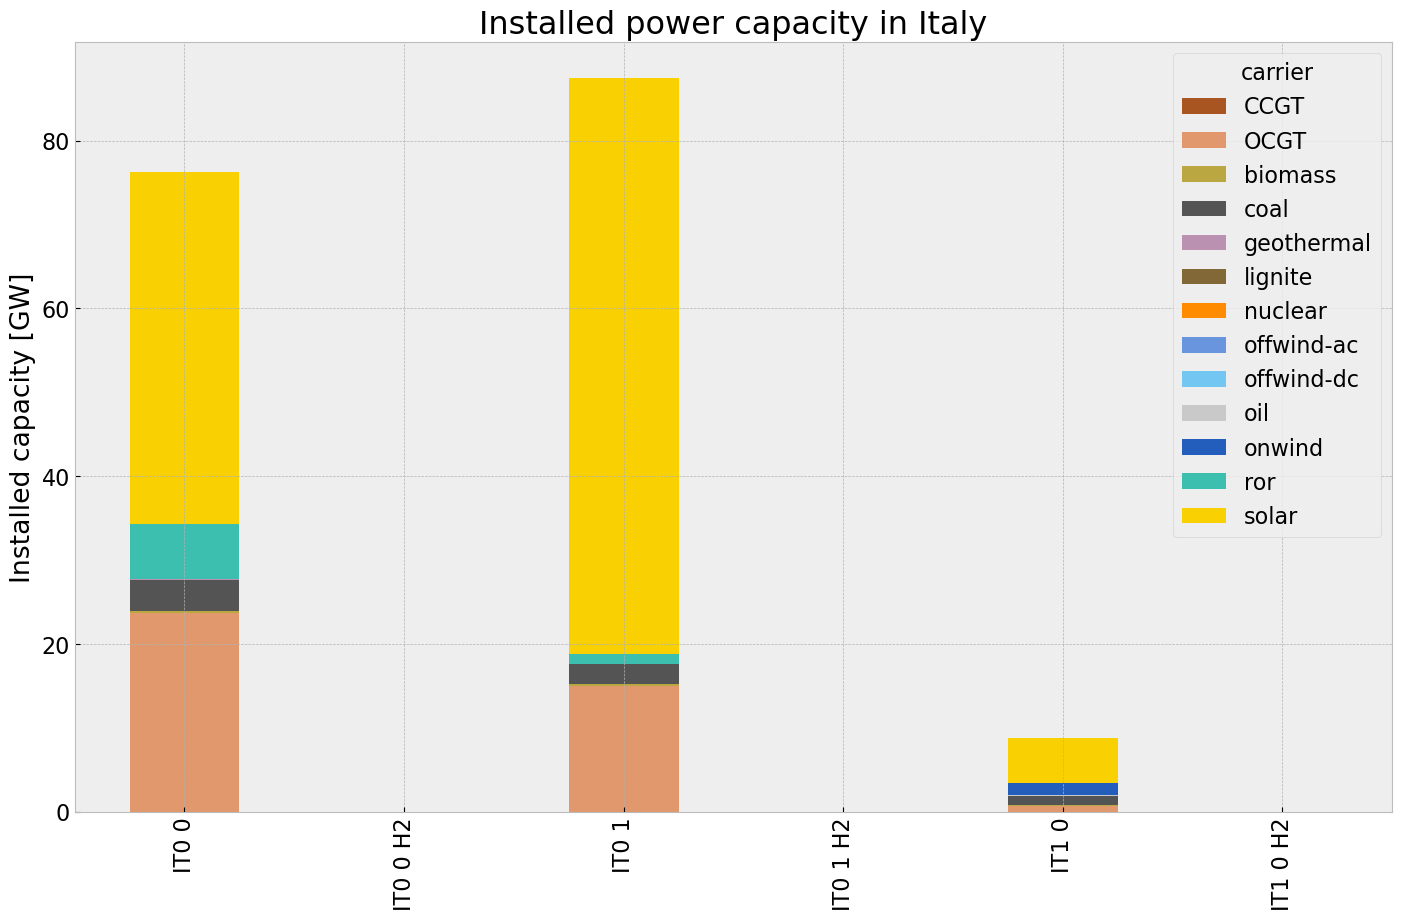

In [62]:
# consolidated istalled cap without load_shedding

capacities_noinv = n2.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
capacities_noinv.fillna(0, inplace=True)
gen = (capacities_noinv.unstack()/1000).drop(columns=['load'],inplace=False)


cap_noinv = inst_cap_table(n2, color_cap)



## Generation

<Figure size 640x480 with 0 Axes>

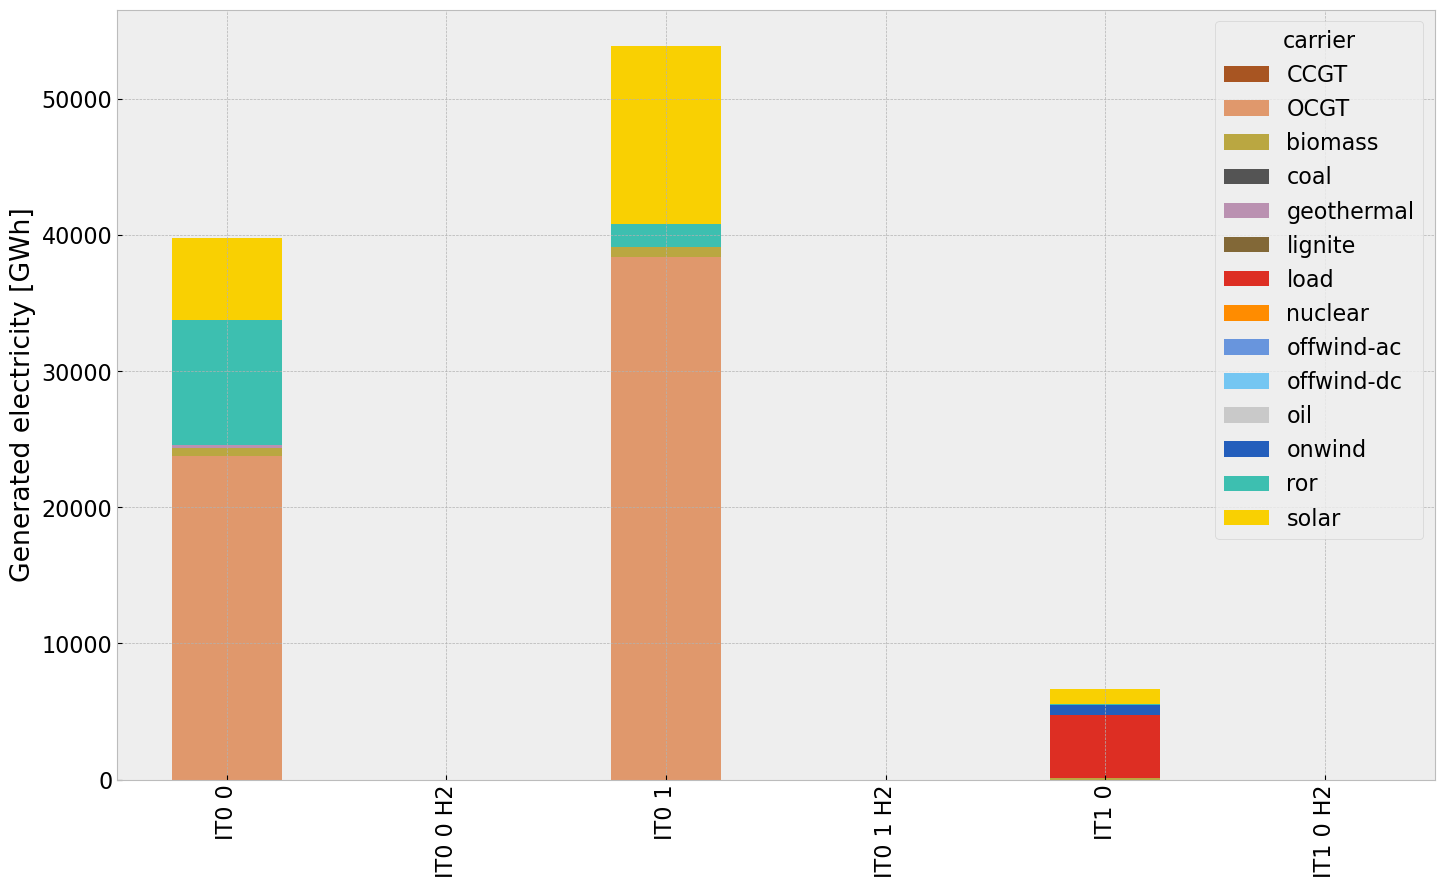

In [63]:
# consolidated generation table
carrier = n2.generators.carrier.unique()
df_tot_generation = n2.generators_t.p.sum()

generations = pd.Series(index = n2.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

for r in region:
    for tech in carrier:
        key = f"{r} {tech}"
        if key in df_tot_generation.index:
            try:
                generations.loc[r, tech] = df_tot_generation[key]
                #print(generations.loc[r, tech])
            except KeyError:
                print('error')

generations.fillna(0, inplace=True)
gen_noinv = generations.unstack()/1000#GWh

gen_noinv= gen_power_table(n2,colors_gen_table)




## Snapshot

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2615338355.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p = n2.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2615338355.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier

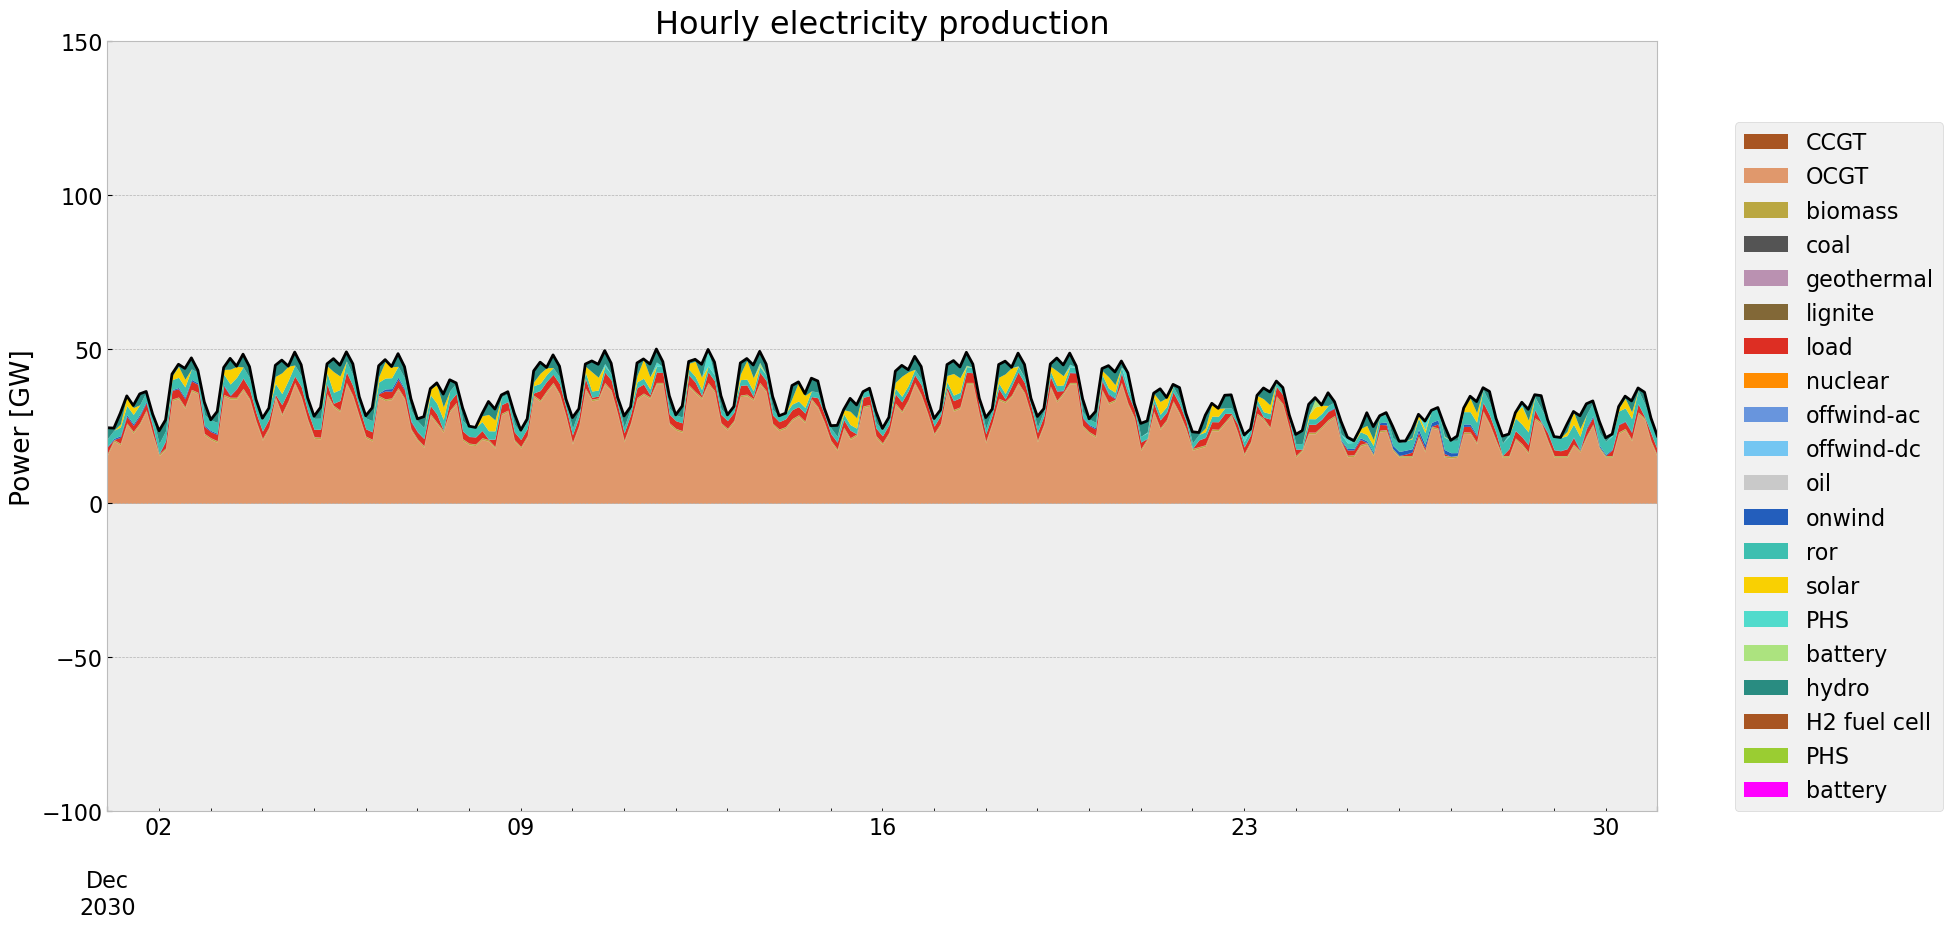

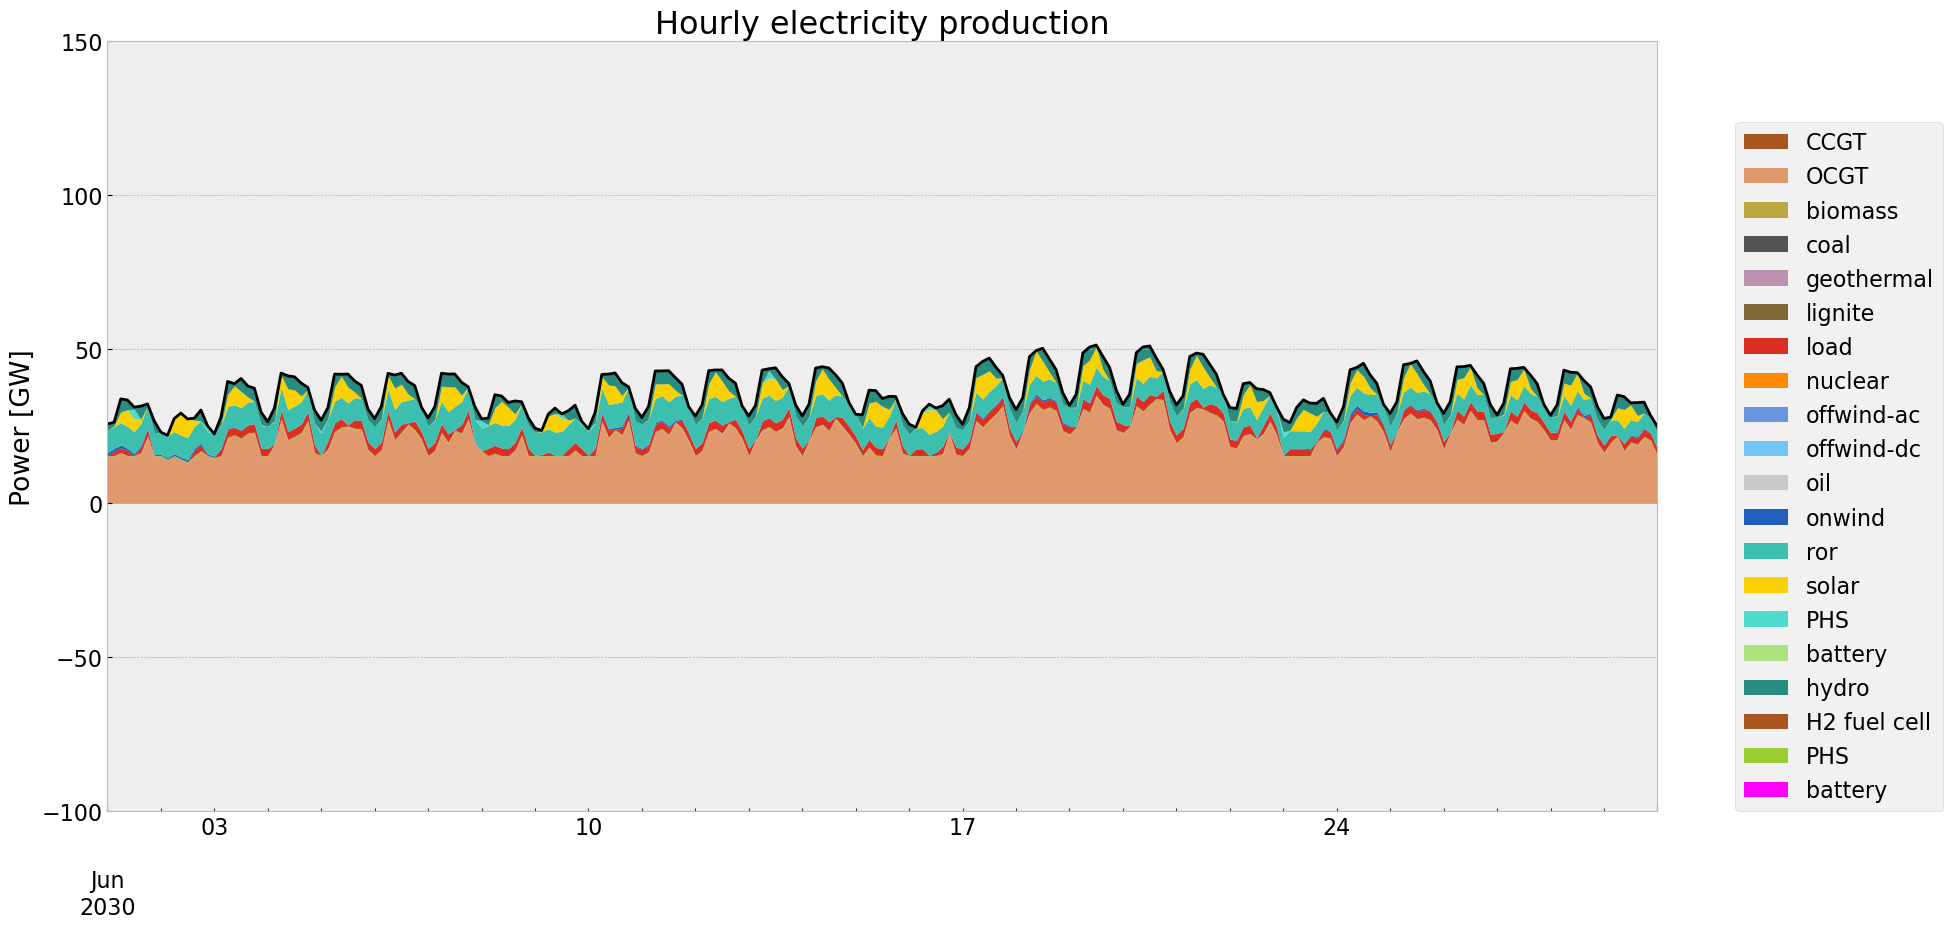

In [64]:
p = n2.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
sto = n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)    

gen_curve(n2, '2030-12-01', '2030-12-31', colors_gen)
gen_curve(n2, '2030-06-01', '2030-06-30', colors_gen)


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\440258284.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\440258284.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  soc.index = pd.date_range(start='2030-01-01', end='2030-12-31 21:00:00', freq='3H')
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2108808841.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3).loc[pd.date_range(start="2013-01-01", end="2013-12-31",freq='3H')].plot(figsize=(20,10))
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2108808841.py:3: FutureWarning: 'H' is deprecated and will be removed in a future

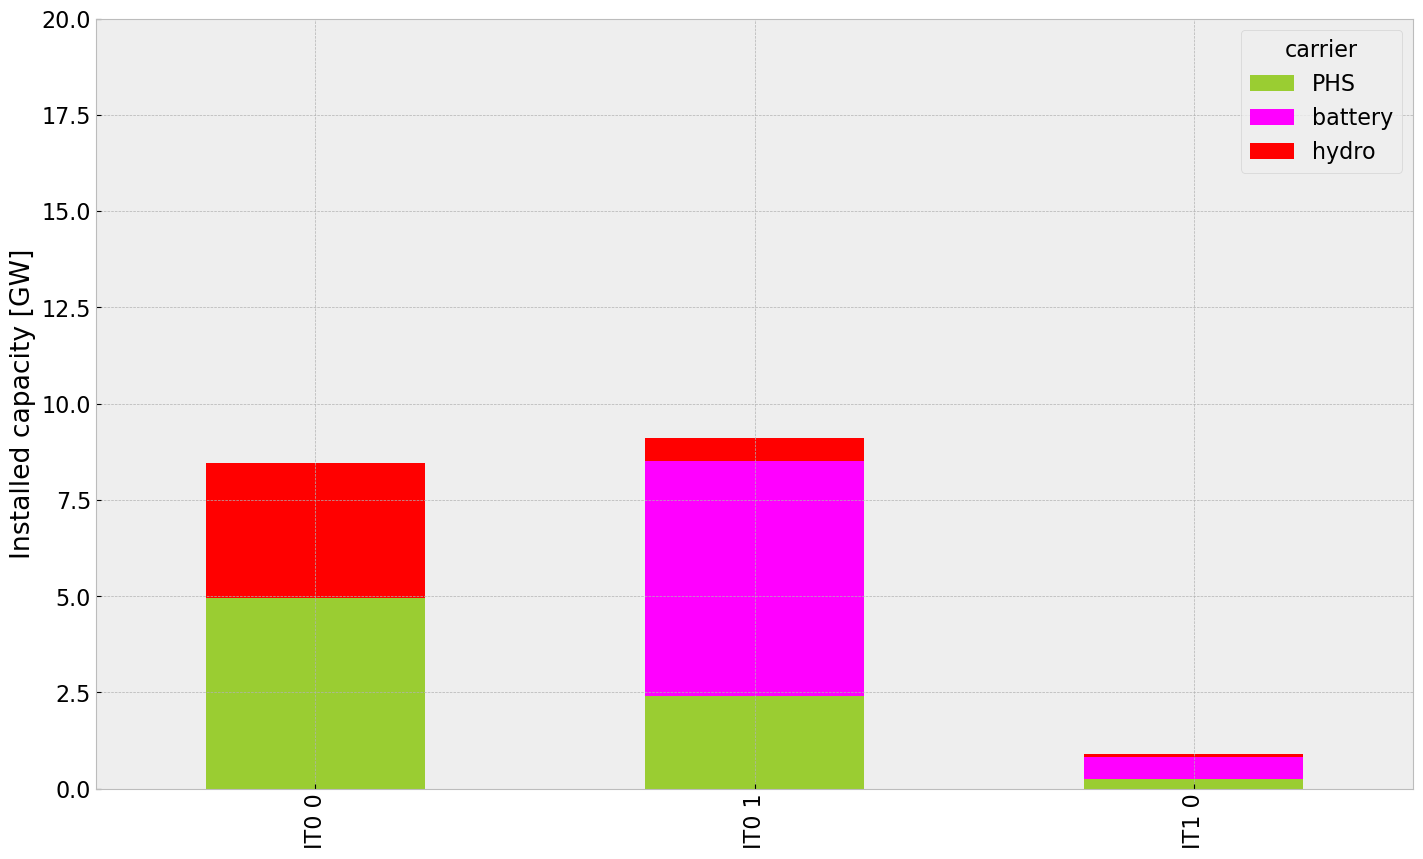

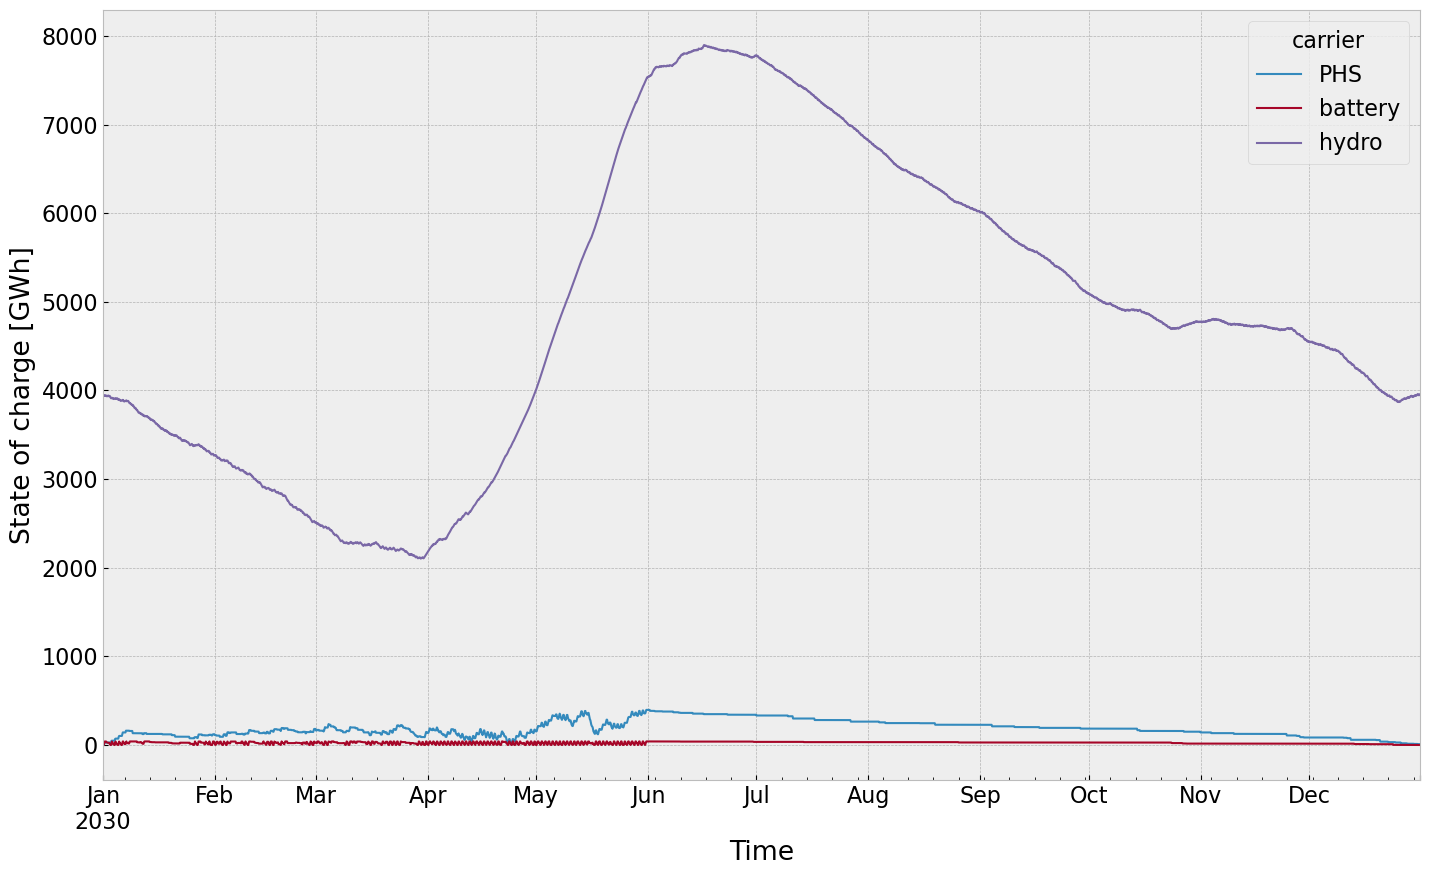

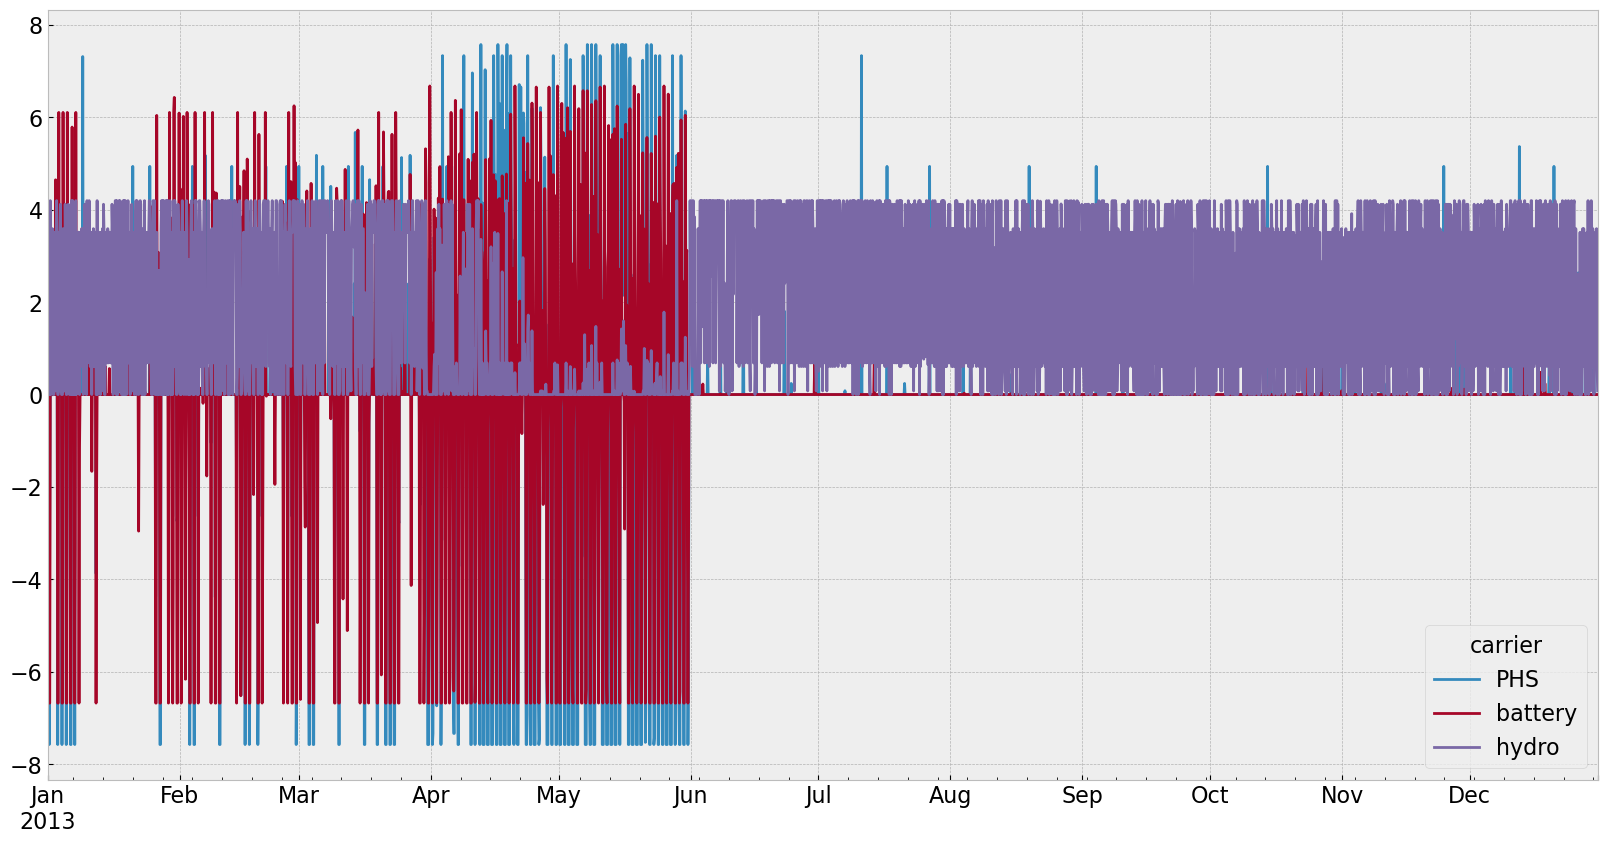

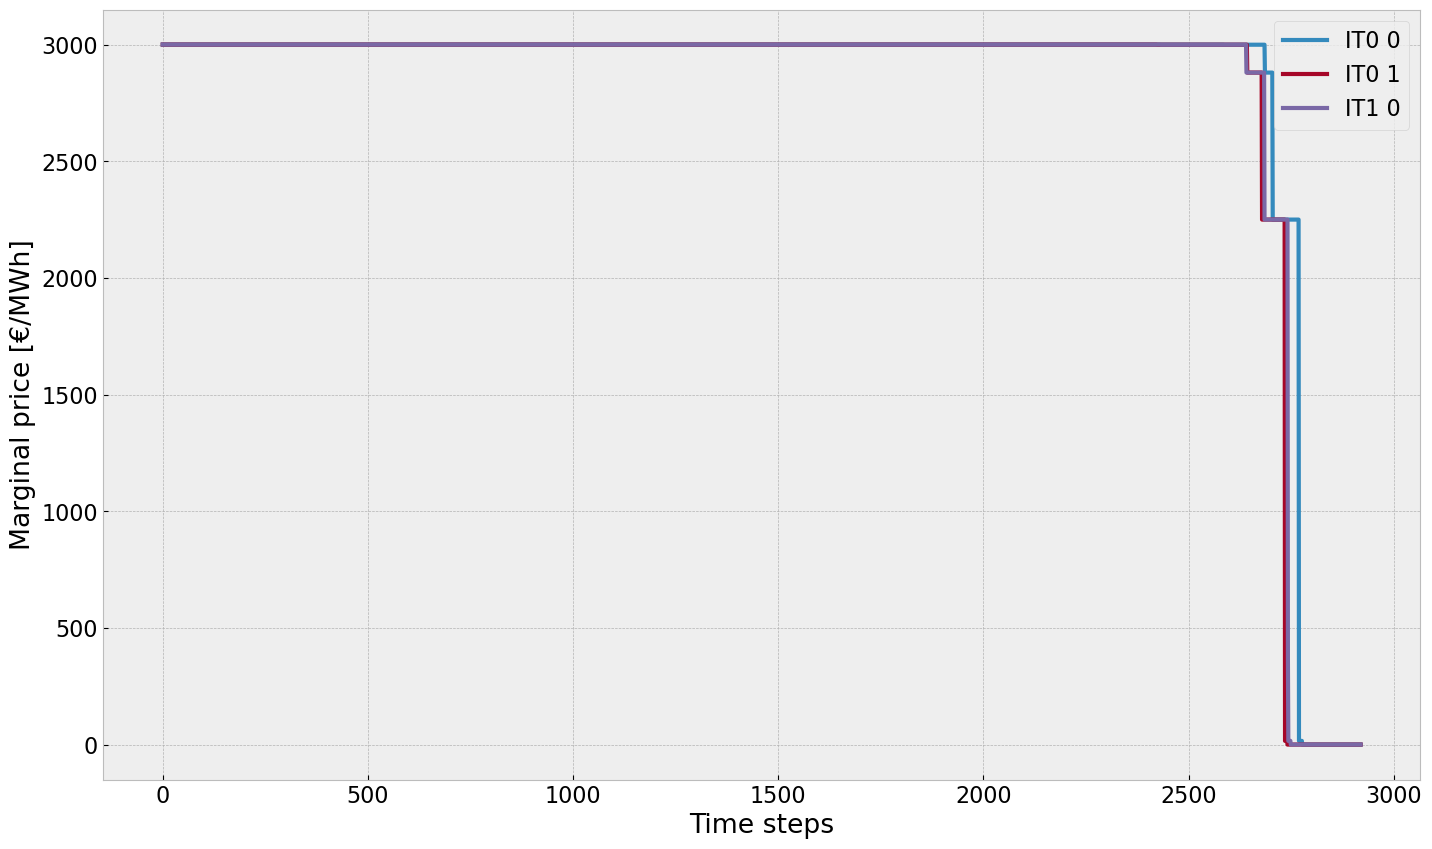

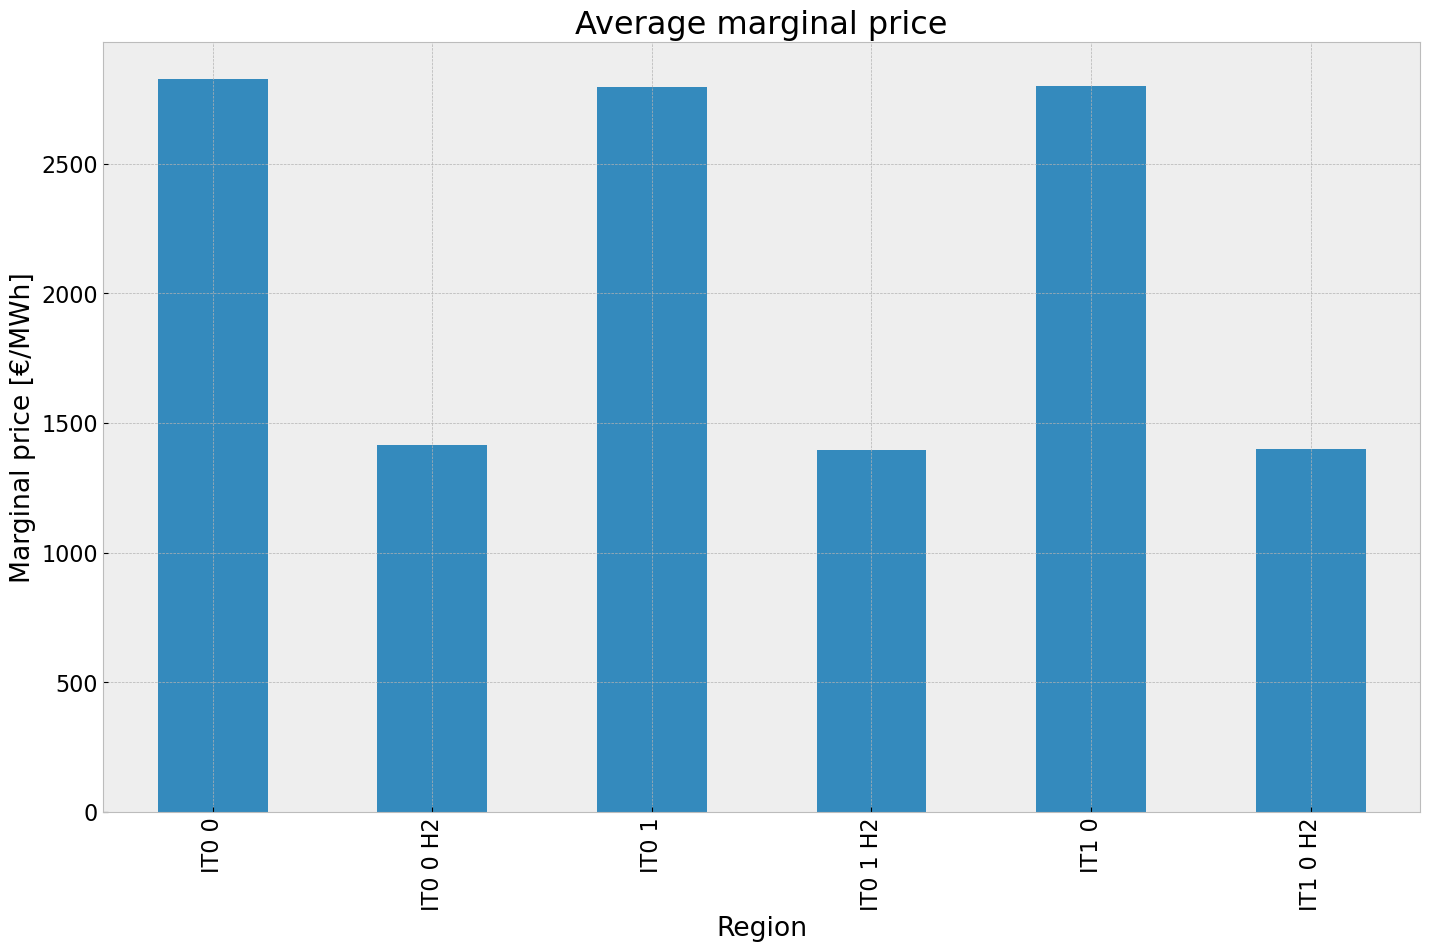

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


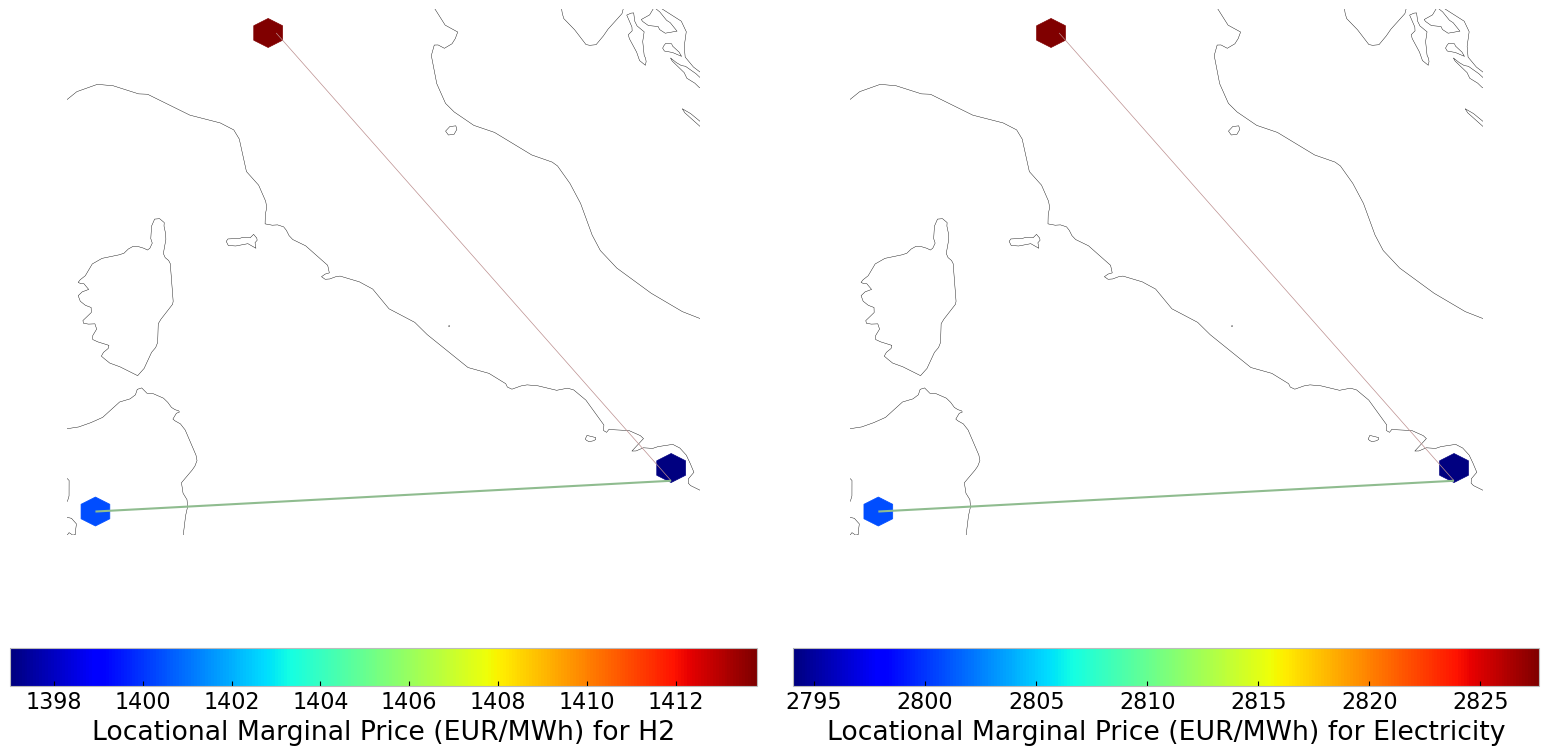

In [65]:
inst_store_table(n2)
state_of_charge_plot(n2)
n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3).loc[pd.date_range(start="2013-01-01", end="2013-12-31",freq='3H')].plot(figsize=(20,10))
price_dur_curve_plot(n2)
price_regions_table(n2)
price_regions(n2)


## 3. Scenario: rolling horizon foresight with no additional investment

In [66]:
n3= n2.copy()
n3.optimize.create_model()

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * StorageUnit-p_nom (StorageUnit-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * StorageUnit-spill (snapshot, StorageUnit)
 * Store-p (snapshot, Store)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * StorageUnit-ext-p_nom-lower (StorageUnit-ext)
 * StorageUnit-ext-p_nom-upper (StorageUnit-ext)
 * Generator-

In [67]:
optimize.optimize_with_rolling_horizon(n3, horizon=24, overlap=0,
                                       solver_name='gurobi')

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2013-01-01 00:00:00:2013-01-03 21:00:00] (1/122).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-h19jgkwj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-h19jgkwj.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8239 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8239 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8239 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8239 nonzeros


Model fingerprint: 0x06e303d6


INFO:gurobipy:Model fingerprint: 0x06e303d6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 908 columns


INFO:gurobipy:Presolve removed 3964 rows and 908 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     381    5.4378121e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     381    5.4378121e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 381 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 381 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.437812148e+09


INFO:gurobipy:Optimal objective  5.437812148e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.44e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2t8hmckz.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2t8hmckz.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 4420 rows, 2141 columns, 8245 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8245 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8245 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8245 nonzeros


Model fingerprint: 0x1178e8d2


INFO:gurobipy:Model fingerprint: 0x1178e8d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     346    5.4283456e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     346    5.4283456e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 346 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 346 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.428345551e+09


INFO:gurobipy:Optimal objective  5.428345551e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-e1q1k49c.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-e1q1k49c.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8212 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8212 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8212 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8212 nonzeros


Model fingerprint: 0x6d9a84ac


INFO:gurobipy:Model fingerprint: 0x6d9a84ac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     269    5.4668806e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     269    5.4668806e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 269 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 269 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.466880596e+09


INFO:gurobipy:Optimal objective  5.466880596e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-yiner_m5.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-yiner_m5.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8251 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8251 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8251 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8251 nonzeros


Model fingerprint: 0x34b40560


INFO:gurobipy:Model fingerprint: 0x34b40560


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 902 columns


INFO:gurobipy:Presolve removed 3964 rows and 902 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1239 columns, 2240 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1239 columns, 2240 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     302    5.4722199e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     302    5.4722199e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 302 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 302 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.472219910e+09


INFO:gurobipy:Optimal objective  5.472219910e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ubfbhh9_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ubfbhh9_.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x5e760099


INFO:gurobipy:Model fingerprint: 0x5e760099


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 903 columns


INFO:gurobipy:Presolve removed 3964 rows and 903 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     284    5.4797709e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     284    5.4797709e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 284 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 284 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.479770894e+09


INFO:gurobipy:Optimal objective  5.479770894e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qlbipaxw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qlbipaxw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8268 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8268 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8268 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8268 nonzeros


Model fingerprint: 0x20ea2058


INFO:gurobipy:Model fingerprint: 0x20ea2058


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 900 columns


INFO:gurobipy:Presolve removed 3964 rows and 900 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     282    5.4857473e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     282    5.4857473e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 282 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 282 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.485747331e+09


INFO:gurobipy:Optimal objective  5.485747331e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_jdxntw9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_jdxntw9.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0x92891312


INFO:gurobipy:Model fingerprint: 0x92891312


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     314    5.4713859e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     314    5.4713859e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 314 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 314 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.471385932e+09


INFO:gurobipy:Optimal objective  5.471385932e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rpgjzrun.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rpgjzrun.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0x7d3d2ce2


INFO:gurobipy:Model fingerprint: 0x7d3d2ce2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     265    5.4730581e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     265    5.4730581e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 265 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 265 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.473058137e+09


INFO:gurobipy:Optimal objective  5.473058137e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0hcvcy1a.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0hcvcy1a.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4420 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x8abca477


INFO:gurobipy:Model fingerprint: 0x8abca477


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     361    5.4417506e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     361    5.4417506e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 361 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 361 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.441750587e+09


INFO:gurobipy:Optimal objective  5.441750587e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.44e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8jku4sfg.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8jku4sfg.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8254 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8254 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8254 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8254 nonzeros


Model fingerprint: 0xb34f664f


INFO:gurobipy:Model fingerprint: 0xb34f664f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 900 columns


INFO:gurobipy:Presolve removed 3964 rows and 900 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     291    5.4735807e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     291    5.4735807e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 291 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 291 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.473580727e+09


INFO:gurobipy:Optimal objective  5.473580727e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-iann0xnx.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-iann0xnx.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0xf1ae0a23


INFO:gurobipy:Model fingerprint: 0xf1ae0a23


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     346    5.4544369e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     346    5.4544369e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 346 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 346 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.454436935e+09


INFO:gurobipy:Optimal objective  5.454436935e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bgtkos0k.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bgtkos0k.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0xced2d16b


INFO:gurobipy:Model fingerprint: 0xced2d16b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     352    5.4414688e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     352    5.4414688e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 352 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 352 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.441468784e+09


INFO:gurobipy:Optimal objective  5.441468784e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.44e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z1ao4x33.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z1ao4x33.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0xe8a80081


INFO:gurobipy:Model fingerprint: 0xe8a80081


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     300    5.4637070e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     300    5.4637070e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 300 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 300 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.463706969e+09


INFO:gurobipy:Optimal objective  5.463706969e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.46e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1zueoq7f.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1zueoq7f.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0xa8b3c587


INFO:gurobipy:Model fingerprint: 0xa8b3c587


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     357    5.4516928e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     357    5.4516928e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 357 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 357 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.451692775e+09


INFO:gurobipy:Optimal objective  5.451692775e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j3sd5no6.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j3sd5no6.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x76d840fd


INFO:gurobipy:Model fingerprint: 0x76d840fd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     287    5.4745801e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     287    5.4745801e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 287 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 287 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.474580124e+09


INFO:gurobipy:Optimal objective  5.474580124e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9f9w65x9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9f9w65x9.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8242 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8242 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8242 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8242 nonzeros


Model fingerprint: 0x69c31d19


INFO:gurobipy:Model fingerprint: 0x69c31d19


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     376    5.4341950e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     376    5.4341950e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 376 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 376 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.434194976e+09


INFO:gurobipy:Optimal objective  5.434194976e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-fvnp5gu2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-fvnp5gu2.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8254 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8254 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8254 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8254 nonzeros


Model fingerprint: 0x3d972875


INFO:gurobipy:Model fingerprint: 0x3d972875


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     264    5.4573986e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     264    5.4573986e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 264 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 264 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.457398648e+09


INFO:gurobipy:Optimal objective  5.457398648e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.46e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xvdh_z9g.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xvdh_z9g.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x231a626f


INFO:gurobipy:Model fingerprint: 0x231a626f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     270    5.4735350e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     270    5.4735350e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 270 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 270 iterations and 0.06 seconds (0.01 work units)


Optimal objective  5.473534964e+09


INFO:gurobipy:Optimal objective  5.473534964e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-avuivsdv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-avuivsdv.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 4420 rows, 2141 columns, 8268 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8268 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8268 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8268 nonzeros


Model fingerprint: 0x4720f1a5


INFO:gurobipy:Model fingerprint: 0x4720f1a5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     318    5.4478724e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     318    5.4478724e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 318 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 318 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.447872401e+09


INFO:gurobipy:Optimal objective  5.447872401e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9u_oimev.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9u_oimev.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8256 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8256 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8256 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8256 nonzeros


Model fingerprint: 0x373f9916


INFO:gurobipy:Model fingerprint: 0x373f9916


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     362    5.4479738e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     362    5.4479738e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 362 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 362 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.447973815e+09


INFO:gurobipy:Optimal objective  5.447973815e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_5d2n22u.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_5d2n22u.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8243 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8243 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8243 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8243 nonzeros


Model fingerprint: 0xae9f2544


INFO:gurobipy:Model fingerprint: 0xae9f2544


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 906 columns


INFO:gurobipy:Presolve removed 3964 rows and 906 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     323    5.4261744e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     323    5.4261744e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 323 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 323 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.426174360e+09


INFO:gurobipy:Optimal objective  5.426174360e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6uc8q04o.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6uc8q04o.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8271 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8271 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8271 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8271 nonzeros


Model fingerprint: 0x9974e1cd


INFO:gurobipy:Model fingerprint: 0x9974e1cd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     277    5.4824935e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     277    5.4824935e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 277 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 277 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.482493533e+09


INFO:gurobipy:Optimal objective  5.482493533e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0dbbfi32.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0dbbfi32.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8271 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8271 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8271 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8271 nonzeros


Model fingerprint: 0x697b1972


INFO:gurobipy:Model fingerprint: 0x697b1972


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     345    5.4287823e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     345    5.4287823e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 345 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 345 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.428782293e+09


INFO:gurobipy:Optimal objective  5.428782293e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1unfi_9r.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1unfi_9r.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8252 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8252 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8252 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8252 nonzeros


Model fingerprint: 0x113eecf9


INFO:gurobipy:Model fingerprint: 0x113eecf9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     330    5.4450674e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     330    5.4450674e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 330 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 330 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.445067450e+09


INFO:gurobipy:Optimal objective  5.445067450e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ipw5box.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ipw5box.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8270 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8270 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


Model fingerprint: 0x674d2970


INFO:gurobipy:Model fingerprint: 0x674d2970


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     312    5.4301940e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     312    5.4301940e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 312 iterations and 0.09 seconds (0.01 work units)


INFO:gurobipy:Solved in 312 iterations and 0.09 seconds (0.01 work units)


Optimal objective  5.430194025e+09


INFO:gurobipy:Optimal objective  5.430194025e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bojzljny.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bojzljny.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 4420 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0x8662ac29


INFO:gurobipy:Model fingerprint: 0x8662ac29


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     312    5.4335079e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     312    5.4335079e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 312 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 312 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.433507857e+09


INFO:gurobipy:Optimal objective  5.433507857e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-tecf9ikq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-tecf9ikq.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x7bf7d2b6


INFO:gurobipy:Model fingerprint: 0x7bf7d2b6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 900 columns


INFO:gurobipy:Presolve removed 3964 rows and 900 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     355    5.4284163e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     355    5.4284163e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 355 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 355 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.428416285e+09


INFO:gurobipy:Optimal objective  5.428416285e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vfowt57z.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vfowt57z.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 4420 rows, 2141 columns, 8270 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8270 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


Model fingerprint: 0xf4e2fe95


INFO:gurobipy:Model fingerprint: 0xf4e2fe95


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     325    5.4214810e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     325    5.4214810e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 325 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 325 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.421480966e+09


INFO:gurobipy:Optimal objective  5.421480966e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.42e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3x08oyk9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3x08oyk9.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8268 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8268 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8268 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8268 nonzeros


Model fingerprint: 0x63ec1a99


INFO:gurobipy:Model fingerprint: 0x63ec1a99


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     348    5.4498733e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     348    5.4498733e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 348 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 348 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.449873283e+09


INFO:gurobipy:Optimal objective  5.449873283e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9k9lke_a.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9k9lke_a.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0xa920683a


INFO:gurobipy:Model fingerprint: 0xa920683a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     309    5.4030863e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     309    5.4030863e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 309 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 309 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.403086281e+09


INFO:gurobipy:Optimal objective  5.403086281e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.40e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-e465rkgg.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-e465rkgg.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0x5cd0f2b8


INFO:gurobipy:Model fingerprint: 0x5cd0f2b8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     296    5.3992569e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     296    5.3992569e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 296 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 296 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.399256943e+09


INFO:gurobipy:Optimal objective  5.399256943e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.40e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9k28d5xp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9k28d5xp.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0xa0b4d452


INFO:gurobipy:Model fingerprint: 0xa0b4d452


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     280    5.4047451e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     280    5.4047451e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 280 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 280 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.404745050e+09


INFO:gurobipy:Optimal objective  5.404745050e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.40e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kbilhm3h.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kbilhm3h.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8271 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8271 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8271 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8271 nonzeros


Model fingerprint: 0x5cf1add6


INFO:gurobipy:Model fingerprint: 0x5cf1add6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     309    5.3985859e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     309    5.3985859e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 309 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 309 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.398585918e+09


INFO:gurobipy:Optimal objective  5.398585918e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.40e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-4mddryco.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-4mddryco.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8270 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8270 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


Model fingerprint: 0xc749397b


INFO:gurobipy:Model fingerprint: 0xc749397b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     294    5.4033076e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     294    5.4033076e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 294 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 294 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.403307622e+09


INFO:gurobipy:Optimal objective  5.403307622e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.40e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-10ky6oxo.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-10ky6oxo.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8226 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8226 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8226 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8226 nonzeros


Model fingerprint: 0xe1b988fa


INFO:gurobipy:Model fingerprint: 0xe1b988fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 905 columns


INFO:gurobipy:Presolve removed 3964 rows and 905 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     292    5.3867191e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     292    5.3867191e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 292 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 292 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.386719074e+09


INFO:gurobipy:Optimal objective  5.386719074e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.39e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-md48a4ey.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-md48a4ey.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8198 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8198 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8198 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8198 nonzeros


Model fingerprint: 0x9a4d11f4


INFO:gurobipy:Model fingerprint: 0x9a4d11f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 921 columns


INFO:gurobipy:Presolve removed 3964 rows and 921 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1220 columns, 2221 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1220 columns, 2221 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     274    5.3967872e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     274    5.3967872e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 274 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 274 iterations and 0.06 seconds (0.01 work units)


Optimal objective  5.396787219e+09


INFO:gurobipy:Optimal objective  5.396787219e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.40e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-a4fizgck.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-a4fizgck.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8257 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8257 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8257 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8257 nonzeros


Model fingerprint: 0x7f0d4c9f


INFO:gurobipy:Model fingerprint: 0x7f0d4c9f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     301    5.3867008e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     301    5.3867008e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 301 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 301 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.386700764e+09


INFO:gurobipy:Optimal objective  5.386700764e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.39e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6w4gn525.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6w4gn525.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8244 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8244 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8244 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8244 nonzeros


Model fingerprint: 0x6d9399a0


INFO:gurobipy:Model fingerprint: 0x6d9399a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     277    5.3975084e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     277    5.3975084e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 277 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 277 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.397508393e+09


INFO:gurobipy:Optimal objective  5.397508393e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.40e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uxy5i_9e.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uxy5i_9e.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 4420 rows, 2141 columns, 8262 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8262 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8262 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8262 nonzeros


Model fingerprint: 0x87b8408c


INFO:gurobipy:Model fingerprint: 0x87b8408c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 897 columns


INFO:gurobipy:Presolve removed 3964 rows and 897 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 456 rows, 1244 columns, 2245 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1244 columns, 2245 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     354    5.3833388e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     354    5.3833388e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 354 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 354 iterations and 0.06 seconds (0.01 work units)


Optimal objective  5.383338764e+09


INFO:gurobipy:Optimal objective  5.383338764e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.38e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-u4opmrke.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-u4opmrke.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8273 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8273 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8273 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8273 nonzeros


Model fingerprint: 0x71e6edf9


INFO:gurobipy:Model fingerprint: 0x71e6edf9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 897 columns


INFO:gurobipy:Presolve removed 3964 rows and 897 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 456 rows, 1244 columns, 2245 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1244 columns, 2245 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     329    5.3811057e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     329    5.3811057e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 329 iterations and 0.09 seconds (0.01 work units)


INFO:gurobipy:Solved in 329 iterations and 0.09 seconds (0.01 work units)


Optimal objective  5.381105742e+09


INFO:gurobipy:Optimal objective  5.381105742e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.38e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-c11a0kva.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-c11a0kva.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8234 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8234 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8234 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8234 nonzeros


Model fingerprint: 0x38b570d7


INFO:gurobipy:Model fingerprint: 0x38b570d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     228    5.3819796e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     228    5.3819796e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 228 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 228 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.381979619e+09


INFO:gurobipy:Optimal objective  5.381979619e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.38e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dce4thzh.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dce4thzh.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8259 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8259 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8259 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8259 nonzeros


Model fingerprint: 0x3ac8c871


INFO:gurobipy:Model fingerprint: 0x3ac8c871


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     239    5.3806653e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     239    5.3806653e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 239 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 239 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.380665266e+09


INFO:gurobipy:Optimal objective  5.380665266e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.38e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-v9wiaogd.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-v9wiaogd.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8225 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8225 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8225 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8225 nonzeros


Model fingerprint: 0xbc188a11


INFO:gurobipy:Model fingerprint: 0xbc188a11


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 905 columns


INFO:gurobipy:Presolve removed 3964 rows and 905 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     261    5.3908662e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     261    5.3908662e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 261 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 261 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.390866215e+09


INFO:gurobipy:Optimal objective  5.390866215e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.39e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kb1zk3y3.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kb1zk3y3.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0x05c214b2


INFO:gurobipy:Model fingerprint: 0x05c214b2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 896 columns


INFO:gurobipy:Presolve removed 3964 rows and 896 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1245 columns, 2246 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1245 columns, 2246 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     250    5.3810261e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     250    5.3810261e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 250 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 250 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.381026060e+09


INFO:gurobipy:Optimal objective  5.381026060e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.38e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5n3ya4xn.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5n3ya4xn.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0x35c52f60


INFO:gurobipy:Model fingerprint: 0x35c52f60


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 896 columns


INFO:gurobipy:Presolve removed 3964 rows and 896 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1245 columns, 2246 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1245 columns, 2246 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     307    5.3891348e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     307    5.3891348e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 307 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 307 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.389134826e+09


INFO:gurobipy:Optimal objective  5.389134826e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.39e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-owa7icbs.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-owa7icbs.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8275 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8275 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8275 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8275 nonzeros


Model fingerprint: 0xfa2068ca


INFO:gurobipy:Model fingerprint: 0xfa2068ca


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 895 columns


INFO:gurobipy:Presolve removed 3964 rows and 895 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1246 columns, 2247 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1246 columns, 2247 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     281    5.3947340e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     281    5.3947340e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 281 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 281 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.394734024e+09


INFO:gurobipy:Optimal objective  5.394734024e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.39e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jnfovefd.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jnfovefd.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8276 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8276 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8276 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8276 nonzeros


Model fingerprint: 0x87e21c4a


INFO:gurobipy:Model fingerprint: 0x87e21c4a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+02, 2e+09]


INFO:gurobipy:  Bounds range     [1e+02, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 892 columns


INFO:gurobipy:Presolve removed 3964 rows and 892 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1249 columns, 2250 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1249 columns, 2250 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     255    5.3824037e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     255    5.3824037e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 255 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 255 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.382403689e+09


INFO:gurobipy:Optimal objective  5.382403689e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.38e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ss3vws7j.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ss3vws7j.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8279 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8279 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8279 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8279 nonzeros


Model fingerprint: 0x99ef9814


INFO:gurobipy:Model fingerprint: 0x99ef9814


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 890 columns


INFO:gurobipy:Presolve removed 3964 rows and 890 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1251 columns, 2252 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1251 columns, 2252 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     250    5.3883095e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     250    5.3883095e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 250 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 250 iterations and 0.06 seconds (0.01 work units)


Optimal objective  5.388309454e+09


INFO:gurobipy:Optimal objective  5.388309454e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.39e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g765iwgl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g765iwgl.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8276 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8276 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8276 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8276 nonzeros


Model fingerprint: 0xc82318fa


INFO:gurobipy:Model fingerprint: 0xc82318fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 894 columns


INFO:gurobipy:Presolve removed 3964 rows and 894 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1247 columns, 2248 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1247 columns, 2248 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     270    5.3772024e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     270    5.3772024e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 270 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 270 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.377202353e+09


INFO:gurobipy:Optimal objective  5.377202353e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.38e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j3kfsllv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j3kfsllv.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8278 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8278 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8278 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8278 nonzeros


Model fingerprint: 0x856f5950


INFO:gurobipy:Model fingerprint: 0x856f5950


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 892 columns


INFO:gurobipy:Presolve removed 3964 rows and 892 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 456 rows, 1249 columns, 2250 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1249 columns, 2250 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     300    5.3883318e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     300    5.3883318e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 300 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 300 iterations and 0.06 seconds (0.01 work units)


Optimal objective  5.388331798e+09


INFO:gurobipy:Optimal objective  5.388331798e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.39e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bxxirx9y.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bxxirx9y.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8275 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8275 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8275 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8275 nonzeros


Model fingerprint: 0xd9ff8b8e


INFO:gurobipy:Model fingerprint: 0xd9ff8b8e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 890 columns


INFO:gurobipy:Presolve removed 3964 rows and 890 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 456 rows, 1251 columns, 2252 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1251 columns, 2252 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     303    5.4084892e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     303    5.4084892e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 303 iterations and 0.09 seconds (0.01 work units)


INFO:gurobipy:Solved in 303 iterations and 0.09 seconds (0.01 work units)


Optimal objective  5.408489235e+09


INFO:gurobipy:Optimal objective  5.408489235e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.41e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wpdg1tt0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wpdg1tt0.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8221 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8221 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8221 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8221 nonzeros


Model fingerprint: 0xd1d03d51


INFO:gurobipy:Model fingerprint: 0xd1d03d51


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     229    5.4573272e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     229    5.4573272e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 229 iterations and 0.05 seconds (0.00 work units)


INFO:gurobipy:Solved in 229 iterations and 0.05 seconds (0.00 work units)


Optimal objective  5.457327155e+09


INFO:gurobipy:Optimal objective  5.457327155e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.46e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wfwdsley.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wfwdsley.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8224 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8224 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8224 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8224 nonzeros


Model fingerprint: 0x791c8253


INFO:gurobipy:Model fingerprint: 0x791c8253


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 900 columns


INFO:gurobipy:Presolve removed 3964 rows and 900 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     285    5.4515292e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     285    5.4515292e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 285 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 285 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.451529198e+09


INFO:gurobipy:Optimal objective  5.451529198e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-me6yc3q4.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-me6yc3q4.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x26fc49b1


INFO:gurobipy:Model fingerprint: 0x26fc49b1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 891 columns


INFO:gurobipy:Presolve removed 3964 rows and 891 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1250 columns, 2251 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1250 columns, 2251 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     263    5.4436833e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     263    5.4436833e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 263 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 263 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.443683314e+09


INFO:gurobipy:Optimal objective  5.443683314e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.44e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6mkya4a1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6mkya4a1.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8244 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8244 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8244 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8244 nonzeros


Model fingerprint: 0xf9185702


INFO:gurobipy:Model fingerprint: 0xf9185702


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 903 columns


INFO:gurobipy:Presolve removed 3964 rows and 903 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     278    5.4651865e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     278    5.4651865e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 278 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 278 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.465186527e+09


INFO:gurobipy:Optimal objective  5.465186527e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j_kerm0d.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j_kerm0d.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8212 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8212 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8212 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8212 nonzeros


Model fingerprint: 0x33e4b504


INFO:gurobipy:Model fingerprint: 0x33e4b504


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 900 columns


INFO:gurobipy:Presolve removed 3964 rows and 900 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     284    5.4506448e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     284    5.4506448e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 284 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 284 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.450644753e+09


INFO:gurobipy:Optimal objective  5.450644753e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6tvp6752.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6tvp6752.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8229 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8229 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8229 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8229 nonzeros


Model fingerprint: 0xb382bb22


INFO:gurobipy:Model fingerprint: 0xb382bb22


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     263    5.4981913e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     263    5.4981913e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 263 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 263 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.498191299e+09


INFO:gurobipy:Optimal objective  5.498191299e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-i85abhjr.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-i85abhjr.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8274 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8274 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8274 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8274 nonzeros


Model fingerprint: 0xa6c23dea


INFO:gurobipy:Model fingerprint: 0xa6c23dea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 895 columns


INFO:gurobipy:Presolve removed 3964 rows and 895 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1246 columns, 2247 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1246 columns, 2247 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     272    5.4658740e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     272    5.4658740e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 272 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 272 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.465874045e+09


INFO:gurobipy:Optimal objective  5.465874045e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-pytwri2f.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-pytwri2f.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8275 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8275 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8275 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8275 nonzeros


Model fingerprint: 0x6e5671a3


INFO:gurobipy:Model fingerprint: 0x6e5671a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 892 columns


INFO:gurobipy:Presolve removed 3964 rows and 892 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1249 columns, 2250 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1249 columns, 2250 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     281    5.4799905e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     281    5.4799905e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 281 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 281 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.479990525e+09


INFO:gurobipy:Optimal objective  5.479990525e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-iz30oy3t.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-iz30oy3t.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x69d99fce


INFO:gurobipy:Model fingerprint: 0x69d99fce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 895 columns


INFO:gurobipy:Presolve removed 3964 rows and 895 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1246 columns, 2247 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1246 columns, 2247 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     306    5.4716036e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     306    5.4716036e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 306 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 306 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.471603637e+09


INFO:gurobipy:Optimal objective  5.471603637e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ynsyaq88.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ynsyaq88.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8241 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8241 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8241 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8241 nonzeros


Model fingerprint: 0x693f2157


INFO:gurobipy:Model fingerprint: 0x693f2157


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 900 columns


INFO:gurobipy:Presolve removed 3964 rows and 900 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     264    5.4731464e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     264    5.4731464e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 264 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 264 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.473146425e+09


INFO:gurobipy:Optimal objective  5.473146425e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g5o4lq71.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g5o4lq71.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8255 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8255 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8255 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8255 nonzeros


Model fingerprint: 0x42a412ab


INFO:gurobipy:Model fingerprint: 0x42a412ab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 897 columns


INFO:gurobipy:Presolve removed 3964 rows and 897 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1244 columns, 2245 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1244 columns, 2245 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     247    5.5034033e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     247    5.5034033e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 247 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 247 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.503403267e+09


INFO:gurobipy:Optimal objective  5.503403267e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-crzaict1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-crzaict1.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0x8360b52a


INFO:gurobipy:Model fingerprint: 0x8360b52a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 903 columns


INFO:gurobipy:Presolve removed 3964 rows and 903 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     262    5.4815846e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     262    5.4815846e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 262 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 262 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.481584580e+09


INFO:gurobipy:Optimal objective  5.481584580e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xnz857m4.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xnz857m4.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8226 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8226 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8226 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8226 nonzeros


Model fingerprint: 0xed04410e


INFO:gurobipy:Model fingerprint: 0xed04410e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 912 columns


INFO:gurobipy:Presolve removed 3964 rows and 912 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1229 columns, 2230 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1229 columns, 2230 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     264    5.5158962e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     264    5.5158962e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 264 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 264 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.515896189e+09


INFO:gurobipy:Optimal objective  5.515896189e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_bhhrbew.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_bhhrbew.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8217 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8217 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8217 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8217 nonzeros


Model fingerprint: 0x0a6a9358


INFO:gurobipy:Model fingerprint: 0x0a6a9358


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     263    5.4867319e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     263    5.4867319e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 263 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 263 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.486731858e+09


INFO:gurobipy:Optimal objective  5.486731858e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0del3rfu.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0del3rfu.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8238 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8238 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8238 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8238 nonzeros


Model fingerprint: 0x7721e01f


INFO:gurobipy:Model fingerprint: 0x7721e01f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 909 columns


INFO:gurobipy:Presolve removed 3964 rows and 909 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1232 columns, 2233 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1232 columns, 2233 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     267    5.5148214e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     267    5.5148214e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 267 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 267 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.514821412e+09


INFO:gurobipy:Optimal objective  5.514821412e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.51e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g2zhx5ah.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g2zhx5ah.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8200 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8200 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8200 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8200 nonzeros


Model fingerprint: 0xfa11dcfe


INFO:gurobipy:Model fingerprint: 0xfa11dcfe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 905 columns


INFO:gurobipy:Presolve removed 3964 rows and 905 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     268    5.5091876e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     268    5.5091876e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 268 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 268 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.509187607e+09


INFO:gurobipy:Optimal objective  5.509187607e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.51e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7x22y2xq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7x22y2xq.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8232 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8232 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8232 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8232 nonzeros


Model fingerprint: 0x5dfcb74c


INFO:gurobipy:Model fingerprint: 0x5dfcb74c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     256    5.5009136e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     256    5.5009136e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 256 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 256 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.500913633e+09


INFO:gurobipy:Optimal objective  5.500913633e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ea02gwad.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ea02gwad.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8194 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8194 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8194 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8194 nonzeros


Model fingerprint: 0x9129c515


INFO:gurobipy:Model fingerprint: 0x9129c515


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 913 columns


INFO:gurobipy:Presolve removed 3964 rows and 913 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1228 columns, 2229 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1228 columns, 2229 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     242    5.5300777e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     242    5.5300777e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 242 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 242 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.530077673e+09


INFO:gurobipy:Optimal objective  5.530077673e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.53e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-__bgn450.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-__bgn450.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8240 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8240 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8240 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8240 nonzeros


Model fingerprint: 0x1b0482e5


INFO:gurobipy:Model fingerprint: 0x1b0482e5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     270    5.5047826e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     270    5.5047826e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 270 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 270 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.504782599e+09


INFO:gurobipy:Optimal objective  5.504782599e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-le2e_6g0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-le2e_6g0.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x09686017


INFO:gurobipy:Model fingerprint: 0x09686017


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     293    5.5189783e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     293    5.5189783e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 293 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 293 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.518978308e+09


INFO:gurobipy:Optimal objective  5.518978308e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ib50ampw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ib50ampw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8210 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8210 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8210 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8210 nonzeros


Model fingerprint: 0x87f5a3e4


INFO:gurobipy:Model fingerprint: 0x87f5a3e4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 914 columns


INFO:gurobipy:Presolve removed 3964 rows and 914 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1227 columns, 2228 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1227 columns, 2228 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     328    5.4969814e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     328    5.4969814e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 328 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 328 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.496981422e+09


INFO:gurobipy:Optimal objective  5.496981422e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j4xo1fkb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j4xo1fkb.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8218 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8218 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8218 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8218 nonzeros


Model fingerprint: 0xa6ba9ba8


INFO:gurobipy:Model fingerprint: 0xa6ba9ba8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 908 columns


INFO:gurobipy:Presolve removed 3964 rows and 908 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     232    5.5172092e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     232    5.5172092e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 232 iterations and 0.05 seconds (0.00 work units)


INFO:gurobipy:Solved in 232 iterations and 0.05 seconds (0.00 work units)


Optimal objective  5.517209194e+09


INFO:gurobipy:Optimal objective  5.517209194e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rl65371w.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rl65371w.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x934d33b4


INFO:gurobipy:Model fingerprint: 0x934d33b4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     288    5.4906714e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     288    5.4906714e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 288 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 288 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.490671437e+09


INFO:gurobipy:Optimal objective  5.490671437e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5lb2gsy9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5lb2gsy9.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8212 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8212 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8212 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8212 nonzeros


Model fingerprint: 0xe2f7de49


INFO:gurobipy:Model fingerprint: 0xe2f7de49


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 911 columns


INFO:gurobipy:Presolve removed 3964 rows and 911 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1230 columns, 2231 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1230 columns, 2231 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     283    5.4654219e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     283    5.4654219e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 283 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 283 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.465421905e+09


INFO:gurobipy:Optimal objective  5.465421905e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xycdzamz.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xycdzamz.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8245 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8245 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8245 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8245 nonzeros


Model fingerprint: 0x9a6aa4db


INFO:gurobipy:Model fingerprint: 0x9a6aa4db


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     355    5.4589468e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     355    5.4589468e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 355 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 355 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.458946756e+09


INFO:gurobipy:Optimal objective  5.458946756e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.46e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_zfa5u5p.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_zfa5u5p.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8198 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8198 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8198 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8198 nonzeros


Model fingerprint: 0xeddc588c


INFO:gurobipy:Model fingerprint: 0xeddc588c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 913 columns


INFO:gurobipy:Presolve removed 3964 rows and 913 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1228 columns, 2229 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1228 columns, 2229 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     340    5.4690991e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     340    5.4690991e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 340 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 340 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.469099117e+09


INFO:gurobipy:Optimal objective  5.469099117e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-12rxm_wc.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-12rxm_wc.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8263 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8263 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8263 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8263 nonzeros


Model fingerprint: 0x4633c318


INFO:gurobipy:Model fingerprint: 0x4633c318


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 903 columns


INFO:gurobipy:Presolve removed 3964 rows and 903 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     268    5.4816484e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     268    5.4816484e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 268 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 268 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.481648433e+09


INFO:gurobipy:Optimal objective  5.481648433e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-4lrhdzeq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-4lrhdzeq.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8228 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8228 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8228 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8228 nonzeros


Model fingerprint: 0x27d32bb8


INFO:gurobipy:Model fingerprint: 0x27d32bb8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 908 columns


INFO:gurobipy:Presolve removed 3964 rows and 908 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     314    5.4729493e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     314    5.4729493e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 314 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 314 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.472949347e+09


INFO:gurobipy:Optimal objective  5.472949347e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jw74zreb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jw74zreb.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8245 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8245 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8245 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8245 nonzeros


Model fingerprint: 0x17e5bdbc


INFO:gurobipy:Model fingerprint: 0x17e5bdbc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     267    5.4924156e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     267    5.4924156e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 267 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 267 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.492415604e+09


INFO:gurobipy:Optimal objective  5.492415604e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3guqvvcn.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3guqvvcn.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8242 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8242 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8242 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8242 nonzeros


Model fingerprint: 0x0c91bcd8


INFO:gurobipy:Model fingerprint: 0x0c91bcd8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     294    5.4884261e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     294    5.4884261e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 294 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 294 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.488426118e+09


INFO:gurobipy:Optimal objective  5.488426118e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-51yf0xjw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-51yf0xjw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8225 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8225 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8225 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8225 nonzeros


Model fingerprint: 0xfb004bea


INFO:gurobipy:Model fingerprint: 0xfb004bea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 914 columns


INFO:gurobipy:Presolve removed 3964 rows and 914 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1227 columns, 2228 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1227 columns, 2228 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     248    5.4924475e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     248    5.4924475e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 248 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 248 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.492447527e+09


INFO:gurobipy:Optimal objective  5.492447527e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-s0yjbxns.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-s0yjbxns.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8198 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8198 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8198 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8198 nonzeros


Model fingerprint: 0x8a80d335


INFO:gurobipy:Model fingerprint: 0x8a80d335


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+01, 2e+09]


INFO:gurobipy:  Bounds range     [1e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 908 columns


INFO:gurobipy:Presolve removed 3964 rows and 908 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1233 columns, 2234 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     249    5.5218608e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     249    5.5218608e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 249 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 249 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.521860766e+09


INFO:gurobipy:Optimal objective  5.521860766e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-69w2xjuw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-69w2xjuw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8218 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8218 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8218 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8218 nonzeros


Model fingerprint: 0xe3768769


INFO:gurobipy:Model fingerprint: 0xe3768769


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+01, 2e+09]


INFO:gurobipy:  Bounds range     [1e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     248    5.4923870e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     248    5.4923870e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 248 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 248 iterations and 0.06 seconds (0.01 work units)


Optimal objective  5.492387002e+09


INFO:gurobipy:Optimal objective  5.492387002e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-pi3wz0vm.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-pi3wz0vm.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x1c2f439c


INFO:gurobipy:Model fingerprint: 0x1c2f439c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     287    5.5106217e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     287    5.5106217e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 287 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 287 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.510621723e+09


INFO:gurobipy:Optimal objective  5.510621723e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.51e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ijr4id9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ijr4id9.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8238 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8238 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8238 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8238 nonzeros


Model fingerprint: 0x45e4591d


INFO:gurobipy:Model fingerprint: 0x45e4591d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     269    5.4806978e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     269    5.4806978e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 269 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 269 iterations and 0.03 seconds (0.01 work units)


Optimal objective  5.480697759e+09


INFO:gurobipy:Optimal objective  5.480697759e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ir5_i2dp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ir5_i2dp.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8270 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8270 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8270 nonzeros


Model fingerprint: 0x7e593de0


INFO:gurobipy:Model fingerprint: 0x7e593de0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     308    5.5004792e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     308    5.5004792e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 308 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 308 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.500479237e+09


INFO:gurobipy:Optimal objective  5.500479237e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dqlq07xc.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dqlq07xc.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8236 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8236 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8236 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8236 nonzeros


Model fingerprint: 0x5468143c


INFO:gurobipy:Model fingerprint: 0x5468143c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 906 columns


INFO:gurobipy:Presolve removed 3964 rows and 906 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     283    5.4980702e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     283    5.4980702e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 283 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 283 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.498070165e+09


INFO:gurobipy:Optimal objective  5.498070165e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hse546fv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hse546fv.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8206 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8206 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8206 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8206 nonzeros


Model fingerprint: 0xec810318


INFO:gurobipy:Model fingerprint: 0xec810318


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+01, 2e+09]


INFO:gurobipy:  Bounds range     [1e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 917 columns


INFO:gurobipy:Presolve removed 3964 rows and 917 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1224 columns, 2225 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1224 columns, 2225 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     303    5.4912017e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     303    5.4912017e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 303 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 303 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.491201706e+09


INFO:gurobipy:Optimal objective  5.491201706e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dp_exivq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dp_exivq.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2123 columns, 8196 nonzeros


INFO:gurobipy:obj: 4420 rows, 2123 columns, 8196 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2123 columns and 8196 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2123 columns and 8196 nonzeros


Model fingerprint: 0x68cf63d5


INFO:gurobipy:Model fingerprint: 0x68cf63d5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+00, 2e+09]


INFO:gurobipy:  Bounds range     [4e+00, 2e+09]


  RHS range        [3e+00, 1e+09]


INFO:gurobipy:  RHS range        [3e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3976 rows and 944 columns


INFO:gurobipy:Presolve removed 3976 rows and 944 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 444 rows, 1179 columns, 2168 nonzeros


INFO:gurobipy:Presolved: 444 rows, 1179 columns, 2168 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     232    5.5178857e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     232    5.5178857e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 232 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 232 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.517885709e+09


INFO:gurobipy:Optimal objective  5.517885709e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2123 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bid10t_l.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bid10t_l.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2120 columns, 8236 nonzeros


INFO:gurobipy:obj: 4420 rows, 2120 columns, 8236 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2120 columns and 8236 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2120 columns and 8236 nonzeros


Model fingerprint: 0xc3af769a


INFO:gurobipy:Model fingerprint: 0xc3af769a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+00, 2e+09]


INFO:gurobipy:  Bounds range     [8e+00, 2e+09]


  RHS range        [6e+00, 1e+09]


INFO:gurobipy:  RHS range        [6e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3982 rows and 937 columns


INFO:gurobipy:Presolve removed 3982 rows and 937 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 438 rows, 1183 columns, 2166 nonzeros


INFO:gurobipy:Presolved: 438 rows, 1183 columns, 2166 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     266    5.4878832e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     266    5.4878832e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 266 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 266 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.487883173e+09


INFO:gurobipy:Optimal objective  5.487883173e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2120 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zd65ue6f.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zd65ue6f.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8260 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8260 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8260 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8260 nonzeros


Model fingerprint: 0x51cca154


INFO:gurobipy:Model fingerprint: 0x51cca154


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 903 columns


INFO:gurobipy:Presolve removed 3964 rows and 903 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1238 columns, 2239 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     330    5.5058296e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     330    5.5058296e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 330 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 330 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.505829619e+09


INFO:gurobipy:Optimal objective  5.505829619e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.51e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wd18xo46.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wd18xo46.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0x0f23095f


INFO:gurobipy:Model fingerprint: 0x0f23095f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     267    5.4806418e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     267    5.4806418e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 267 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 267 iterations and 0.03 seconds (0.01 work units)


Optimal objective  5.480641831e+09


INFO:gurobipy:Optimal objective  5.480641831e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3lyap2tv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3lyap2tv.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 4420 rows, 2141 columns, 8240 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8240 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8240 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8240 nonzeros


Model fingerprint: 0x715421e5


INFO:gurobipy:Model fingerprint: 0x715421e5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 905 columns


INFO:gurobipy:Presolve removed 3964 rows and 905 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     310    5.5016915e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     310    5.5016915e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 310 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 310 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.501691484e+09


INFO:gurobipy:Optimal objective  5.501691484e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8j0x4_sg.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8j0x4_sg.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x356e6ced


INFO:gurobipy:Model fingerprint: 0x356e6ced


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 902 columns


INFO:gurobipy:Presolve removed 3964 rows and 902 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1239 columns, 2240 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1239 columns, 2240 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     305    5.4854873e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     305    5.4854873e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 305 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 305 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.485487347e+09


INFO:gurobipy:Optimal objective  5.485487347e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-nwxrfu8w.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-nwxrfu8w.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8172 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8172 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8172 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8172 nonzeros


Model fingerprint: 0x28bb28bb


INFO:gurobipy:Model fingerprint: 0x28bb28bb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 911 columns


INFO:gurobipy:Presolve removed 3964 rows and 911 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1230 columns, 2231 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1230 columns, 2231 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     267    5.4804484e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     267    5.4804484e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 267 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 267 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.480448413e+09


INFO:gurobipy:Optimal objective  5.480448413e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-tcf8oc2y.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-tcf8oc2y.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8222 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8222 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8222 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8222 nonzeros


Model fingerprint: 0x3dd84f17


INFO:gurobipy:Model fingerprint: 0x3dd84f17


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     300    5.4999490e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     300    5.4999490e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 300 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 300 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.499949049e+09


INFO:gurobipy:Optimal objective  5.499949049e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5l_5tvaq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5l_5tvaq.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8257 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8257 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8257 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8257 nonzeros


Model fingerprint: 0x5a6b389f


INFO:gurobipy:Model fingerprint: 0x5a6b389f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     261    5.4811182e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     261    5.4811182e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 261 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 261 iterations and 0.03 seconds (0.01 work units)


Optimal objective  5.481118202e+09


INFO:gurobipy:Optimal objective  5.481118202e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bfmihfxr.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bfmihfxr.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8258 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8258 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8258 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8258 nonzeros


Model fingerprint: 0xdc38a9ca


INFO:gurobipy:Model fingerprint: 0xdc38a9ca


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     243    5.5031232e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     243    5.5031232e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 243 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 243 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.503123224e+09


INFO:gurobipy:Optimal objective  5.503123224e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jcyfghd1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jcyfghd1.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8215 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8215 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8215 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8215 nonzeros


Model fingerprint: 0x6fb5b14f


INFO:gurobipy:Model fingerprint: 0x6fb5b14f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     321    5.4644883e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     321    5.4644883e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 321 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 321 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.464488254e+09


INFO:gurobipy:Optimal objective  5.464488254e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.46e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-849odyef.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-849odyef.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0xe0543d59


INFO:gurobipy:Model fingerprint: 0xe0543d59


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 898 columns


INFO:gurobipy:Presolve removed 3964 rows and 898 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1243 columns, 2244 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     230    5.4856311e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     230    5.4856311e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 230 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 230 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.485631071e+09


INFO:gurobipy:Optimal objective  5.485631071e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xt7gm3gq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xt7gm3gq.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8240 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8240 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8240 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8240 nonzeros


Model fingerprint: 0xd0254127


INFO:gurobipy:Model fingerprint: 0xd0254127


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     257    5.4656030e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     257    5.4656030e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 257 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 257 iterations and 0.03 seconds (0.01 work units)


Optimal objective  5.465602971e+09


INFO:gurobipy:Optimal objective  5.465602971e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.47e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dg7hyic5.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dg7hyic5.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x7707380c


INFO:gurobipy:Model fingerprint: 0x7707380c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 900 columns


INFO:gurobipy:Presolve removed 3964 rows and 900 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1241 columns, 2242 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     284    5.4750959e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     284    5.4750959e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 284 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 284 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.475095886e+09


INFO:gurobipy:Optimal objective  5.475095886e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-70fnzvdm.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-70fnzvdm.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x3f79f6f0


INFO:gurobipy:Model fingerprint: 0x3f79f6f0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 899 columns


INFO:gurobipy:Presolve removed 3964 rows and 899 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1242 columns, 2243 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     247    5.5047034e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     247    5.5047034e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 247 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 247 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.504703419e+09


INFO:gurobipy:Optimal objective  5.504703419e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-q64ebq96.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-q64ebq96.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x173a6a21


INFO:gurobipy:Model fingerprint: 0x173a6a21


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 901 columns


INFO:gurobipy:Presolve removed 3964 rows and 901 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1240 columns, 2241 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     288    5.4764084e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     288    5.4764084e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 288 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 288 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.476408396e+09


INFO:gurobipy:Optimal objective  5.476408396e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6483d67j.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6483d67j.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x0d1d68ef


INFO:gurobipy:Model fingerprint: 0x0d1d68ef


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     267    5.5027397e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     267    5.5027397e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 267 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 267 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.502739668e+09


INFO:gurobipy:Optimal objective  5.502739668e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-240z4qo1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-240z4qo1.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0x01ca6f2f


INFO:gurobipy:Model fingerprint: 0x01ca6f2f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     234    5.4786118e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     234    5.4786118e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 234 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 234 iterations and 0.05 seconds (0.01 work units)


Optimal objective  5.478611763e+09


INFO:gurobipy:Optimal objective  5.478611763e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vooxrpkf.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vooxrpkf.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x20e4f786


INFO:gurobipy:Model fingerprint: 0x20e4f786


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 906 columns


INFO:gurobipy:Presolve removed 3964 rows and 906 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     236    5.5022597e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     236    5.5022597e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 236 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 236 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.502259718e+09


INFO:gurobipy:Optimal objective  5.502259718e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xs8h0zcq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xs8h0zcq.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0x4295e33a


INFO:gurobipy:Model fingerprint: 0x4295e33a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     286    5.4980559e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     286    5.4980559e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 286 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 286 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.498055878e+09


INFO:gurobipy:Optimal objective  5.498055878e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xmycz6ak.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xmycz6ak.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 4420 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0xe4c8b933


INFO:gurobipy:Model fingerprint: 0xe4c8b933


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     245    5.4914463e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     245    5.4914463e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 245 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 245 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.491446286e+09


INFO:gurobipy:Optimal objective  5.491446286e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rc6m1bjm.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rc6m1bjm.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8253 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8253 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8253 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8253 nonzeros


Model fingerprint: 0x2ce4250c


INFO:gurobipy:Model fingerprint: 0x2ce4250c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 906 columns


INFO:gurobipy:Presolve removed 3964 rows and 906 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1235 columns, 2236 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     250    5.5249969e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     250    5.5249969e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 250 iterations and 0.08 seconds (0.01 work units)


INFO:gurobipy:Solved in 250 iterations and 0.08 seconds (0.01 work units)


Optimal objective  5.524996892e+09


INFO:gurobipy:Optimal objective  5.524996892e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xmryg9n2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xmryg9n2.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0x353191bc


INFO:gurobipy:Model fingerprint: 0x353191bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 905 columns


INFO:gurobipy:Presolve removed 3964 rows and 905 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     290    5.4916255e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     290    5.4916255e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 290 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 290 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.491625546e+09


INFO:gurobipy:Optimal objective  5.491625546e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-e0auspy9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-e0auspy9.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 4420 rows, 2141 columns, 8226 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8226 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8226 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8226 nonzeros


Model fingerprint: 0xb82a3dc1


INFO:gurobipy:Model fingerprint: 0xb82a3dc1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 917 columns


INFO:gurobipy:Presolve removed 3964 rows and 917 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1224 columns, 2225 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1224 columns, 2225 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     249    5.5091855e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     249    5.5091855e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 249 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 249 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.509185493e+09


INFO:gurobipy:Optimal objective  5.509185493e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.51e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kes09dy7.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kes09dy7.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8243 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8243 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8243 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8243 nonzeros


Model fingerprint: 0xdb83ffe1


INFO:gurobipy:Model fingerprint: 0xdb83ffe1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 907 columns


INFO:gurobipy:Presolve removed 3964 rows and 907 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1234 columns, 2235 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     246    5.4863663e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     246    5.4863663e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 246 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 246 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.486366335e+09


INFO:gurobipy:Optimal objective  5.486366335e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.49e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3zrgrlez.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3zrgrlez.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8182 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8182 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8182 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8182 nonzeros


Model fingerprint: 0x7efdd9dc


INFO:gurobipy:Model fingerprint: 0x7efdd9dc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 926 columns


INFO:gurobipy:Presolve removed 3964 rows and 926 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1215 columns, 2216 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1215 columns, 2216 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     225    5.5206353e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     225    5.5206353e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 225 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 225 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.520635293e+09


INFO:gurobipy:Optimal objective  5.520635293e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g2zvv12y.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-g2zvv12y.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8180 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8180 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8180 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8180 nonzeros


Model fingerprint: 0x23216610


INFO:gurobipy:Model fingerprint: 0x23216610


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 924 columns


INFO:gurobipy:Presolve removed 3964 rows and 924 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1217 columns, 2218 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1217 columns, 2218 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     257    5.5161895e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     257    5.5161895e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 257 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 257 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.516189478e+09


INFO:gurobipy:Optimal objective  5.516189478e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uewgm3t1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uewgm3t1.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4420 rows, 2141 columns, 8232 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8232 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8232 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8232 nonzeros


Model fingerprint: 0x1a13ccd4


INFO:gurobipy:Model fingerprint: 0x1a13ccd4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 909 columns


INFO:gurobipy:Presolve removed 3964 rows and 909 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1232 columns, 2233 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1232 columns, 2233 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     246    5.5049429e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     246    5.5049429e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 246 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 246 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.504942949e+09


INFO:gurobipy:Optimal objective  5.504942949e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.50e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-fz0exbvl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-fz0exbvl.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8222 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8222 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8222 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8222 nonzeros


Model fingerprint: 0x36da760c


INFO:gurobipy:Model fingerprint: 0x36da760c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 905 columns


INFO:gurobipy:Presolve removed 3964 rows and 905 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1236 columns, 2237 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     254    5.5207880e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     254    5.5207880e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 254 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 254 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.520787962e+09


INFO:gurobipy:Optimal objective  5.520787962e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.52e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jiz7031u.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-jiz7031u.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8221 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8221 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8221 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8221 nonzeros


Model fingerprint: 0x159a0c4d


INFO:gurobipy:Model fingerprint: 0x159a0c4d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 910 columns


INFO:gurobipy:Presolve removed 3964 rows and 910 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 456 rows, 1231 columns, 2232 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1231 columns, 2232 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     265    5.4832509e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     265    5.4832509e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 265 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 265 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.483250881e+09


INFO:gurobipy:Optimal objective  5.483250881e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_cr_ogh7.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-_cr_ogh7.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x911399c4


INFO:gurobipy:Model fingerprint: 0x911399c4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     308    5.4540878e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     308    5.4540878e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 308 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 308 iterations and 0.03 seconds (0.01 work units)


Optimal objective  5.454087816e+09


INFO:gurobipy:Optimal objective  5.454087816e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wko15ln5.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-wko15ln5.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4420 rows, 2141 columns, 8252 nonzeros


INFO:gurobipy:obj: 4420 rows, 2141 columns, 8252 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4420 rows, 2141 columns and 8252 nonzeros


INFO:gurobipy:Optimize a model with 4420 rows, 2141 columns and 8252 nonzeros


Model fingerprint: 0x84584c51


INFO:gurobipy:Model fingerprint: 0x84584c51


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3964 rows and 904 columns


INFO:gurobipy:Presolve removed 3964 rows and 904 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:Presolved: 456 rows, 1237 columns, 2238 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     281    5.4511767e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     281    5.4511767e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 281 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 281 iterations and 0.04 seconds (0.01 work units)


Optimal objective  5.451176673e+09


INFO:gurobipy:Optimal objective  5.451176673e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4420 duals
Objective: 5.45e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-njt30o5x.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-njt30o5x.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 2964 rows, 1437 columns, 5523 nonzeros


INFO:gurobipy:obj: 2964 rows, 1437 columns, 5523 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 2964 rows, 1437 columns and 5523 nonzeros


INFO:gurobipy:Optimize a model with 2964 rows, 1437 columns and 5523 nonzeros


Model fingerprint: 0xa63d3d5e


INFO:gurobipy:Model fingerprint: 0xa63d3d5e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 2660 rows and 609 columns


INFO:gurobipy:Presolve removed 2660 rows and 609 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 304 rows, 828 columns, 1493 nonzeros


INFO:gurobipy:Presolved: 304 rows, 828 columns, 1493 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     185    5.4264856e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     185    5.4264856e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 185 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 185 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.426485587e+09


INFO:gurobipy:Optimal objective  5.426485587e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1437 primals, 2964 duals
Objective: 5.43e+09
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

PyPSA Network
Components:
 - Bus: 6
 - Carrier: 23
 - Generator: 44
 - GlobalConstraint: 2
 - Line: 1
 - Link: 7
 - Load: 3
 - StorageUnit: 9
 - Store: 3
 - SubNetwork: 1
Snapshots: 2920

In [68]:
tot_cos_noinv_roll=n3.objective/1e9 #billion €
system_cost_noinv_roll = system_cost(n3) #million €/a
marg_price_region_noinv_roll = n3.buses_t.marginal_price.mean()
stat_noinv_roll = n3.statistics()

<Figure size 640x480 with 0 Axes>

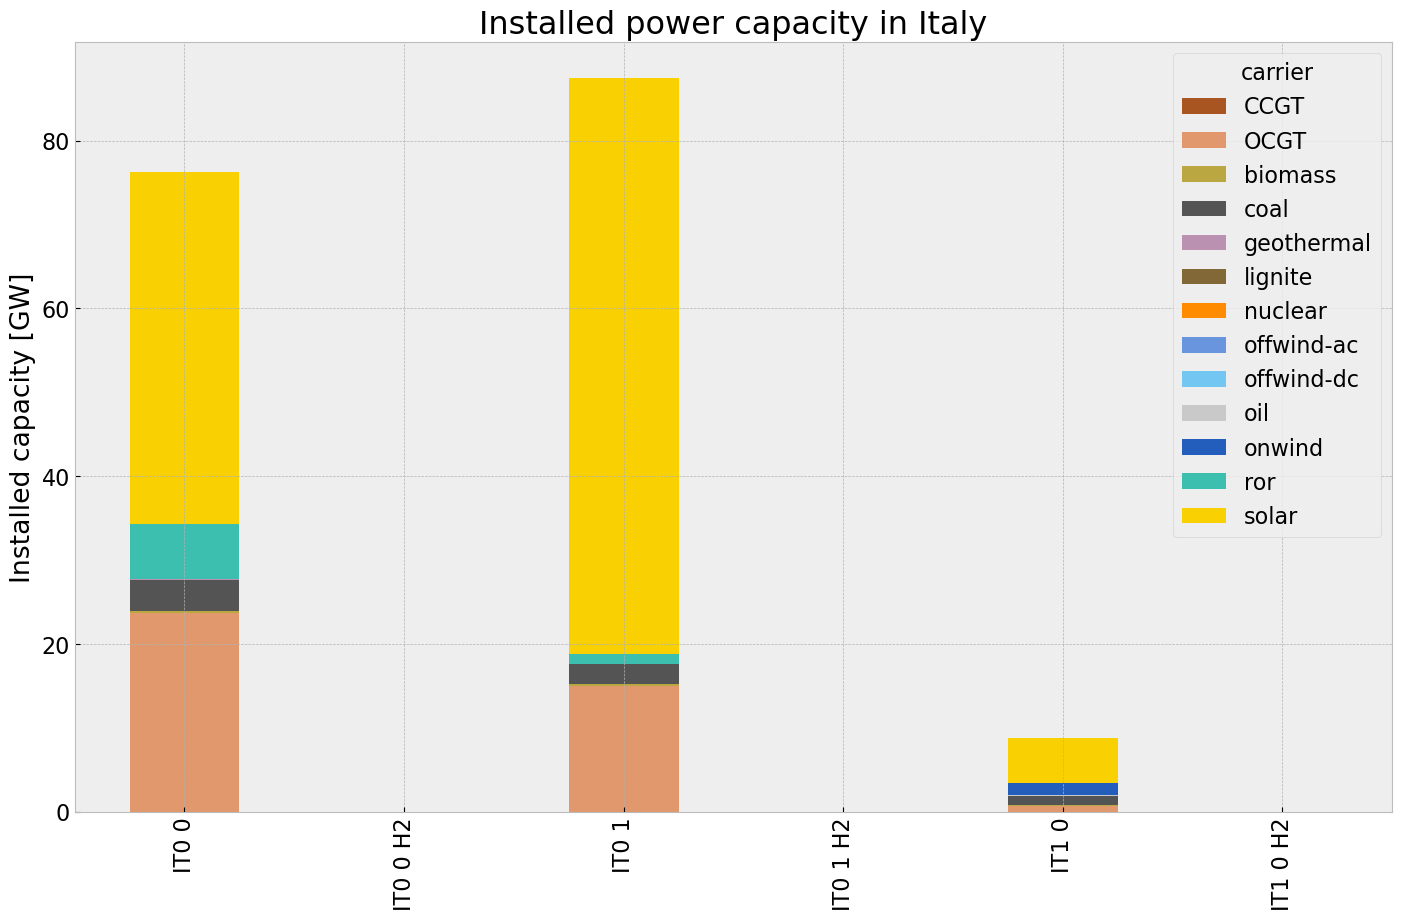

<Figure size 640x480 with 0 Axes>

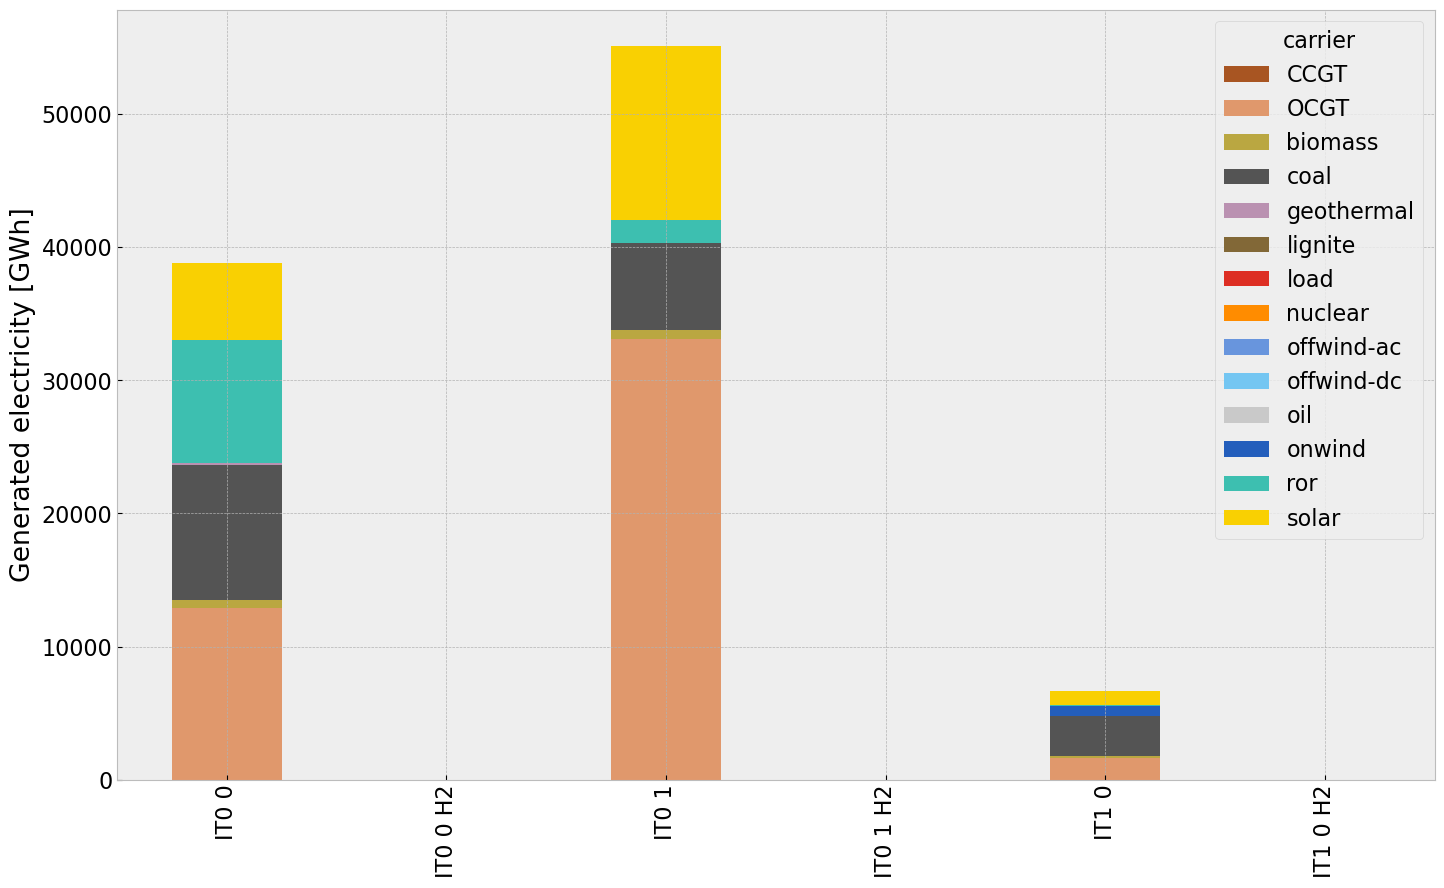

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3003674314.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p = n3.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3003674314.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n3.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\1422613485.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carri

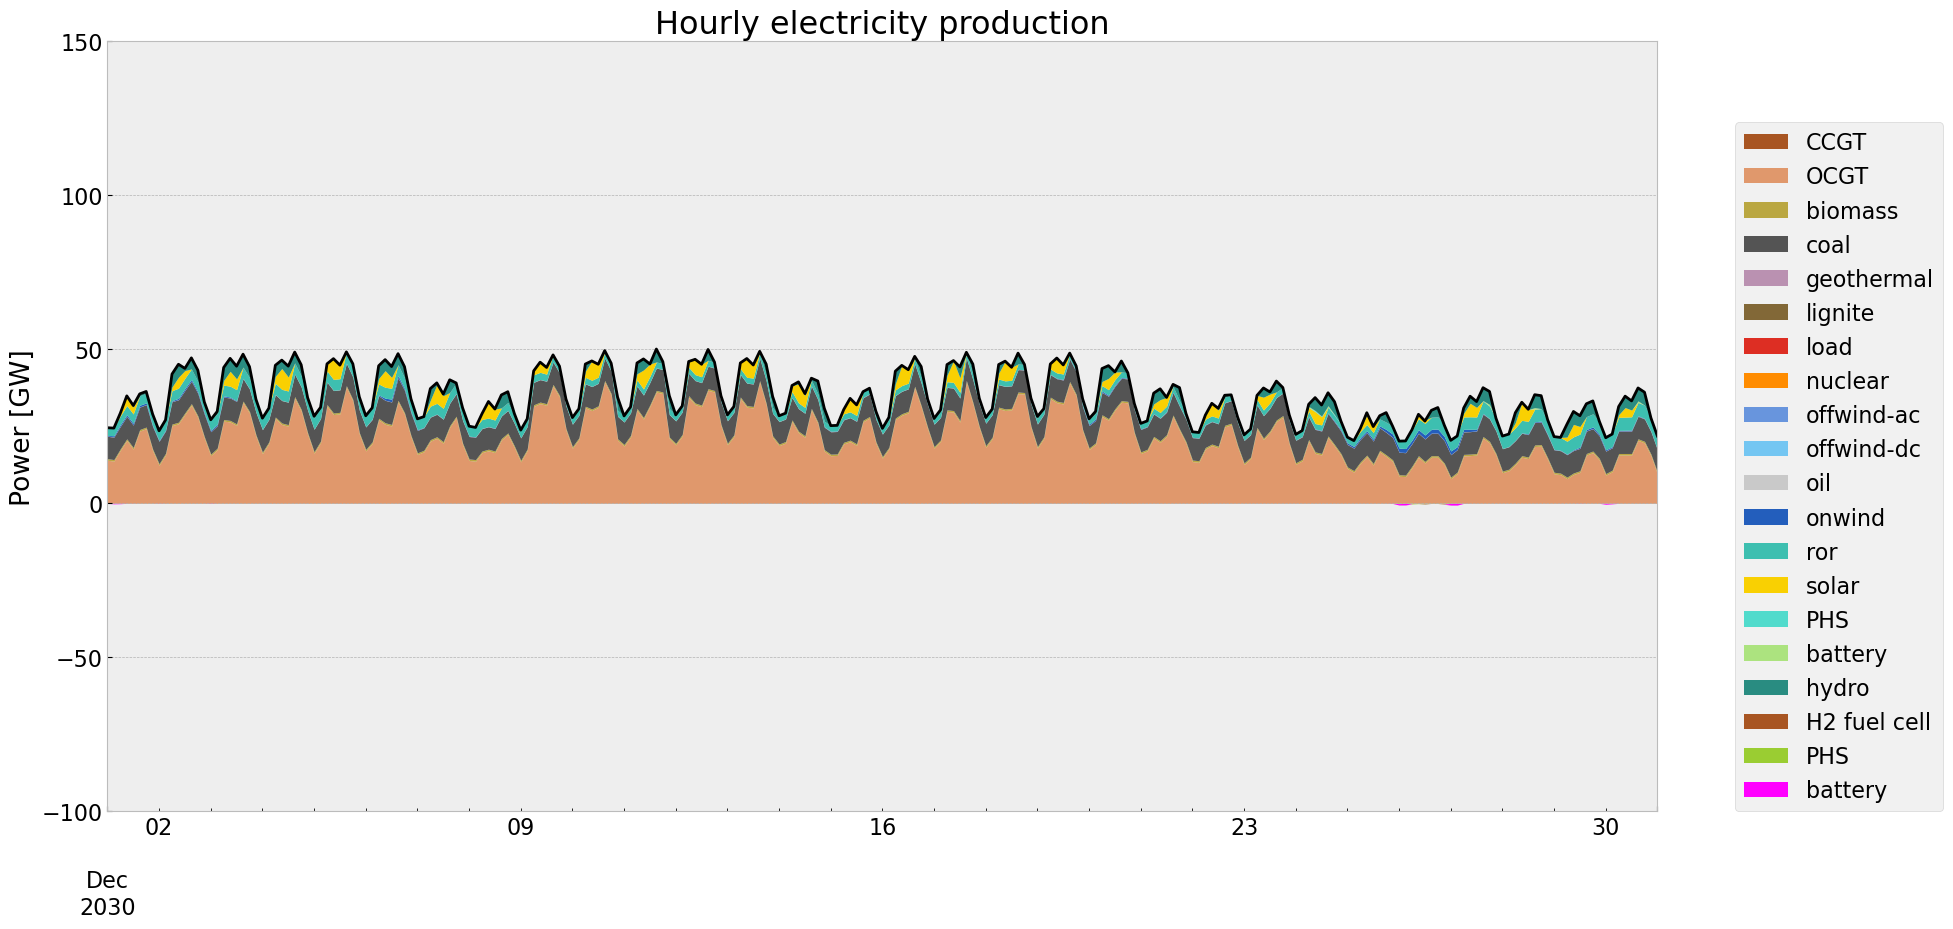

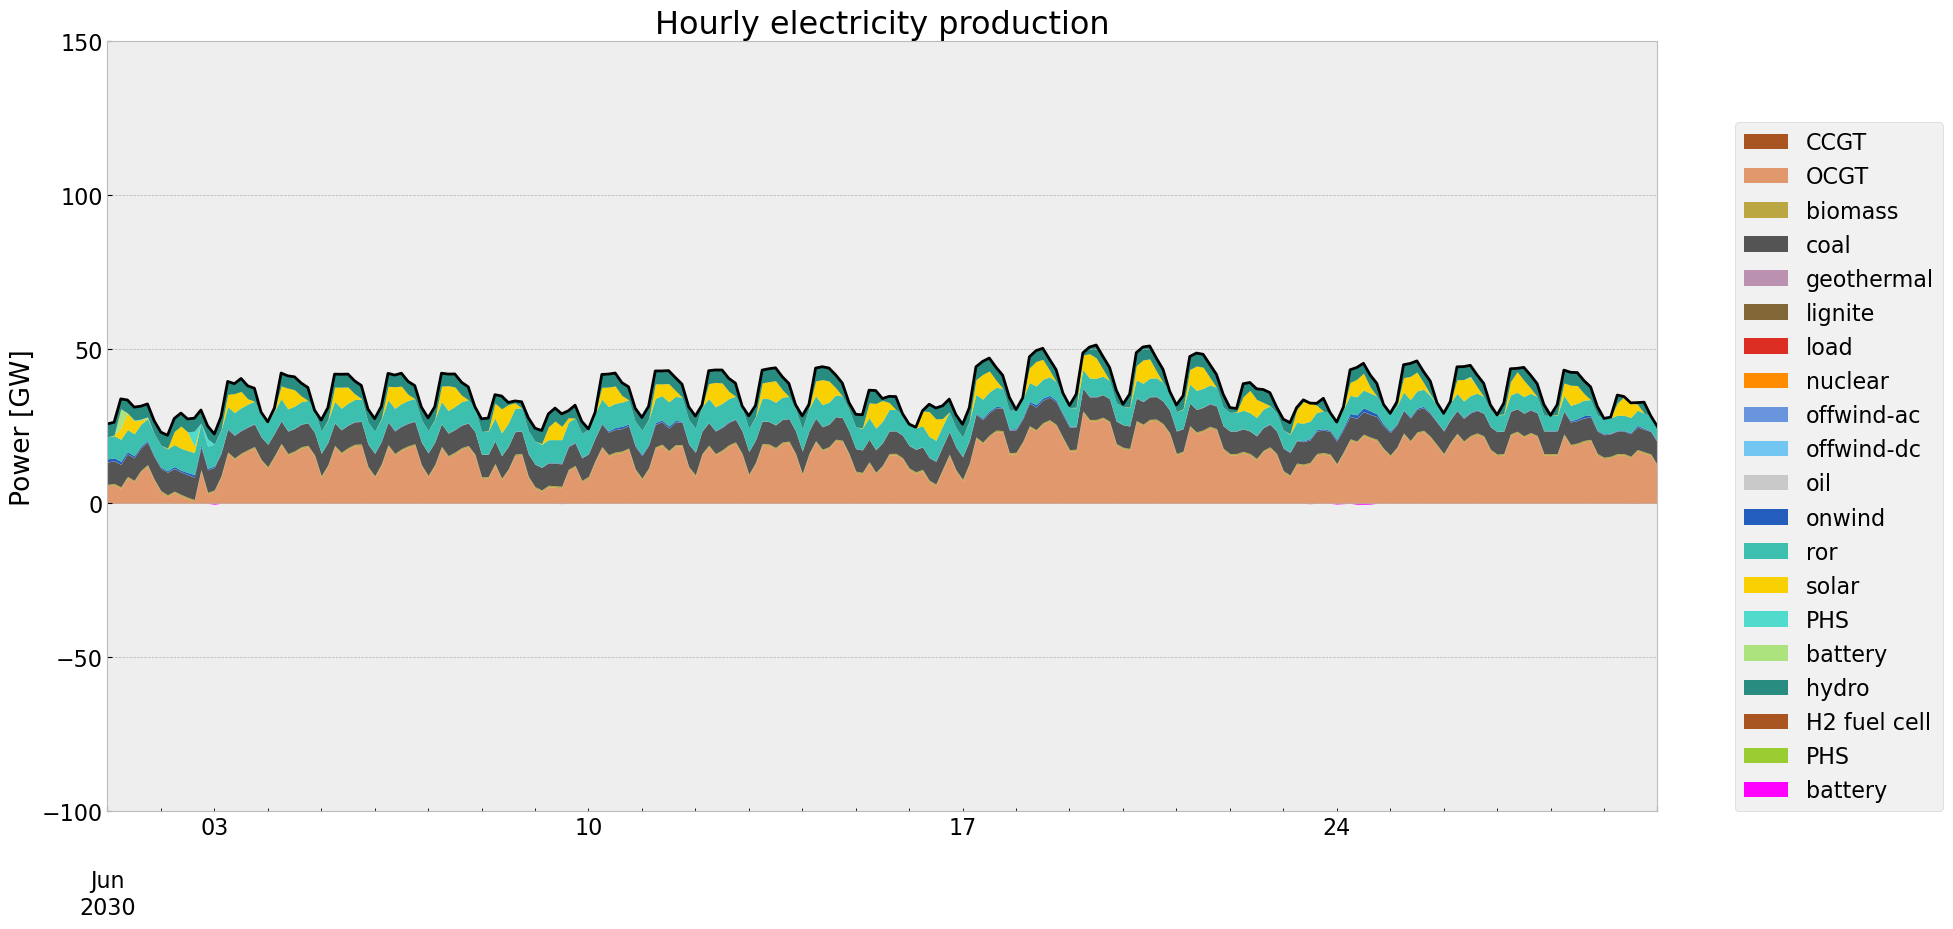

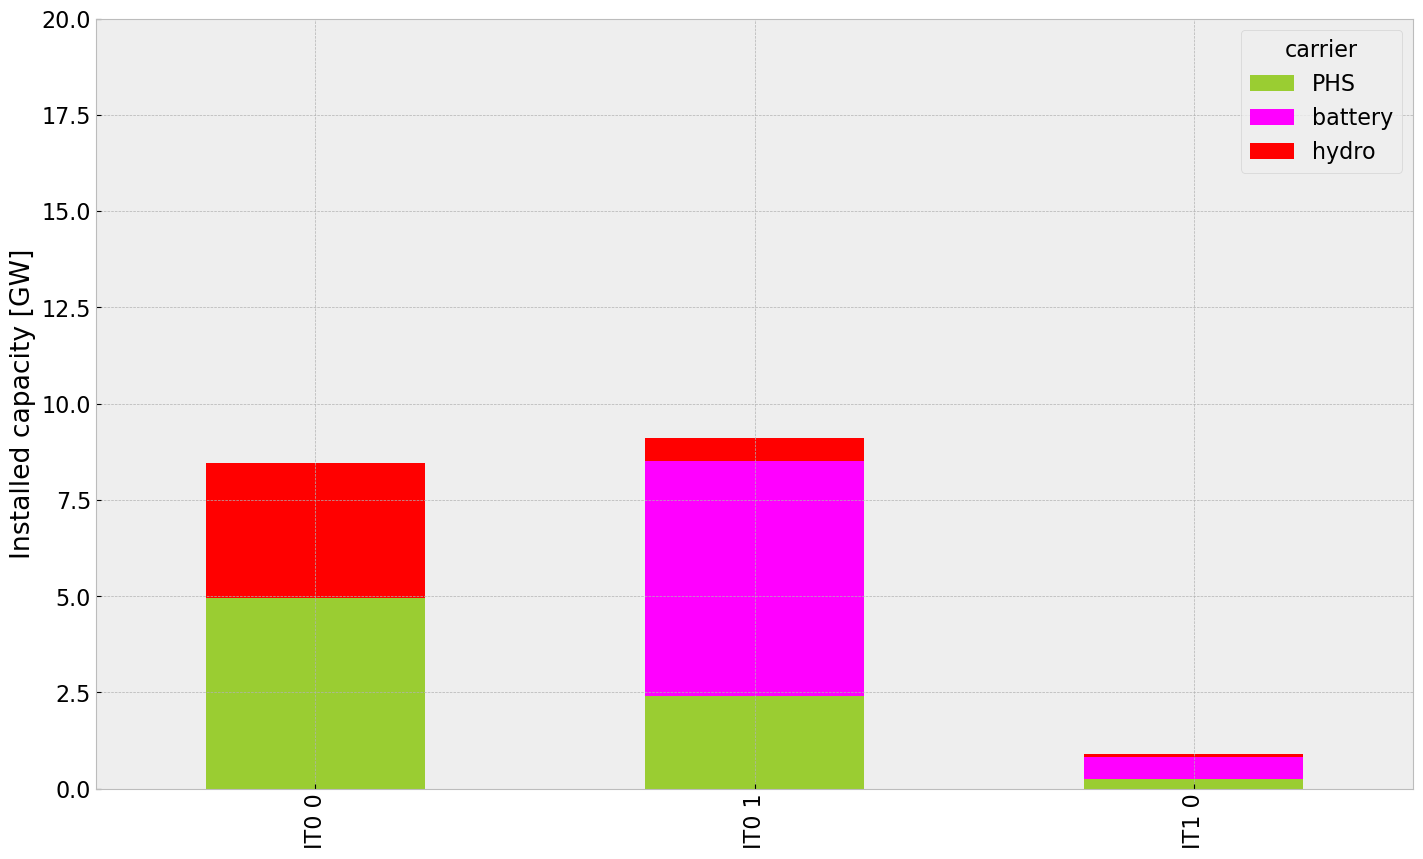

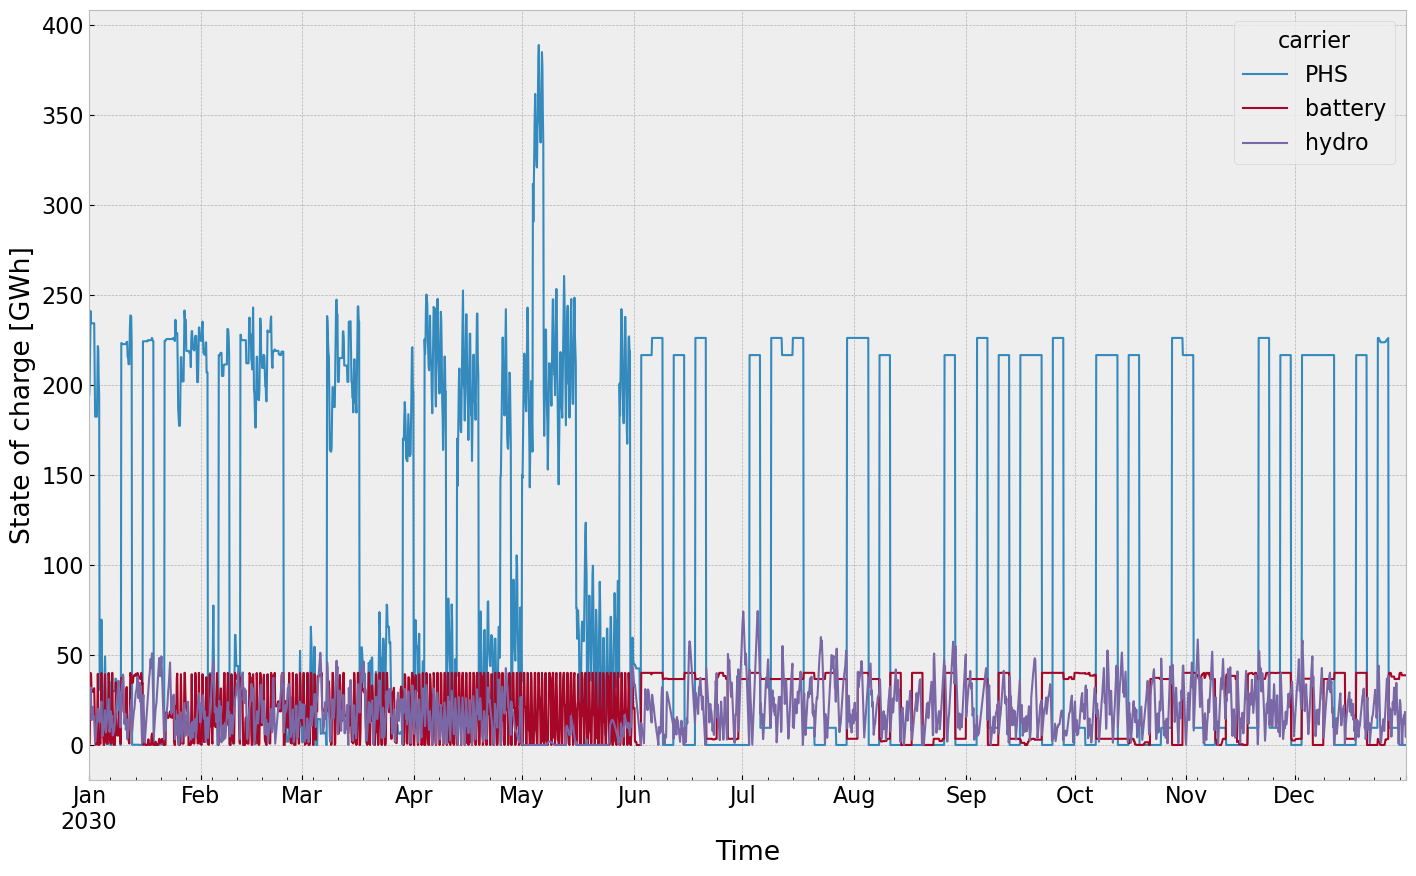

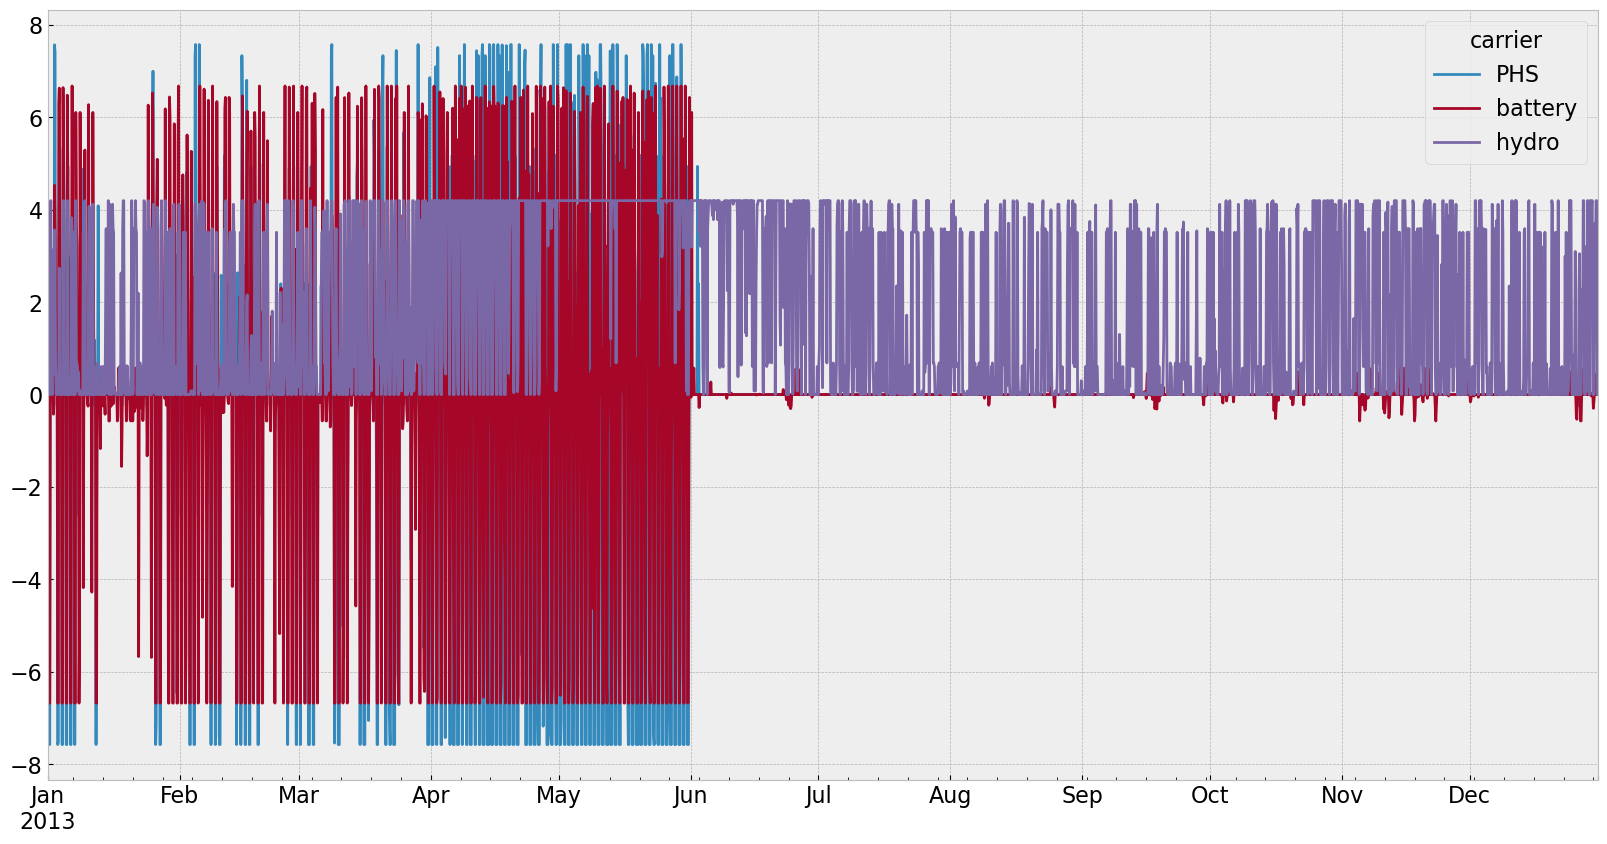

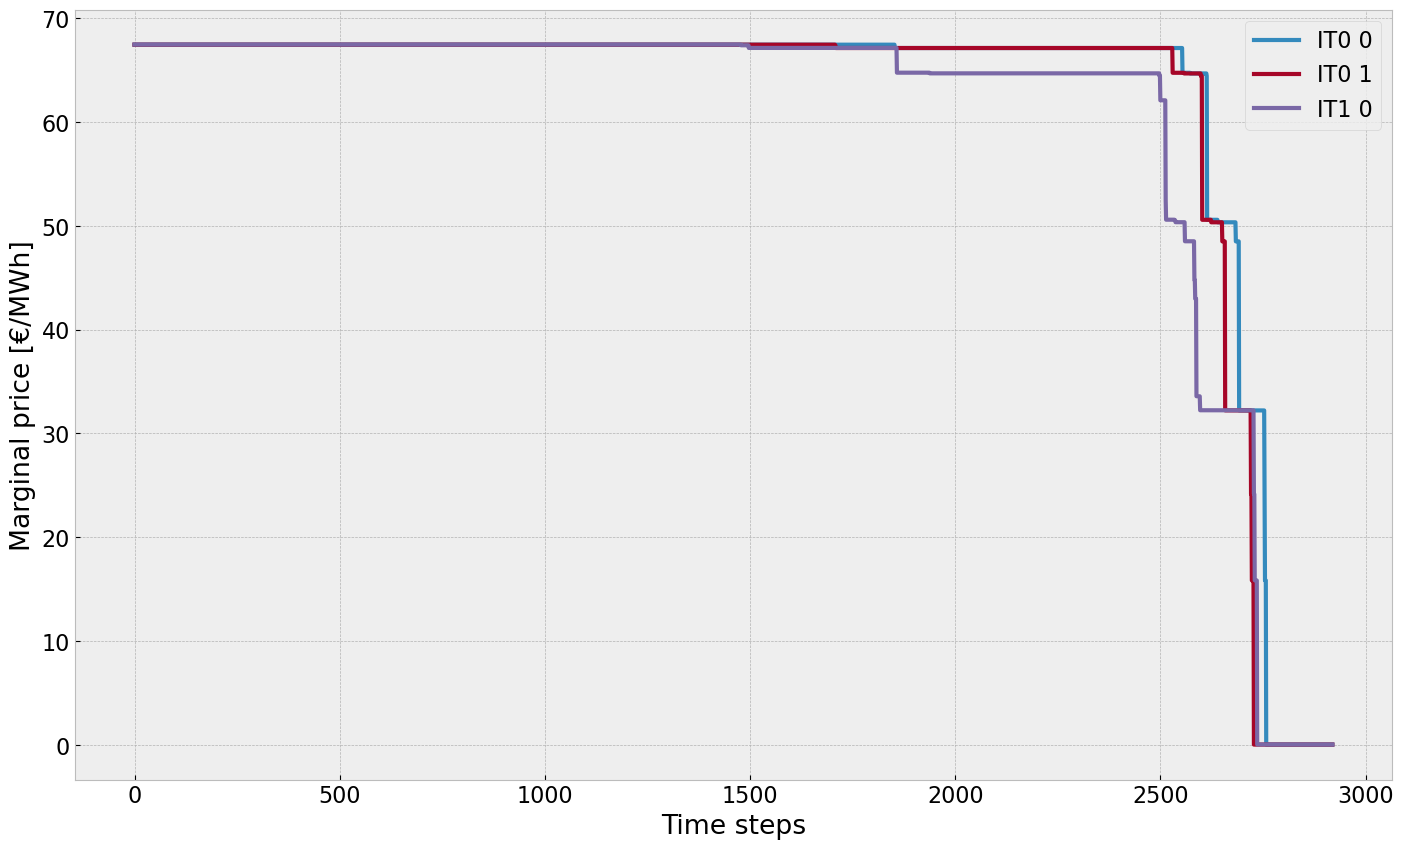

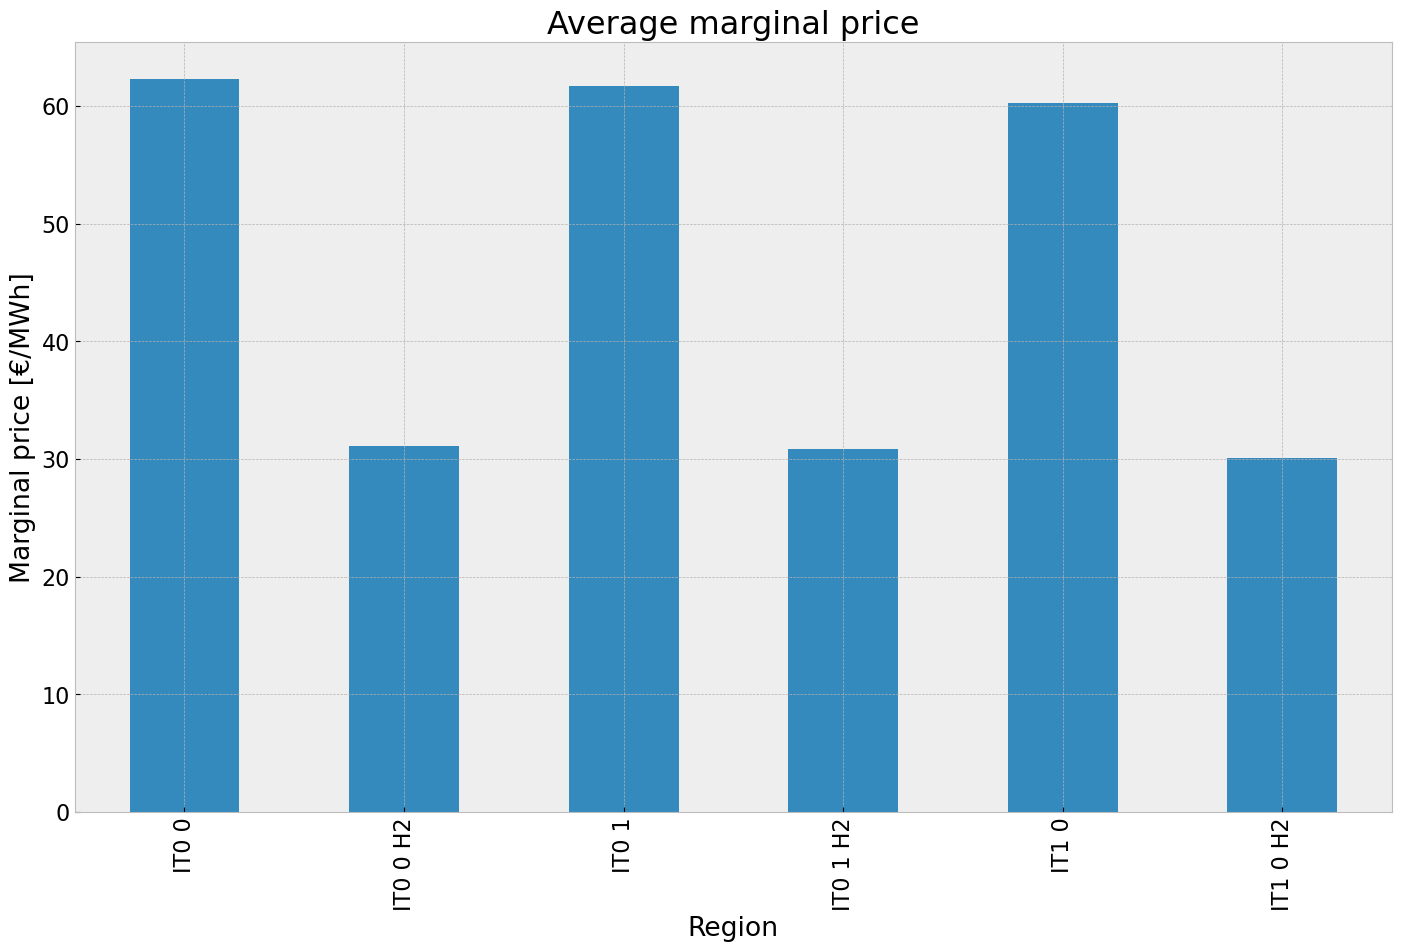

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


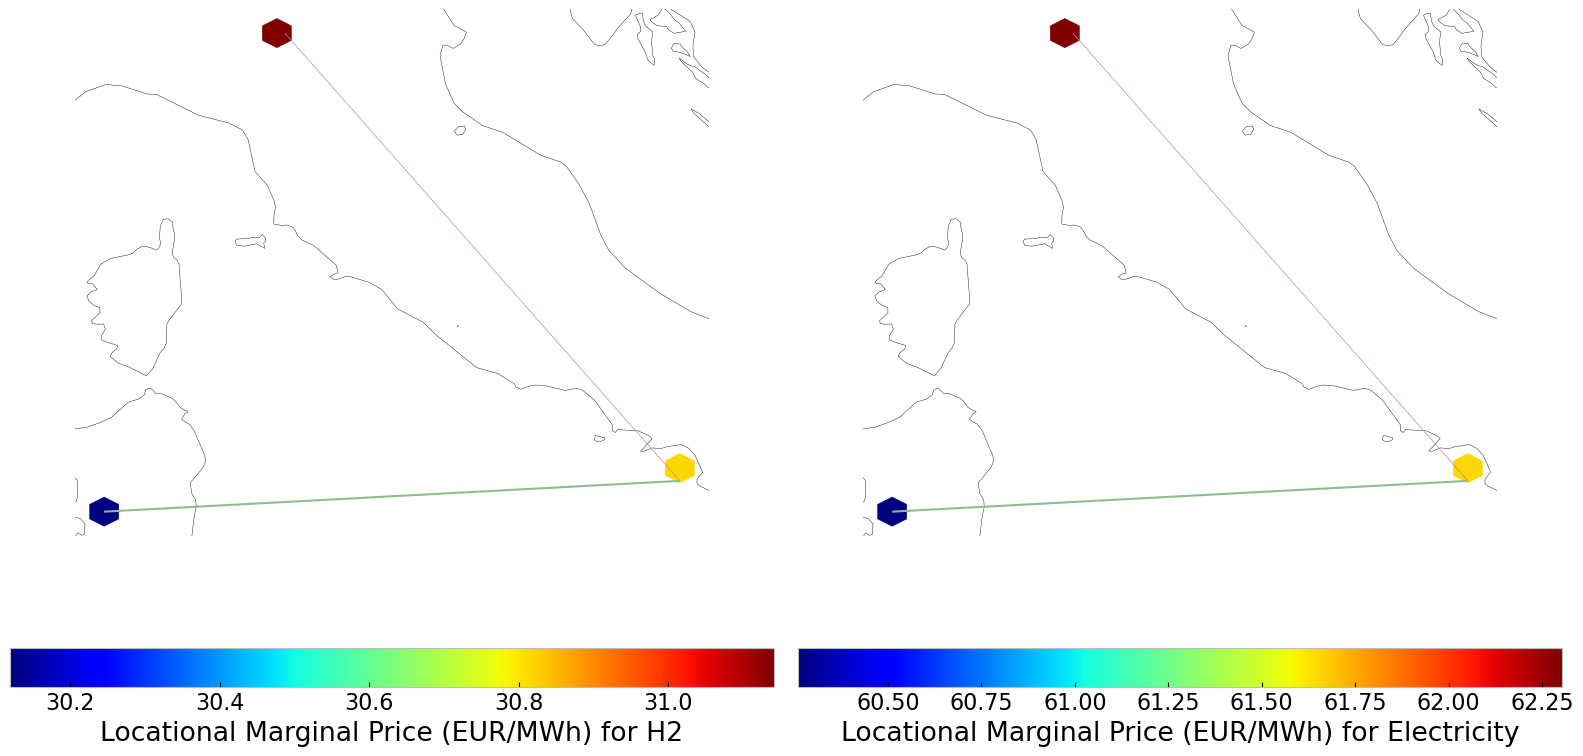

In [69]:
# Plotting
#installed cap
capacities_noinv_roll = n3.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
capacities_noinv_roll.fillna(0, inplace=True)
gen = (capacities_noinv_roll.unstack()/1000).drop(columns=['load'],inplace=False)


cap_noinv_roll = inst_cap_table(n3, color_cap)

#Generation table
# consolidated generation table
carrier = n3.generators.carrier.unique()
df_tot_generation = n3.generators_t.p.sum()

generations = pd.Series(index = n3.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

for r in region:
    for tech in carrier:
        key = f"{r} {tech}"
        if key in df_tot_generation.index:
            try:
                generations.loc[r, tech] = df_tot_generation[key]
                #print(generations.loc[r, tech])
            except KeyError:
                print('error')
generations.fillna(0, inplace=True)

gen_noinv_roll =(generations.unstack()/1000)#GWh

gen_noinv_roll  = gen_power_table(n3,colors_gen_table)

#Snapshot Summer and Winter
p = n3.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
sto = n3.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)    

gen_curve(n3, '2030-12-01', '2030-12-31', colors_gen)
gen_curve(n3, '2030-06-01', '2030-06-30', colors_gen)

#installed storage unit
inst_store_table(n3)

#State of Charge Storage unit
state_of_charge_plot(n3)
n3.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3).loc[pd.date_range(start="2013-01-01", end="2013-12-31",freq='3H')].plot(figsize=(20,10))


#Electricitty Price duration curve
price_dur_curve_plot(n3)

#avg electricity price
price_regions_table(n3)
price_regions(n3)

# Scenario Analysis

## Installed Capacity

In [70]:
comp_inst_cap = pd.DataFrame(index=capacities_base.unstack().drop(columns=['load'],inplace=False).columns)

comp_inst_cap["Base scenario"] = capacities_base.groupby("carrier").sum().div(1e3).drop(index="load")
comp_inst_cap["Allow add Inv"] = capacities_inv.groupby("carrier").sum().div(1e3).drop(index="load")
comp_inst_cap["No add Inv"] = capacities_noinv.groupby("carrier").sum().div(1e3).drop(index="load")
comp_inst_cap["No add Inv Rolling Horizon"] = capacities_noinv_roll.groupby("carrier").sum().div(1e3).drop(index="load")

comp_inst_cap.rename(index = {"coal": "Coal"}, inplace=True)
comp_inst_cap.rename(index = {"OCGT": "Open-Cycle Gas"}, inplace=True)
comp_inst_cap.rename(index = {"CCGT": "Closed-Cycle Gas"}, inplace=True)
comp_inst_cap.rename(index = {"ror": "Run of River"}, inplace=True)
comp_inst_cap.rename(index = {"offwind-ac": "Offshore Wind AC"}, inplace=True)
comp_inst_cap.rename(index = {"offwind-dc": "Offshore Wind DC"}, inplace=True)
comp_inst_cap.rename(index = {"onwind": "Onshore Wind"}, inplace=True)
comp_inst_cap.rename(index = {"solar": "Solar"}, inplace=True)
comp_inst_cap.rename(index = {"oil": "Oil"}, inplace=True)
comp_inst_cap.rename(index = {"geothermal": "Geothermal"}, inplace=True)
comp_inst_cap.rename(index = {"nuclear": "Nuclear"}, inplace=True)
comp_inst_cap.rename(index = {"biomass": "Biomass"}, inplace=True)
comp_inst_cap.rename(index = {"lignite": "Lignite"}, inplace=True)

comp_inst_cap.fillna(0, inplace=True)

In [71]:
comp_inst_cap

Base scenario  Allow add Inv  No add Inv  \
carrier                                                      
Closed-Cycle Gas       0.000000       0.000000    0.000000   
Open-Cycle Gas        39.420200      39.420200   39.420200   
Biomass                0.508000       0.508000    0.508000   
Coal                   7.275926       7.275926    7.275926   
Geothermal             0.059000       0.059000    0.059000   
Lignite                0.000000       0.000000    0.000000   
Nuclear                0.000000       0.000000    0.000000   
Offshore Wind AC       0.000000       0.000000    0.000000   
Offshore Wind DC       0.000000       0.384920    0.000000   
Oil                    0.150000       0.150000    0.150000   
Onshore Wind           1.336647      10.445437    1.336647   
Run of River           7.871540       7.871540    7.871540   
Solar                115.808285     115.808285  115.808285   

                  No add Inv Rolling Horizon  
carrier                                       
Closed-Cycle Gas                    0.000000  
Open-Cycle Gas                     39.420200  
Biomass                             0.508000  
Coal                                7.275926  
Geothermal                          0.059000  
Lignite                             0.000000  
Nuclear                             0.000000  
Offshore Wind AC                    0.000000  
Offshore Wind DC                    0.000000  
Oil                                 0.150000  
Onshore Wind                        1.336647  
Run of River                        7.871540  
Solar                             115.808285

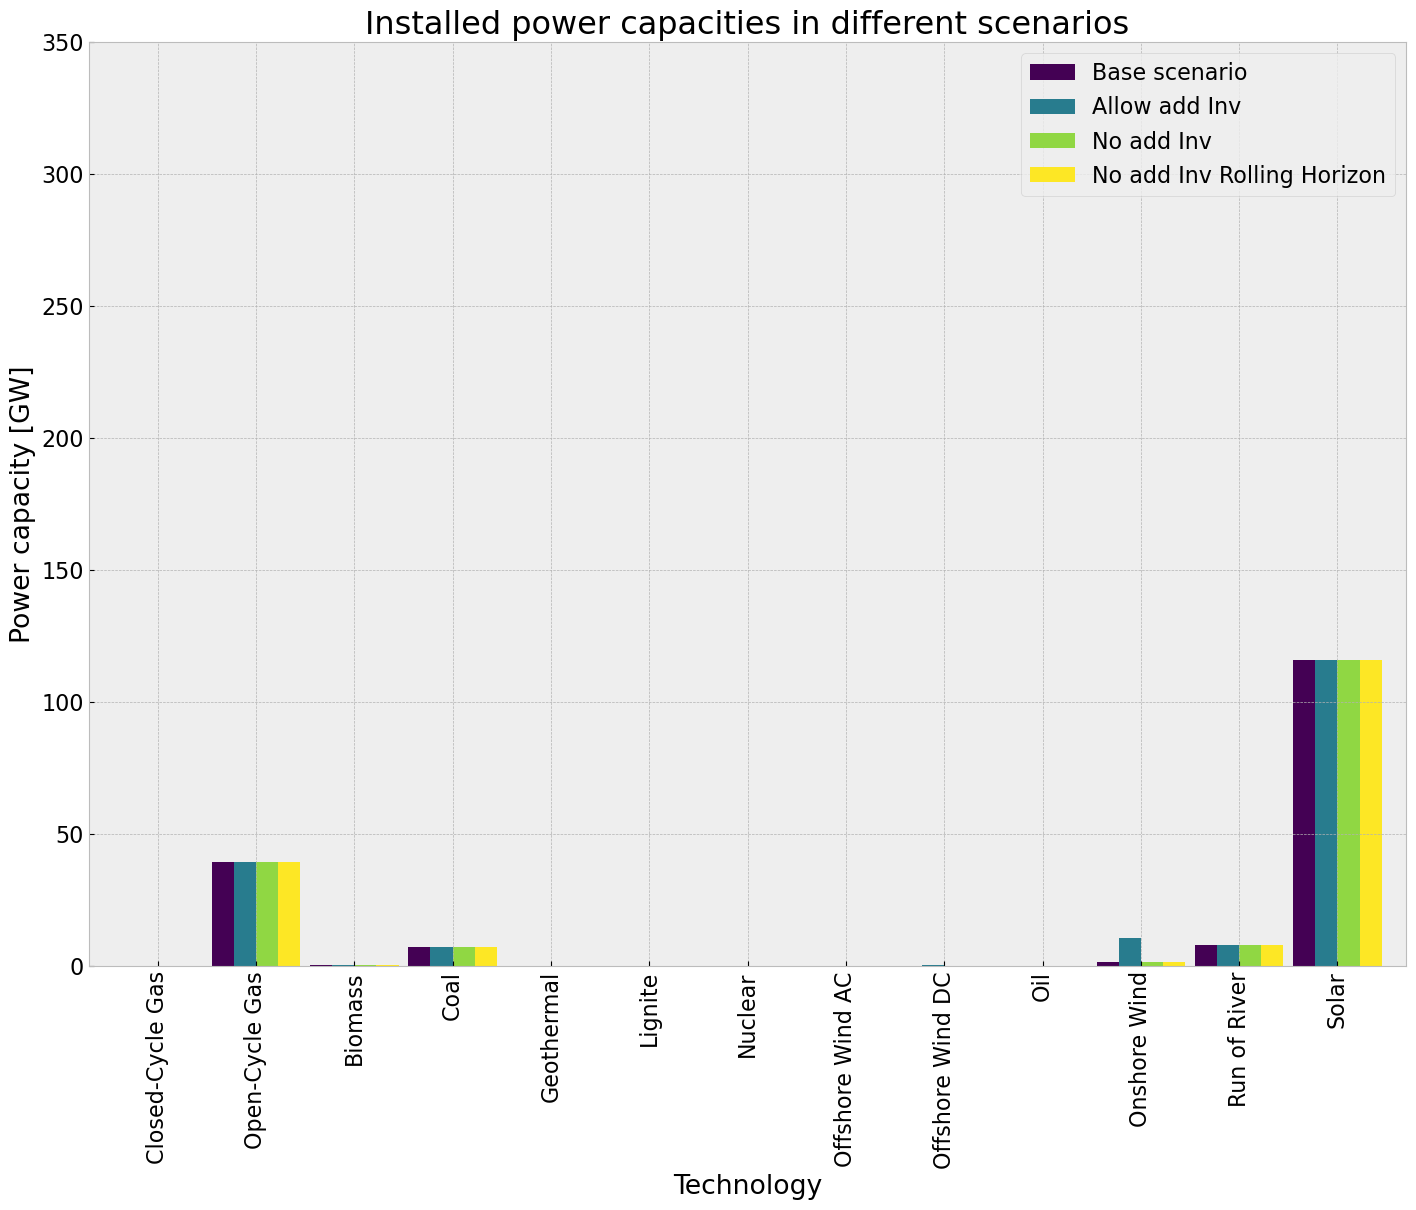

In [72]:
#colors = cm.viridis(np.linspace(0, 5, len(comp_inst_cap)))

comp_inst_cap.plot.bar(figsize=(17,12),
                        color=cm.viridis(np.linspace(0, 5, len(comp_inst_cap))),
                        grid=True,
                        xlabel="Technology",
                        ylabel="Power capacity [GW]",
                        title=f"Installed power capacities in different scenarios",
                        ylim=[0,350],
                        width=0.9
)
plt.show()

## Power Generation

In [73]:
comp_gen_electr = pd.DataFrame(index = ["Base scenario", "Allow add Inv", "No add Inv", "No add Inv Rolling Horizon"],
                                columns = tech_list_gen_table)

comp_gen_electr.loc["Base scenario"] = gen_base.sum().div(1e3) # TWh/a
comp_gen_electr.loc["Allow add Inv"] = gen_inv.sum().div(1e3) # TWh/a
comp_gen_electr.loc["No add Inv"] = gen_noinv.sum().div(1e3) # TWh/a
comp_gen_electr.loc["No add Inv Rolling Horizon"] = gen_noinv_roll.sum().div(1e3) # TWh/a


#comp_gen_electr.rename(columns = {"coal": "Coal"}, inplace=True)
#comp_gen_electr.rename(columns = {"gas": "Gas"}, inplace=True)
#comp_gen_electr.rename(columns = {"hydro": "Hydro"}, inplace=True)
#comp_gen_electr.rename(columns = {"offwind": "Offshore Wind"}, inplace=True)
#comp_gen_electr.rename(columns = {"onwind": "Onshore Wind"}, inplace=True)
#comp_gen_electr.rename(columns = {"solar": "Solar"}, inplace=True)
#comp_gen_electr.rename(columns = {"oil": "Oil"}, inplace=True)
#comp_gen_electr.rename(columns = {"geothermal": "Geothermal"}, inplace=True)
#comp_gen_electr.rename(columns = {"nuclear": "Nuclear"}, inplace=True)

comp_gen_electr.fillna(0, inplace=True)

In [86]:
n.global_constraints

type carrier_attribute sense  \
GlobalConstraint                                                                
CO2Limit                               primary_energy     co2_emissions    <=   
lv_limit          transmission_volume_expansion_limit            AC, DC    <=   

                      constant        mu  investment_period  
GlobalConstraint                                             
CO2Limit          9.000000e+07  21.12639                NaN  
lv_limit          1.957078e+07  -0.00000                NaN

In [85]:
n2.global_constraints

type carrier_attribute sense  \
GlobalConstraint                                                                
CO2Limit                               primary_energy     co2_emissions    <=   
lv_limit          transmission_volume_expansion_limit            AC, DC    <=   

                      constant           mu  investment_period  
GlobalConstraint                                                
CO2Limit          9.000000e+07 -6081.872351                NaN  
lv_limit          1.957078e+07     0.000000                NaN

In [84]:
n1.global_constraints

type carrier_attribute sense  \
GlobalConstraint                                                                
CO2Limit                               primary_energy     co2_emissions    <=   
lv_limit          transmission_volume_expansion_limit            AC, DC    <=   

                      constant         mu  investment_period  
GlobalConstraint                                              
CO2Limit          9.000000e+07 -68.127086                NaN  
lv_limit          1.957078e+07   0.000000                NaN

In [83]:
n3.global_constraints

type carrier_attribute sense  \
GlobalConstraint                                                                
CO2Limit                               primary_energy     co2_emissions    <=   
lv_limit          transmission_volume_expansion_limit            AC, DC    <=   

                      constant   mu  investment_period  
GlobalConstraint                                        
CO2Limit          9.000000e+07  0.0                NaN  
lv_limit          1.957078e+07  0.0                NaN

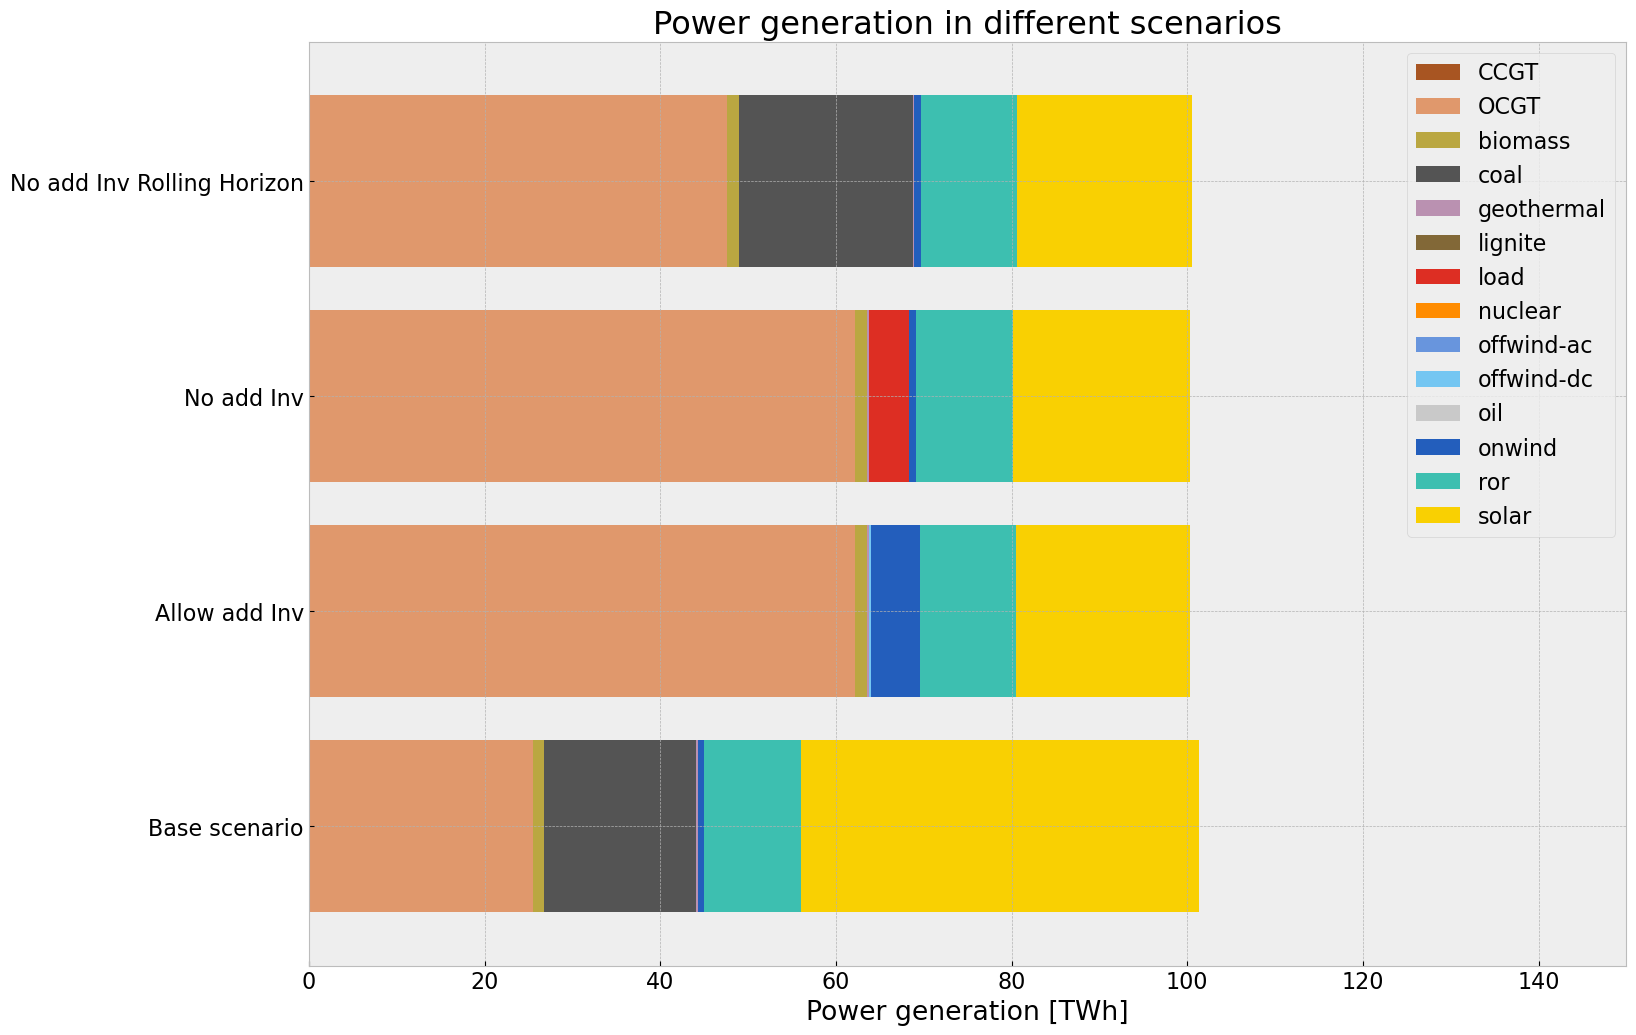

In [74]:
comp_gen_electr.plot.barh(figsize=(17,12),
                        color=colors_gen_table,
                        grid=True,
                        stacked=True, 
                        ylabel="",
                        xlabel="Power generation [TWh]",
                        title=f"Power generation in different scenarios",
                        xlim=[0,150],
                        width=0.8
)
plt.show()

## Average System Cost

In [75]:
tech_comp = system_cost_base.index.tolist()
comp_system_cost = pd.DataFrame(index = ["Base scenario", "Allowed add Inv", "No add Inv", "No add Inv Rolling Horizon"],
                                columns =tech_comp)

demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1) # the same in each scenario

comp_system_cost.loc["Base scenario"] = system_cost_base # Million €/a
comp_system_cost.loc["Allowed add Inv"] = system_cost_inv # Million €/a
#if tot_cost_0_PV > 0: 
#    comp_system_cost.loc["0% PV potential"] = system_cost_0_PV # Million €/a
#else: comp_system_cost.loc["0% PV potential"] = 0.0
#if tot_cost_20_PV > 0: 
#    comp_system_cost.loc["20% PV potential"] = system_cost_20_PV # Million €/a
#else: comp_system_cost.loc["20% PV potential"] = 0.0
comp_system_cost.loc["No add Inv"] = system_cost_noinv # Million €/a
comp_system_cost.loc["No add Inv Rolling Horizon"] = system_cost_noinv_roll # Million €/a

if 'AC' in system_cost_base:
    comp_system_cost.AC = comp_system_cost.AC-system_cost_base.AC # expenditure for already existing transmission lines

comp_system_cost[comp_system_cost<0] = 0 # since we subtact the AC cost (for the 0% or 20%) 
#comp_system_cost.iloc[0,0] = system_cost_base.AC


comp_system_cost = comp_system_cost.mul(1e6).div(demand) #eur0/

#comp_system_cost.rename(columns = {"battery storage": "Battery storage"}, inplace=True)
#comp_system_cost.rename(columns = {"hydrogen storage underground": "Hydrogen storage underground"}, inplace=True)

comp_system_cost.fillna(0, inplace=True)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2925963551.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_system_cost.fillna(0, inplace=True)


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2357507078.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if comp_system_cost.columns[i] == n.carriers.nice_name[j]:
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\2357507078.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors_comp.append(n.carriers.color[j])


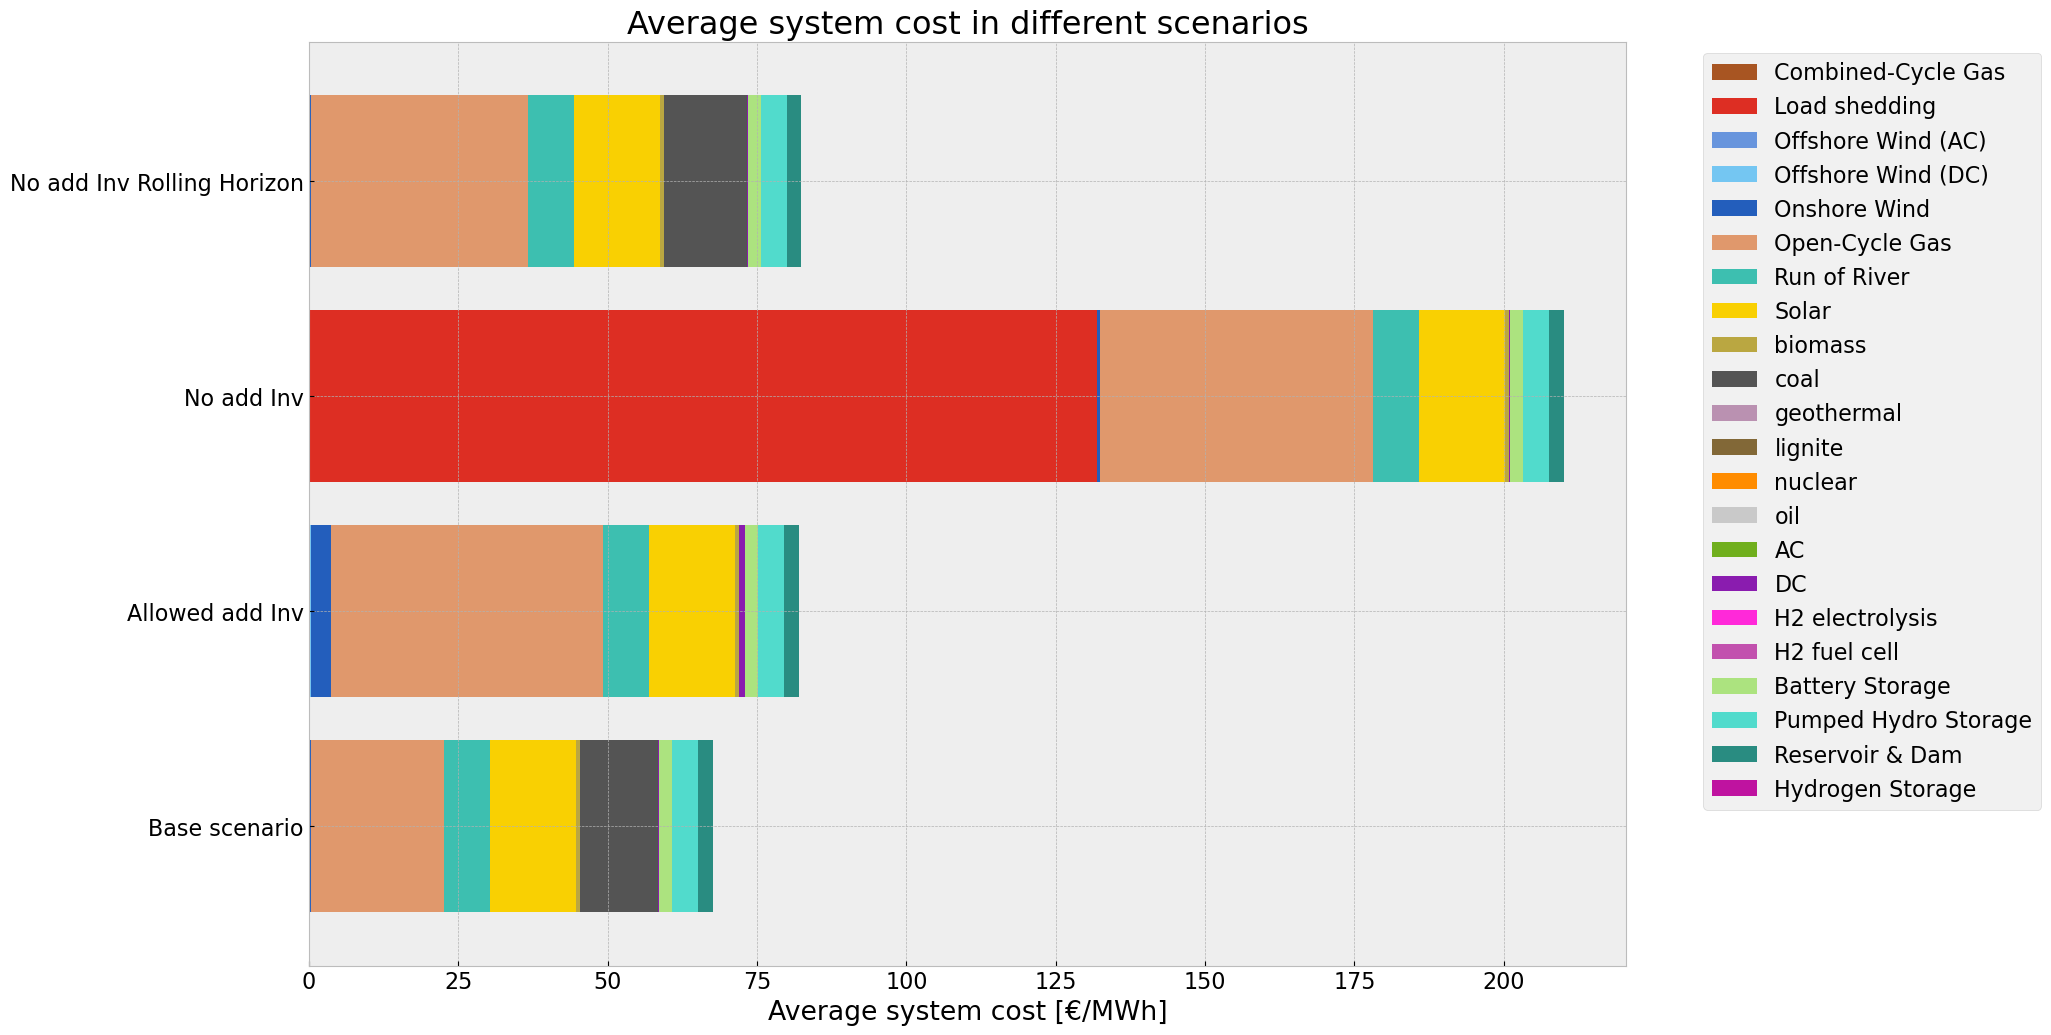

In [82]:
colors_comp = []

for i in range(len(comp_system_cost.columns)):
    for j in range(len(n.carriers.nice_name)):
        if comp_system_cost.columns[i] == n.carriers.nice_name[j]:
            colors_comp.append(n.carriers.color[j])
            #print(n.carriers.nice_name[j],comp_system_cost.columns[i],n.carriers.color[j])
            break  # break the inner loop once a match is found  



comp_system_cost.plot.barh(figsize=(17,12),
                        color=colors_comp,
                        grid=True,
                        stacked=True,
                        ylabel="",
                        xlabel="Average system cost [€/MWh]",
                        title=f"Average system cost in different scenarios",
                        #xlim=[0,1500],
                        width=0.8
)
# Move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [77]:
#n3.generators_t.p.sum()#.groupby(n.generators.carrier).sum()


In [78]:
#n3.statistics.energy_balance(aggregate_time=False, aggregate_bus=False).loc[:, :, "AC",:].droplevel(2).sum(axis=1)

## Curtailment

In [79]:
comp_curtailment = pd.DataFrame(index = ["Base scenario", "Allow add Inv", "No add Inv", "No add Inv Rolling Horizon"],
                                columns = stat_base.loc["Generator"].index)

comp_curtailment.loc["Base scenario"] = stat_base.loc["Generator"].Curtailment.div(1e6) # TWh
comp_curtailment.loc["Allow add Inv"] = stat_inv.loc["Generator"].Curtailment.div(1e6) # TWh
comp_curtailment.loc["No add Inv"] = stat_noinv.loc["Generator"].Curtailment.div(1e6) # TWh
comp_curtailment.loc["No add Inv Rolling Horizon"] = stat_noinv_roll.loc["Generator"].Curtailment.div(1e6) # TWh

comp_curtailment.fillna(0, inplace=True)

In [80]:
color_curtailment=[]

for i in range(len(comp_curtailment.columns)):
    for j in range(len(n.carriers.nice_name)):
        if comp_curtailment.columns[i] == n.carriers.nice_name[j]:
            color_curtailment.append(n.carriers.color[j])
            #print(n.carriers.nice_name[j],comp_system_cost.columns[i],n.carriers.color[j])
            break  # break the inner loop once a match is found 

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3109801822.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if comp_curtailment.columns[i] == n.carriers.nice_name[j]:
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_19656\3109801822.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_curtailment.append(n.carriers.color[j])


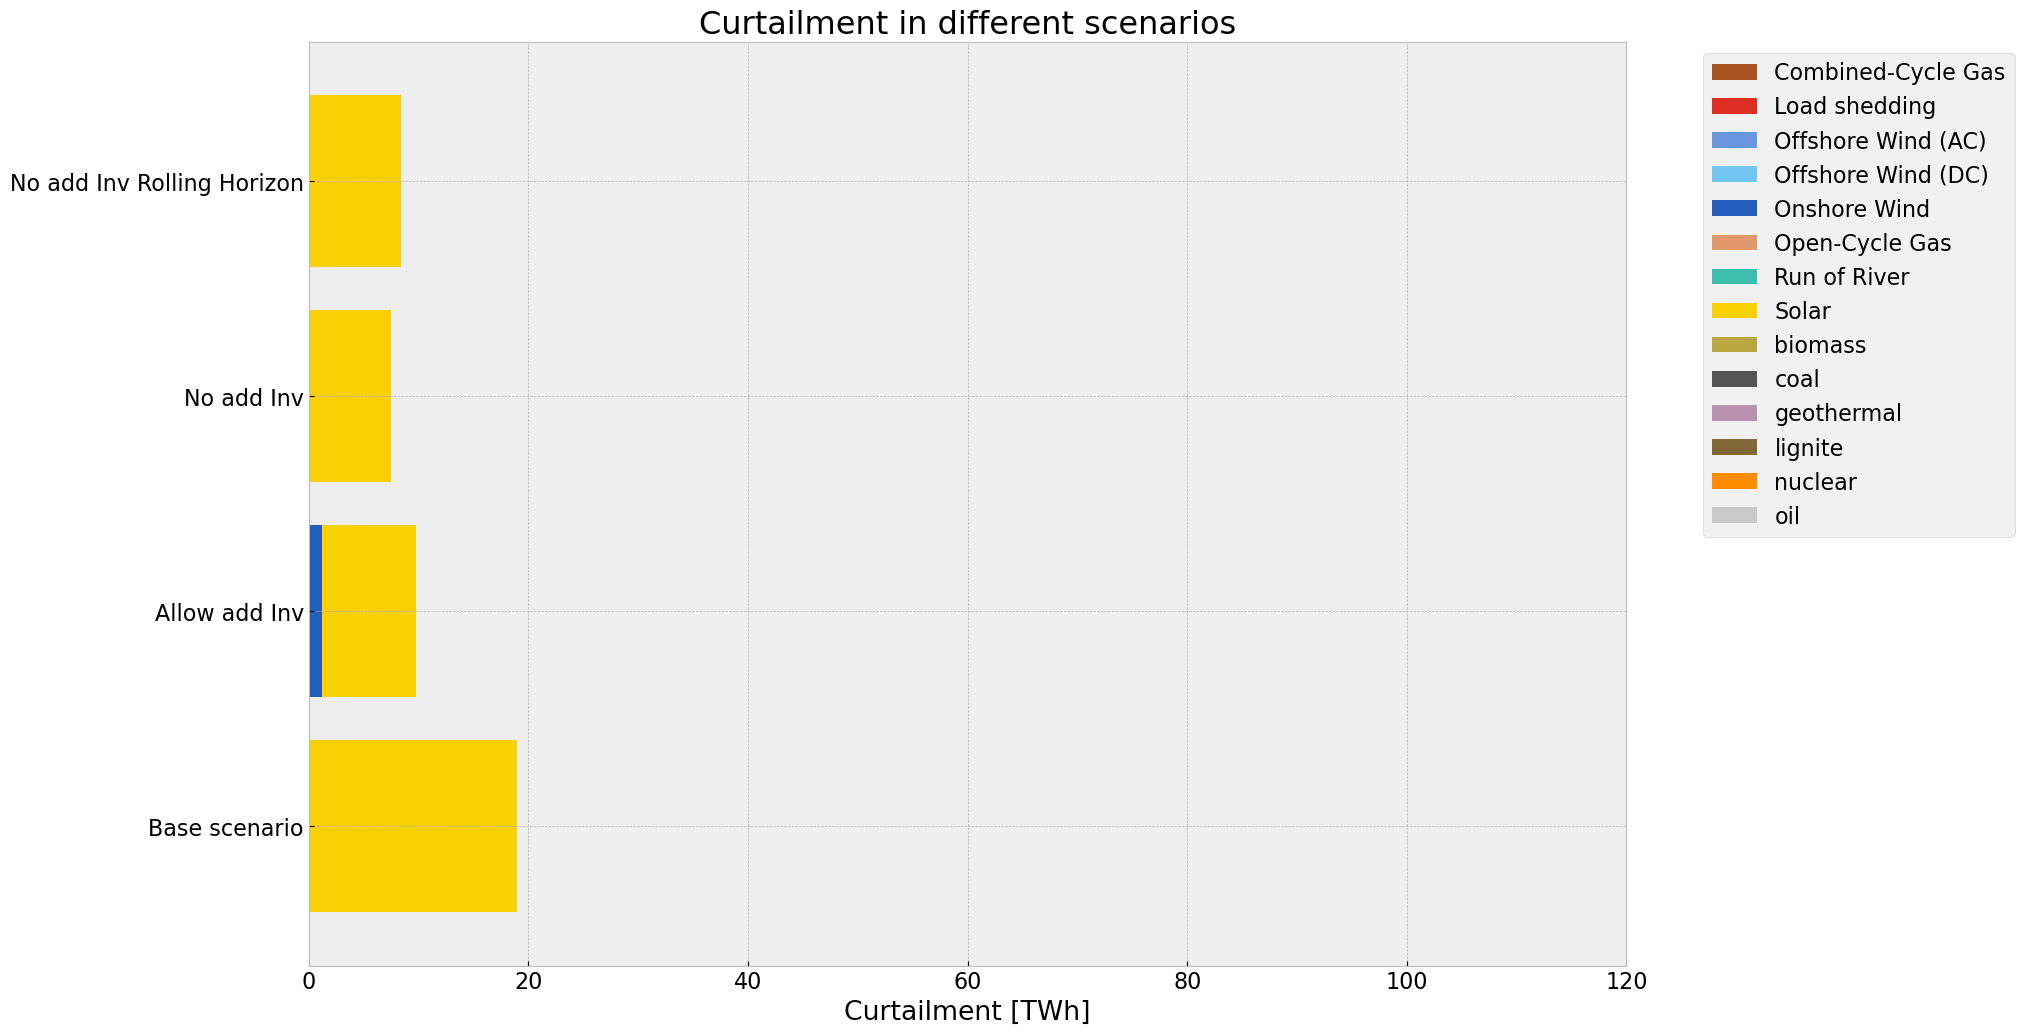

In [81]:
comp_curtailment.plot.barh(figsize=(17,12),
                        color=color_curtailment,
                        grid=True,
                        stacked=True, 
                        ylabel="",
                        xlabel="Curtailment [TWh]",
                        title=f"Curtailment in different scenarios",
                        xlim=[0,120],
                        width=0.8
)
# Move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()